In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/PSIQUIATRIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=120.2, y1=121.6
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 197
Page 1, Q1, A: Yellow percentage: 0.0%


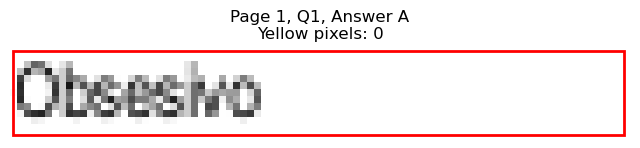

Page 1, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=121.7, y1=133.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 262
Page 1, Q1, B: Yellow percentage: 0.0%


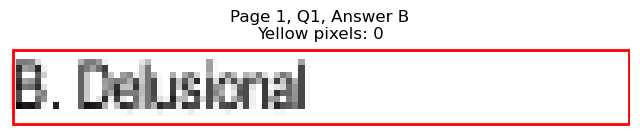

Page 1, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=139.1, y1=145.6
Page 1, Q1, C: Yellow pixels: 522
Page 1, Q1, C: Total non-white pixels: 858
Page 1, Q1, C: Yellow percentage: 60.8%


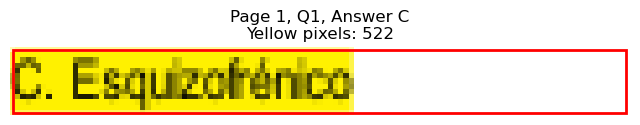

Page 1, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=375.5, y1=121.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 262
Page 1, Q1, D: Yellow percentage: 0.0%


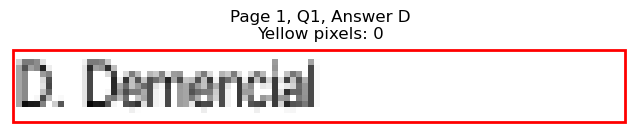

Page 1, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=389.0, y1=133.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 314
Page 1, Q1, E: Yellow percentage: 0.0%


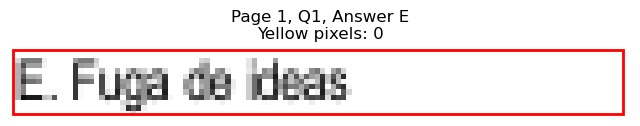


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=136.1, y1=193.6
Page 1, Q2, A: Yellow pixels: 385
Page 1, Q2, A: Total non-white pixels: 678
Page 1, Q2, A: Yellow percentage: 56.8%


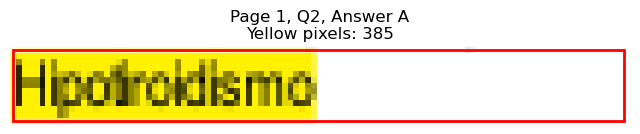

Page 1, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=166.0, y1=205.6
Page 1, Q2, B: Yellow pixels: 51
Page 1, Q2, B: Total non-white pixels: 514
Page 1, Q2, B: Yellow percentage: 9.9%


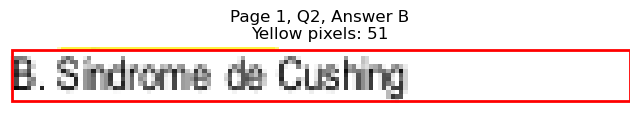

Page 1, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=136.0, y1=217.7
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 321
Page 1, Q2, C: Yellow percentage: 0.0%


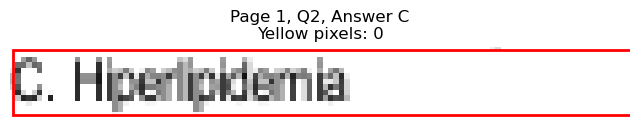

Page 1, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=399.5, y1=193.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 388
Page 1, Q2, D: Yellow percentage: 0.0%


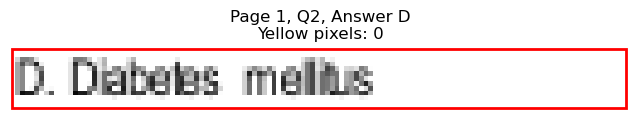

Page 1, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=407.8, y1=205.6
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 431
Page 1, Q2, E: Yellow percentage: 0.0%


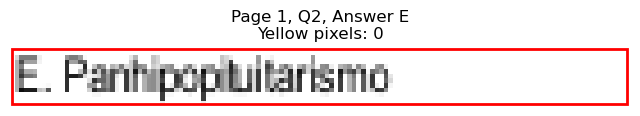


Page 1, Q2 - Selected Answer: A (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=130.0, y1=265.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 266
Page 1, Q3, A: Yellow percentage: 0.0%


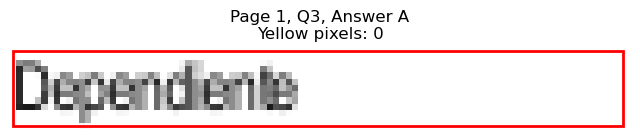

Page 1, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=114.2, y1=277.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 217
Page 1, Q3, B: Yellow percentage: 0.0%


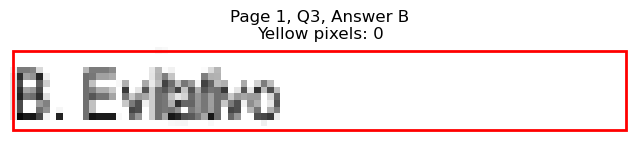

Page 1, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=121.0, y1=289.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 221
Page 1, Q3, C: Yellow percentage: 0.0%


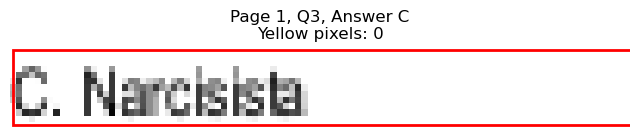

Page 1, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=374.1, y1=265.7
Page 1, Q3, D: Yellow pixels: 391
Page 1, Q3, D: Total non-white pixels: 650
Page 1, Q3, D: Yellow percentage: 60.2%


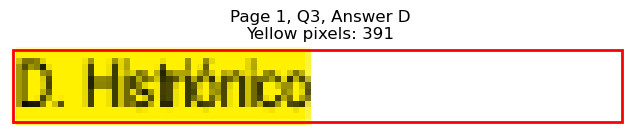

Page 1, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=371.0, y1=277.7
Page 1, Q3, E: Yellow pixels: 49
Page 1, Q3, E: Total non-white pixels: 283
Page 1, Q3, E: Yellow percentage: 17.3%


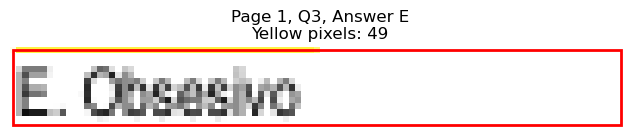


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.6, y0=362.5, x1=175.1, y1=374.6
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 469
Page 1, Q4, A: Yellow percentage: 0.0%


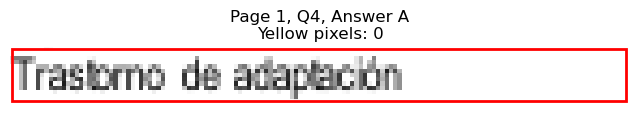

Page 1, Q4 - B: Detected box: x0=108.1, y0=374.5, x1=151.0, y1=386.6
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 188
Page 1, Q4, B: Yellow percentage: 0.0%


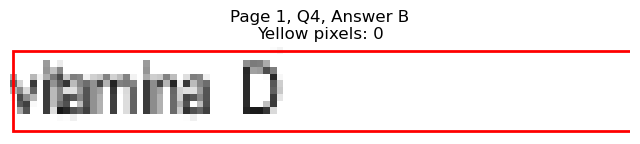

Page 1, Q4 - C: Detected box: x0=71.3, y0=386.5, x1=127.7, y1=398.6
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 375
Page 1, Q4, C: Yellow percentage: 0.0%


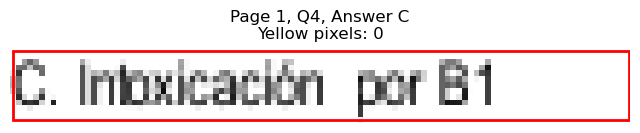

Page 1, Q4 - D: Detected box: x0=322.9, y0=362.5, x1=407.7, y1=374.6
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 406
Page 1, Q4, D: Yellow percentage: 0.0%


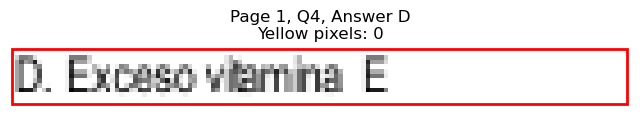

Page 1, Q4 - E: Detected box: x0=359.6, y0=374.5, x1=411.7, y1=386.6
Page 1, Q4, E: Yellow pixels: 441
Page 1, Q4, E: Total non-white pixels: 663
Page 1, Q4, E: Yellow percentage: 66.5%


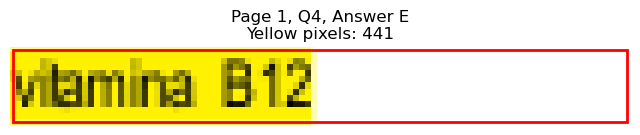


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.6, y0=458.6, x1=133.0, y1=470.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 519
Page 1, Q5, A: Yellow percentage: 0.0%


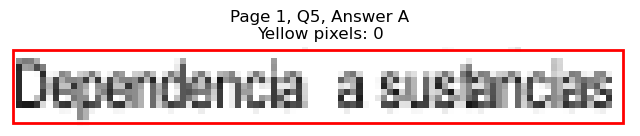

Page 1, Q5 - B: Detected box: x0=155.3, y0=470.6, x1=223.0, y1=482.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 358
Page 1, Q5, B: Yellow percentage: 0.0%


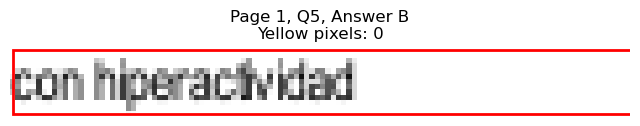

Page 1, Q5 - C: Detected box: x0=71.3, y0=483.4, x1=151.0, y1=495.4
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 385
Page 1, Q5, C: Yellow percentage: 0.0%


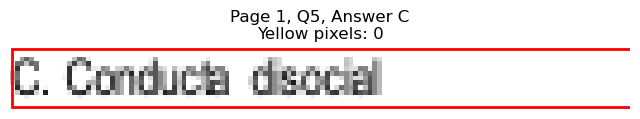

Page 1, Q5 - D: Detected box: x0=322.9, y0=458.6, x1=434.2, y1=470.6
Page 1, Q5, D: Yellow pixels: 832
Page 1, Q5, D: Total non-white pixels: 1430
Page 1, Q5, D: Yellow percentage: 58.2%


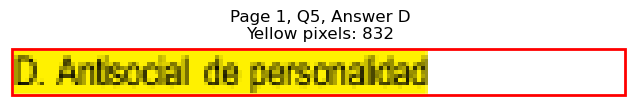

Page 1, Q5 - E: Detected box: x0=322.9, y0=470.6, x1=434.8, y1=482.6
Page 1, Q5, E: Yellow pixels: 109
Page 1, Q5, E: Total non-white pixels: 675
Page 1, Q5, E: Yellow percentage: 16.1%


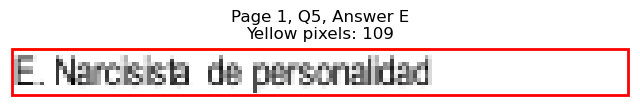


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.6, y0=519.4, x1=121.0, y1=531.4
Page 1, Q6, A: Yellow pixels: 309
Page 1, Q6, A: Total non-white pixels: 481
Page 1, Q6, A: Yellow percentage: 64.2%


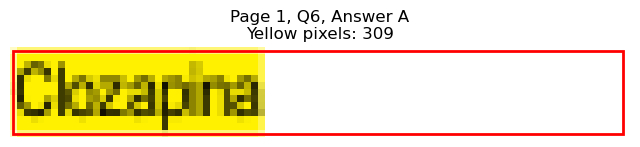

Page 1, Q6 - B: Detected box: x0=71.3, y0=531.4, x1=125.5, y1=543.5
Page 1, Q6, B: Yellow pixels: 35
Page 1, Q6, B: Total non-white pixels: 304
Page 1, Q6, B: Yellow percentage: 11.5%


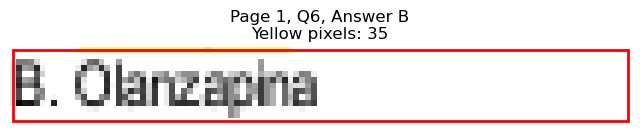

Page 1, Q6 - C: Detected box: x0=71.3, y0=543.4, x1=123.3, y1=555.5
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 266
Page 1, Q6, C: Yellow percentage: 0.0%


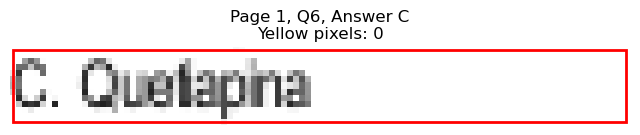

Page 1, Q6 - D: Detected box: x0=322.9, y0=519.4, x1=380.0, y1=531.4
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 304
Page 1, Q6, D: Yellow percentage: 0.0%


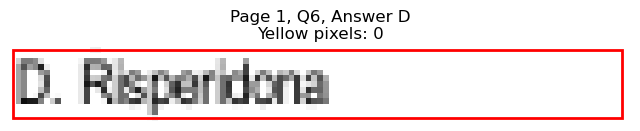

Page 1, Q6 - E: Detected box: x0=322.9, y0=531.4, x1=389.8, y1=543.5
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 320
Page 1, Q6, E: Yellow percentage: 0.0%


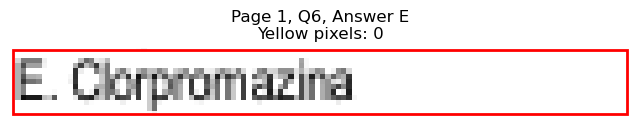


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.6, y0=615.5, x1=159.3, y1=627.5
Page 1, Q7, A: Yellow pixels: 650
Page 1, Q7, A: Total non-white pixels: 975
Page 1, Q7, A: Yellow percentage: 66.7%


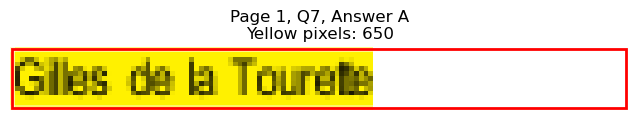

Page 1, Q7 - B: Detected box: x0=71.3, y0=627.5, x1=135.2, y1=639.6
Page 1, Q7, B: Yellow pixels: 74
Page 1, Q7, B: Total non-white pixels: 424
Page 1, Q7, B: Yellow percentage: 17.5%


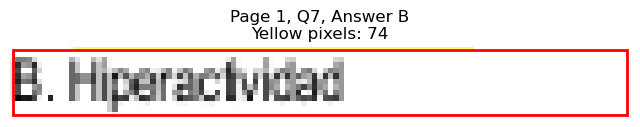

Page 1, Q7 - C: Detected box: x0=71.3, y0=639.5, x1=106.0, y1=651.6
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 333
Page 1, Q7, C: Yellow percentage: 0.0%


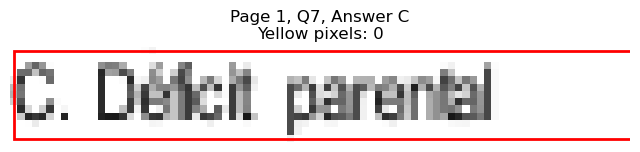

Page 1, Q7 - D: Detected box: x0=322.9, y0=615.5, x1=366.5, y1=627.5
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 203
Page 1, Q7, D: Yellow percentage: 0.0%


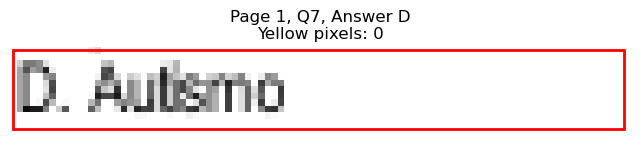

Page 1, Q7 - E: Detected box: x0=322.9, y0=627.5, x1=415.3, y1=639.6
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 452
Page 1, Q7, E: Yellow percentage: 0.0%


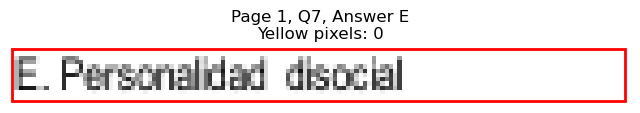


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.6, y0=700.3, x1=178.0, y1=712.3
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 474
Page 1, Q8, A: Yellow percentage: 0.0%


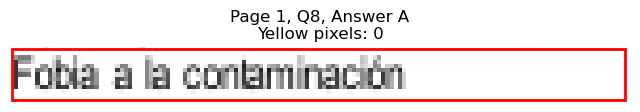

Page 1, Q8 - B: Detected box: x0=71.3, y0=712.3, x1=195.2, y1=724.4
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 577
Page 1, Q8, B: Yellow percentage: 0.0%


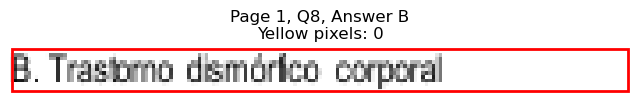

Page 1, Q8 - C: Detected box: x0=71.3, y0=724.3, x1=169.7, y1=736.4
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 491
Page 1, Q8, C: Yellow percentage: 0.0%


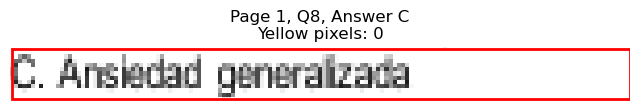

Page 1, Q8 - D: Detected box: x0=322.9, y0=700.3, x1=454.5, y1=712.3
Page 1, Q8, D: Yellow pixels: 1063
Page 1, Q8, D: Total non-white pixels: 1703
Page 1, Q8, D: Yellow percentage: 62.4%


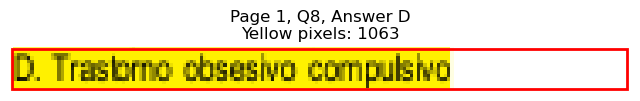

Page 1, Q8 - E: Detected box: x0=322.9, y0=712.3, x1=410.0, y1=724.4
Page 1, Q8, E: Yellow pixels: 1
Page 1, Q8, E: Total non-white pixels: 569
Page 1, Q8, E: Yellow percentage: 0.2%


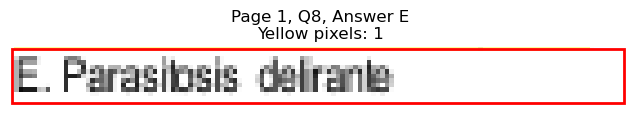


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=122.5, y1=121.6
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 227
Page 2, Q1, A: Yellow percentage: 0.0%


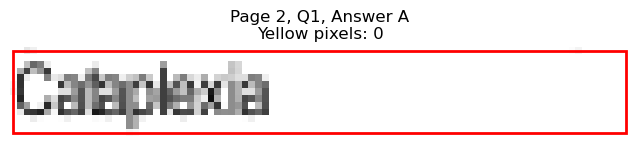

Page 2, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=121.7, y1=133.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 274
Page 2, Q1, B: Yellow percentage: 0.0%


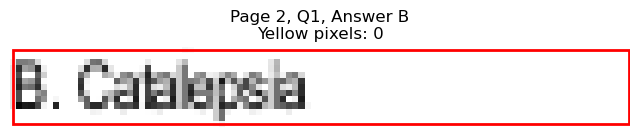

Page 2, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=128.5, y1=145.6
Page 2, Q1, C: Yellow pixels: 430
Page 2, Q1, C: Total non-white pixels: 728
Page 2, Q1, C: Yellow percentage: 59.1%


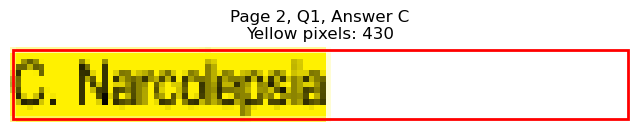

Page 2, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=392.0, y1=121.6
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 353
Page 2, Q1, D: Yellow percentage: 0.0%


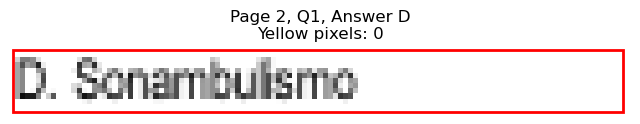

Page 2, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=368.8, y1=133.6
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 231
Page 2, Q1, E: Yellow percentage: 0.0%


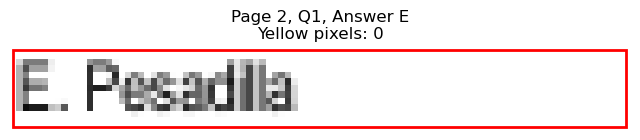


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=162.4, y1=205.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 394
Page 2, Q2, A: Yellow percentage: 0.0%


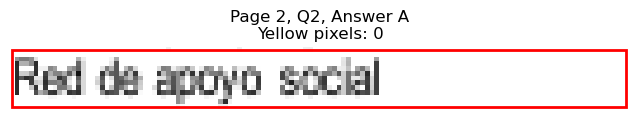

Page 2, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=152.6, y1=217.7
Page 2, Q2, B: Yellow pixels: 623
Page 2, Q2, B: Total non-white pixels: 1040
Page 2, Q2, B: Yellow percentage: 59.9%


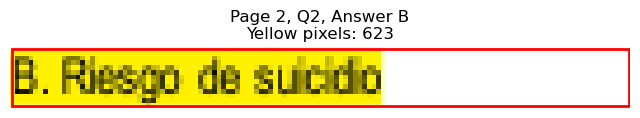

Page 2, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=154.0, y1=229.7
Page 2, Q2, C: Yellow pixels: 79
Page 2, Q2, C: Total non-white pixels: 578
Page 2, Q2, C: Yellow percentage: 13.7%


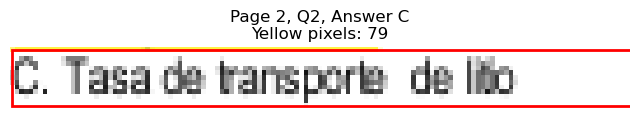

Page 2, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=422.0, y1=205.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 495
Page 2, Q2, D: Yellow percentage: 0.0%


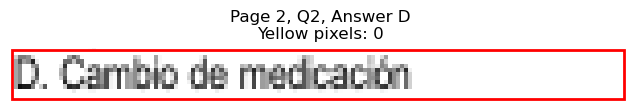

Page 2, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=427.3, y1=217.7
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 514
Page 2, Q2, E: Yellow percentage: 0.0%


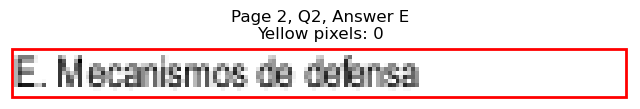


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=128.4, y0=253.6, x1=178.0, y1=265.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 242
Page 2, Q3, A: Yellow percentage: 0.0%


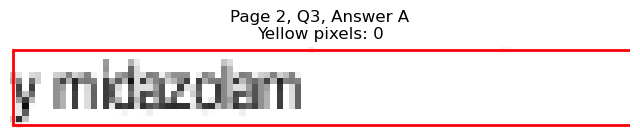

Page 2, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=124.7, y1=277.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 467
Page 2, Q3, B: Yellow percentage: 0.0%


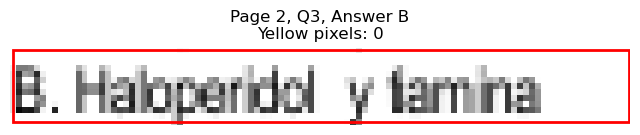

Page 2, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=185.5, y1=289.7
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 541
Page 2, Q3, C: Yellow percentage: 0.0%


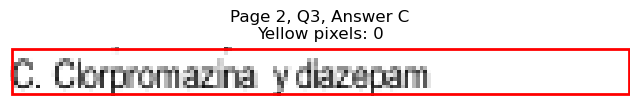

Page 2, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=410.2, y1=265.7
Page 2, Q3, D: Yellow pixels: 677
Page 2, Q3, D: Total non-white pixels: 1118
Page 2, Q3, D: Yellow percentage: 60.6%


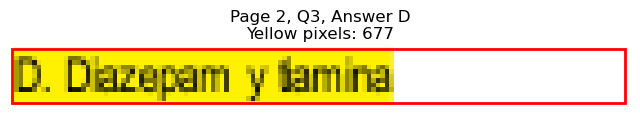

Page 2, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=412.3, y1=277.7
Page 2, Q3, E: Yellow pixels: 85
Page 2, Q3, E: Total non-white pixels: 511
Page 2, Q3, E: Yellow percentage: 16.6%


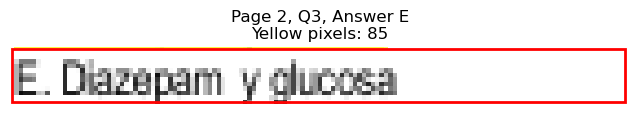


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=127.0, y1=338.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 218
Page 2, Q4, A: Yellow percentage: 0.0%


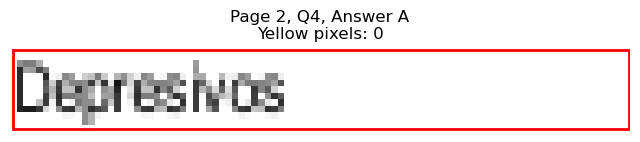

Page 2, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=124.0, y1=350.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 248
Page 2, Q4, B: Yellow percentage: 0.0%


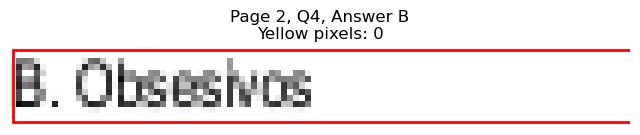

Page 2, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=119.5, y1=362.5
Page 2, Q4, C: Yellow pixels: 433
Page 2, Q4, C: Total non-white pixels: 611
Page 2, Q4, C: Yellow percentage: 70.9%


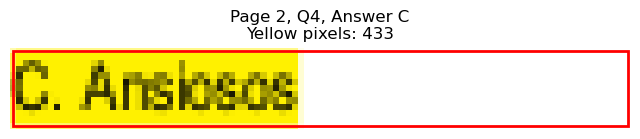

Page 2, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=378.5, y1=338.5
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 269
Page 2, Q4, D: Yellow percentage: 0.0%


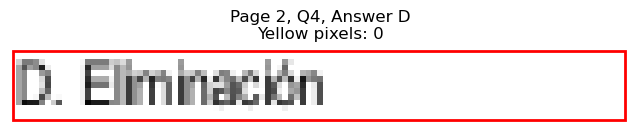

Page 2, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=373.2, y1=350.5
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 235
Page 2, Q4, E: Yellow percentage: 0.0%


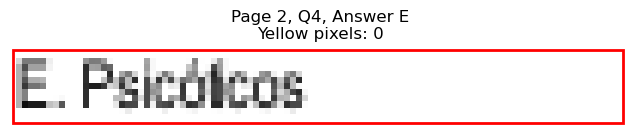


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=125.5, y1=398.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 242
Page 2, Q5, A: Yellow percentage: 0.0%


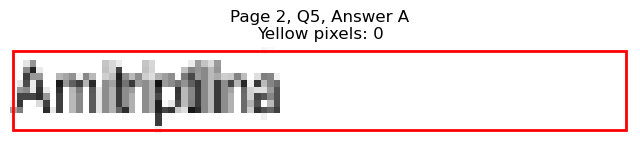

Page 2, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=121.7, y1=410.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 252
Page 2, Q5, B: Yellow percentage: 0.0%


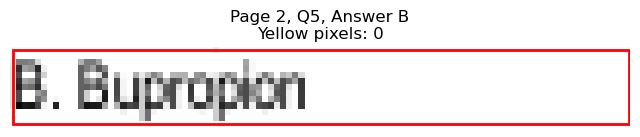

Page 2, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=136.1, y1=422.6
Page 2, Q5, C: Yellow pixels: 509
Page 2, Q5, C: Total non-white pixels: 819
Page 2, Q5, C: Yellow percentage: 62.1%


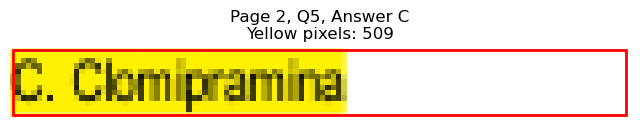

Page 2, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=377.8, y1=398.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 282
Page 2, Q5, D: Yellow percentage: 0.0%


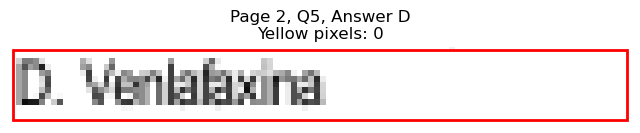

Page 2, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=372.5, y1=410.6
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 238
Page 2, Q5, E: Yellow percentage: 0.0%


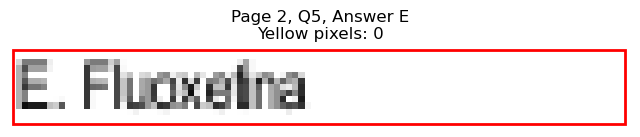


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=115.0, y1=458.6
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 165
Page 2, Q6, A: Yellow percentage: 0.0%


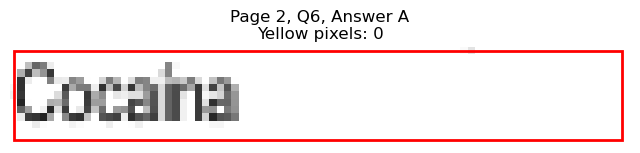

Page 2, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=102.2, y1=470.6
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 138
Page 2, Q6, B: Yellow percentage: 0.0%


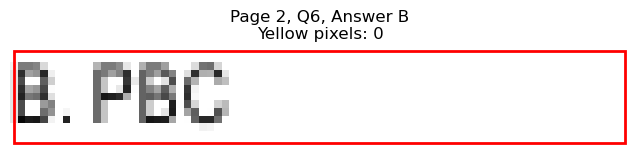

Page 2, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=112.0, y1=482.6
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 174
Page 2, Q6, C: Yellow percentage: 0.0%


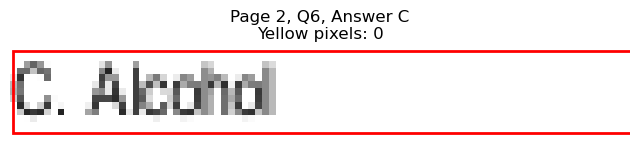

Page 2, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=376.4, y1=458.6
Page 2, Q6, D: Yellow pixels: 406
Page 2, Q6, D: Total non-white pixels: 676
Page 2, Q6, D: Yellow percentage: 60.1%


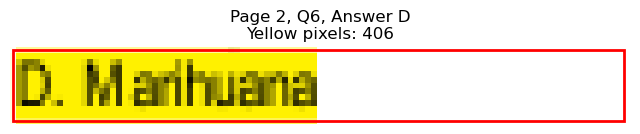

Page 2, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=372.5, y1=470.6
Page 2, Q6, E: Yellow pixels: 51
Page 2, Q6, E: Total non-white pixels: 306
Page 2, Q6, E: Yellow percentage: 16.7%


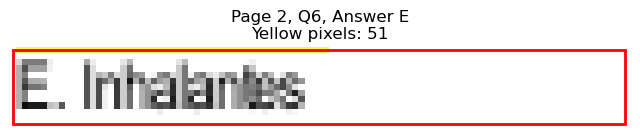


Page 2, Q6 - Selected Answer: D (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=175.0, y1=519.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 461
Page 2, Q7, A: Yellow percentage: 0.0%


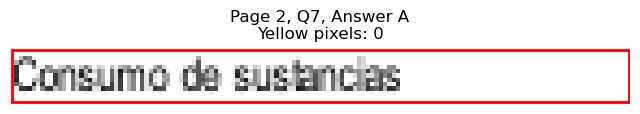

Page 2, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=127.8, y1=531.4
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 294
Page 2, Q7, B: Yellow percentage: 0.0%


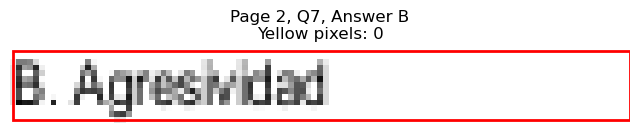

Page 2, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=146.5, y1=543.5
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 507
Page 2, Q7, C: Yellow percentage: 0.0%


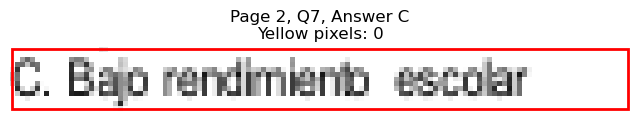

Page 2, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=425.0, y1=519.4
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 494
Page 2, Q7, D: Yellow percentage: 0.0%


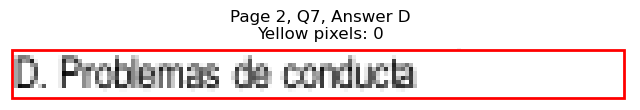

Page 2, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=397.4, y1=531.4
Page 2, Q7, E: Yellow pixels: 639
Page 2, Q7, E: Total non-white pixels: 949
Page 2, Q7, E: Yellow percentage: 67.3%


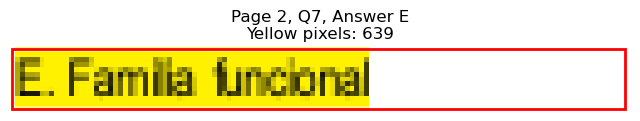


Page 2, Q7 - Selected Answer: E (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=133.0, y1=591.5
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 261
Page 2, Q8, A: Yellow percentage: 0.0%


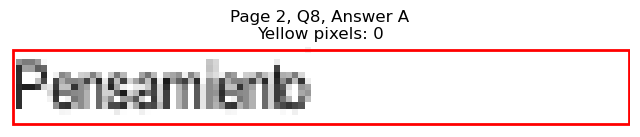

Page 2, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=115.0, y1=603.5
Page 2, Q8, B: Yellow pixels: 383
Page 2, Q8, B: Total non-white pixels: 546
Page 2, Q8, B: Yellow percentage: 70.1%


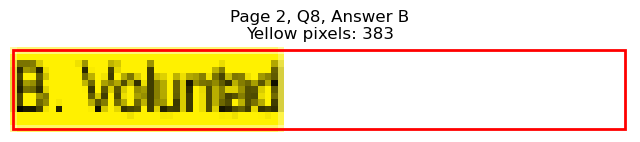

Page 2, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=127.0, y1=615.5
Page 2, Q8, C: Yellow pixels: 42
Page 2, Q8, C: Total non-white pixels: 318
Page 2, Q8, C: Yellow percentage: 13.2%


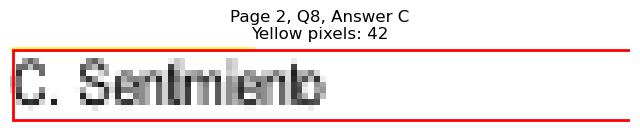

Page 2, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=376.3, y1=591.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 280
Page 2, Q8, D: Yellow percentage: 0.0%


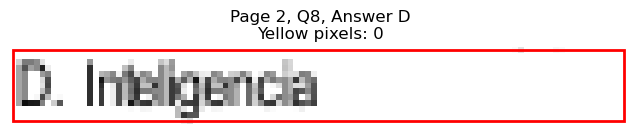

Page 2, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=376.3, y1=603.5
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 261
Page 2, Q8, E: Yellow percentage: 0.0%


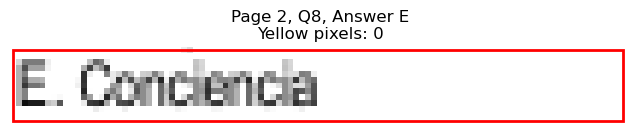


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.6, y0=663.5, x1=119.5, y1=675.6
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 185
Page 2, Q9, A: Yellow percentage: 0.0%


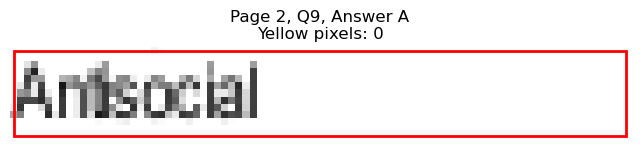

Page 2, Q9 - B: Detected box: x0=71.3, y0=676.3, x1=120.3, y1=688.3
Page 2, Q9, B: Yellow pixels: 358
Page 2, Q9, B: Total non-white pixels: 611
Page 2, Q9, B: Yellow percentage: 58.6%


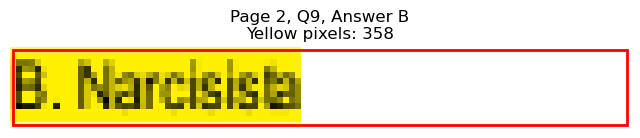

Page 2, Q9 - C: Detected box: x0=71.3, y0=688.3, x1=120.2, y1=700.3
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 274
Page 2, Q9, C: Yellow percentage: 0.0%


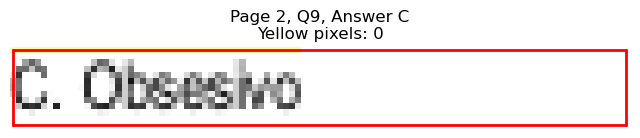

Page 2, Q9 - D: Detected box: x0=322.9, y0=663.5, x1=374.0, y1=675.6
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 262
Page 2, Q9, D: Yellow percentage: 0.0%


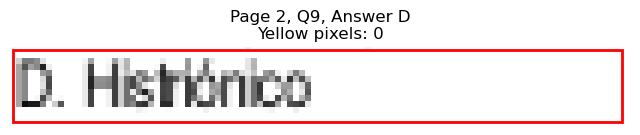

Page 2, Q9 - E: Detected box: x0=322.9, y0=676.3, x1=376.3, y1=688.3
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 258
Page 2, Q9, E: Yellow percentage: 0.0%


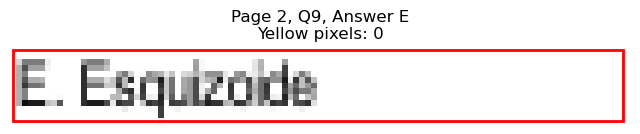


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=82.6, y0=724.3, x1=128.5, y1=736.4
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 241
Page 2, Q10, A: Yellow percentage: 0.0%


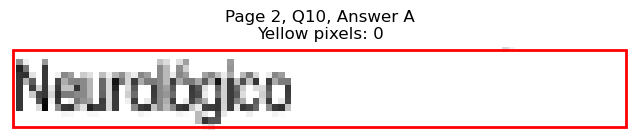

Page 2, Q10 - B: Detected box: x0=71.3, y0=736.4, x1=133.0, y1=748.4
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 332
Page 2, Q10, B: Yellow percentage: 0.0%


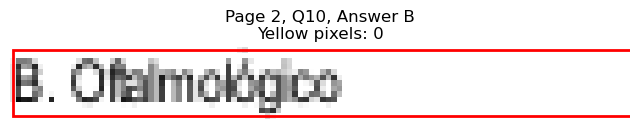

Page 2, Q10 - C: Detected box: x0=71.3, y0=748.4, x1=128.5, y1=760.4
Page 2, Q10, C: Yellow pixels: 484
Page 2, Q10, C: Total non-white pixels: 728
Page 2, Q10, C: Yellow percentage: 66.5%


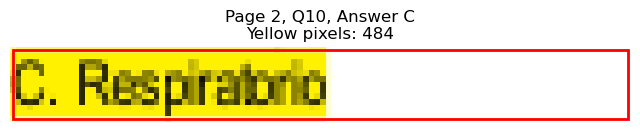

Page 2, Q10 - D: Detected box: x0=322.9, y0=724.3, x1=369.5, y1=736.4
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 216
Page 2, Q10, D: Yellow percentage: 0.0%


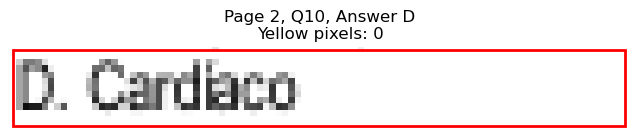

Page 2, Q10 - E: Detected box: x0=322.9, y0=736.4, x1=367.3, y1=748.4
Page 2, Q10, E: Yellow pixels: 0
Page 2, Q10, E: Total non-white pixels: 178
Page 2, Q10, E: Yellow percentage: 0.0%


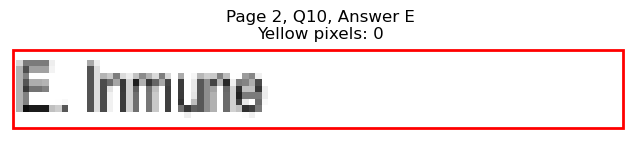


Page 2, Q10 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=122.5, y1=133.6
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 400
Page 3, Q1, A: Yellow percentage: 0.0%


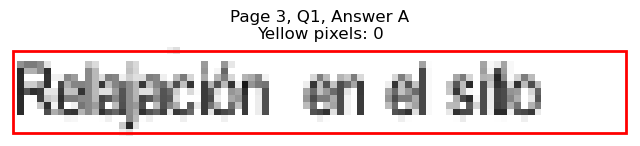

Page 3, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=115.7, y1=145.6
Page 3, Q1, B: Yellow pixels: 542
Page 3, Q1, B: Total non-white pixels: 897
Page 3, Q1, B: Yellow percentage: 60.4%


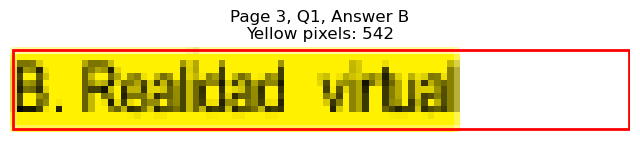

Page 3, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=133.0, y1=157.6
Page 3, Q1, C: Yellow pixels: 69
Page 3, Q1, C: Total non-white pixels: 347
Page 3, Q1, C: Yellow percentage: 19.9%


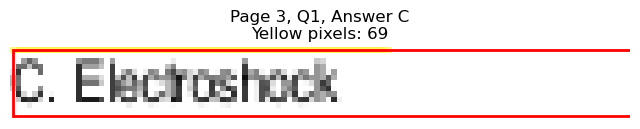

Page 3, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=399.5, y1=133.6
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 402
Page 3, Q1, D: Yellow percentage: 0.0%


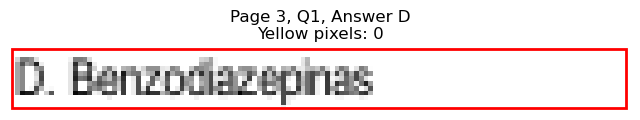

Page 3, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=424.3, y1=145.6
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 517
Page 3, Q1, E: Yellow percentage: 0.0%


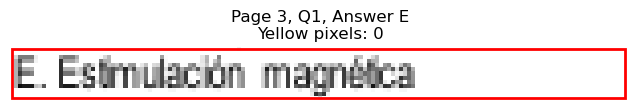


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=103.0, y1=205.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 90
Page 3, Q2, A: Yellow percentage: 0.0%


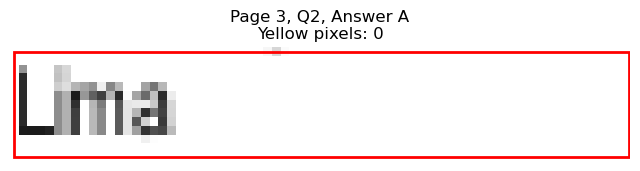

Page 3, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=139.7, y1=217.7
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 331
Page 3, Q2, B: Yellow percentage: 0.0%


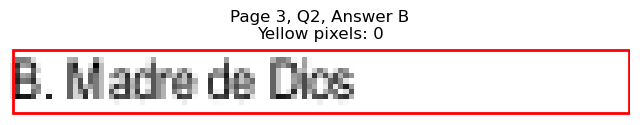

Page 3, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=122.5, y1=229.7
Page 3, Q2, C: Yellow pixels: 409
Page 3, Q2, C: Total non-white pixels: 650
Page 3, Q2, C: Yellow percentage: 62.9%


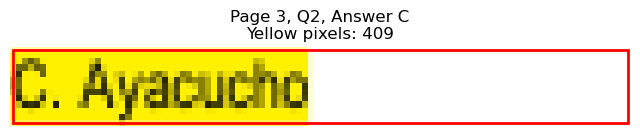

Page 3, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=377.0, y1=205.6
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 254
Page 3, Q2, D: Yellow percentage: 0.0%


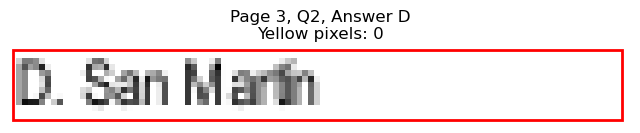

Page 3, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=376.3, y1=217.7
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 229
Page 3, Q2, E: Yellow percentage: 0.0%


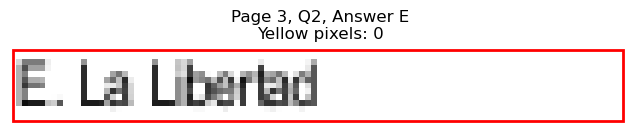


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.6, y0=265.7, x1=121.0, y1=277.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 202
Page 3, Q3, A: Yellow percentage: 0.0%


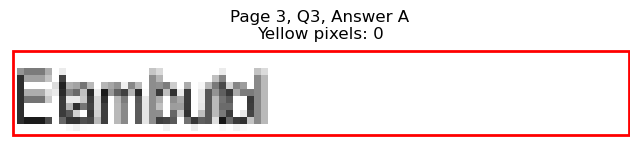

Page 3, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=127.7, y1=289.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 278
Page 3, Q3, B: Yellow percentage: 0.0%


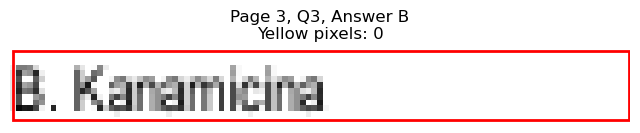

Page 3, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=125.5, y1=301.8
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 240
Page 3, Q3, C: Yellow percentage: 0.0%


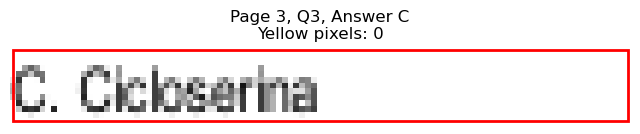

Page 3, Q3 - D: Detected box: x0=322.9, y0=265.7, x1=373.4, y1=277.7
Page 3, Q3, D: Yellow pixels: 383
Page 3, Q3, D: Total non-white pixels: 637
Page 3, Q3, D: Yellow percentage: 60.1%


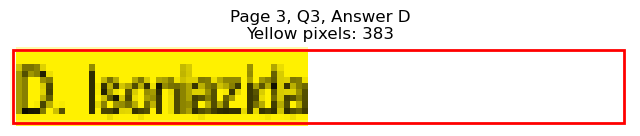

Page 3, Q3 - E: Detected box: x0=322.9, y0=277.7, x1=383.8, y1=289.7
Page 3, Q3, E: Yellow pixels: 48
Page 3, Q3, E: Total non-white pixels: 346
Page 3, Q3, E: Yellow percentage: 13.9%


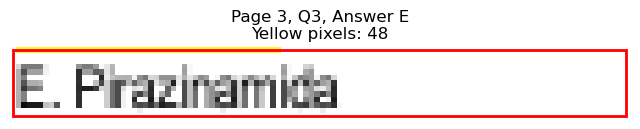


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=181.0, y1=338.5
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 471
Page 3, Q4, A: Yellow percentage: 0.0%


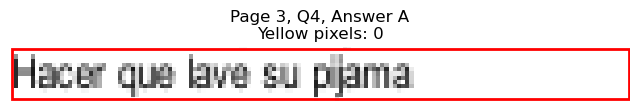

Page 3, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=195.2, y1=350.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 600
Page 3, Q4, B: Yellow percentage: 0.0%


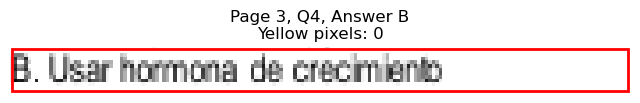

Page 3, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=172.7, y1=362.5
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 467
Page 3, Q4, C: Yellow percentage: 0.0%


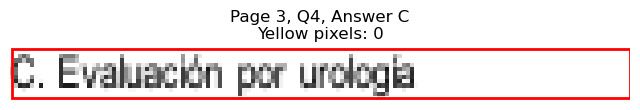

Page 3, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=419.2, y1=338.5
Page 3, Q4, D: Yellow pixels: 832
Page 3, Q4, D: Total non-white pixels: 1235
Page 3, Q4, D: Yellow percentage: 67.4%


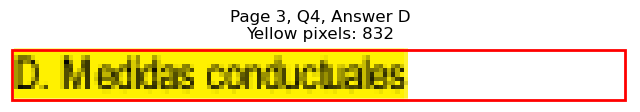

Page 3, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=378.5, y1=350.5
Page 3, Q4, E: Yellow pixels: 94
Page 3, Q4, E: Total non-white pixels: 529
Page 3, Q4, E: Yellow percentage: 17.8%


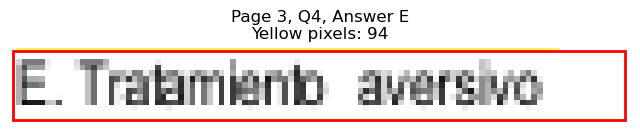


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=133.0, y1=398.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 261
Page 3, Q5, A: Yellow percentage: 0.0%


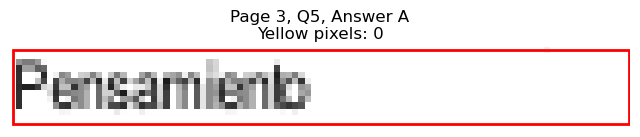

Page 3, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=115.0, y1=410.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 221
Page 3, Q5, B: Yellow percentage: 0.0%


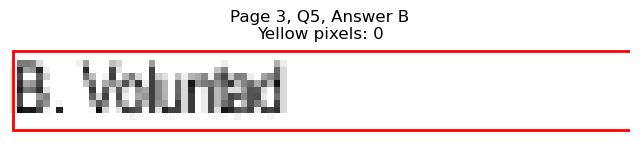

Page 3, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=125.5, y1=422.6
Page 3, Q5, C: Yellow pixels: 417
Page 3, Q5, C: Total non-white pixels: 689
Page 3, Q5, C: Yellow percentage: 60.5%


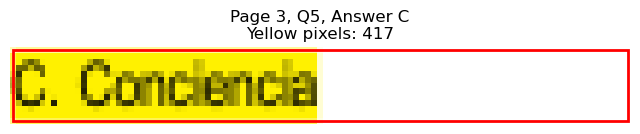

Page 3, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=378.5, y1=398.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 282
Page 3, Q5, D: Yellow percentage: 0.0%


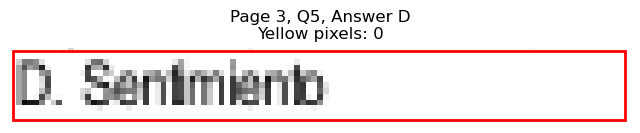

Page 3, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=377.8, y1=410.6
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 258
Page 3, Q5, E: Yellow percentage: 0.0%


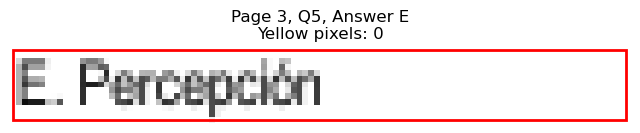


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.6, y0=483.4, x1=136.0, y1=495.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 259
Page 3, Q6, A: Yellow percentage: 0.0%


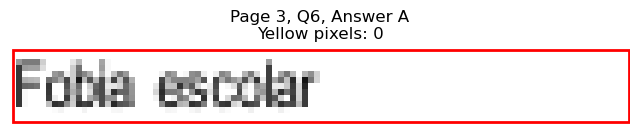

Page 3, Q6 - B: Detected box: x0=71.3, y0=495.4, x1=129.2, y1=507.4
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 282
Page 3, Q6, B: Yellow percentage: 0.0%


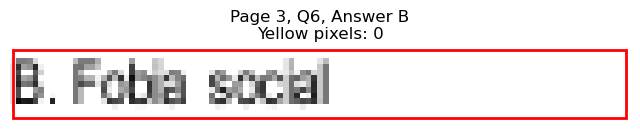

Page 3, Q6 - C: Detected box: x0=71.3, y0=507.4, x1=150.2, y1=519.4
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 362
Page 3, Q6, C: Yellow percentage: 0.0%


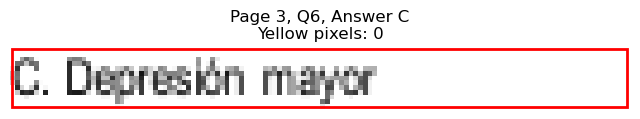

Page 3, Q6 - D: Detected box: x0=322.9, y0=483.4, x1=392.8, y1=495.4
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 350
Page 3, Q6, D: Yellow percentage: 0.0%


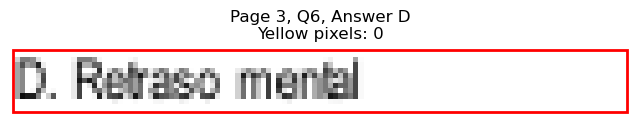

Page 3, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=429.7, y1=507.4
Page 3, Q6, E: Yellow pixels: 937
Page 3, Q6, E: Total non-white pixels: 1378
Page 3, Q6, E: Yellow percentage: 68.0%


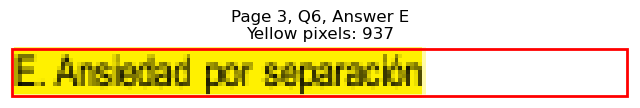


Page 3, Q6 - Selected Answer: E (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.6, y0=555.4, x1=227.7, y1=567.5
Page 3, Q7, A: Yellow pixels: 1251
Page 3, Q7, A: Total non-white pixels: 1872
Page 3, Q7, A: Yellow percentage: 66.8%


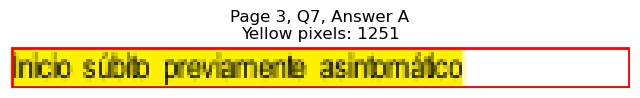

Page 3, Q7 - B: Detected box: x0=71.3, y0=567.5, x1=186.9, y1=579.5
Page 3, Q7, B: Yellow pixels: 142
Page 3, Q7, B: Total non-white pixels: 721
Page 3, Q7, B: Yellow percentage: 19.7%


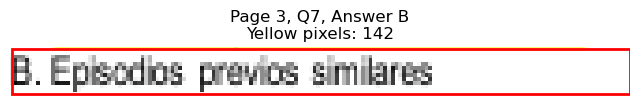

Page 3, Q7 - C: Detected box: x0=71.3, y0=579.4, x1=172.0, y1=591.5
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 485
Page 3, Q7, C: Yellow percentage: 0.0%


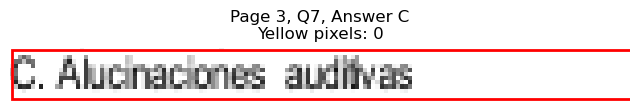

Page 3, Q7 - D: Detected box: x0=322.9, y0=555.4, x1=408.5, y1=567.5
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 417
Page 3, Q7, D: Yellow percentage: 0.0%


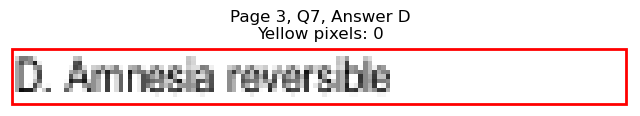

Page 3, Q7 - E: Detected box: x0=322.9, y0=567.5, x1=397.3, y1=579.5
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 618
Page 3, Q7, E: Yellow percentage: 0.0%


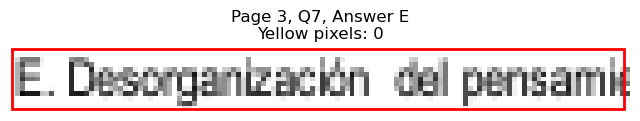


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.6, y0=639.5, x1=119.5, y1=651.6
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 184
Page 3, Q8, A: Yellow percentage: 0.0%


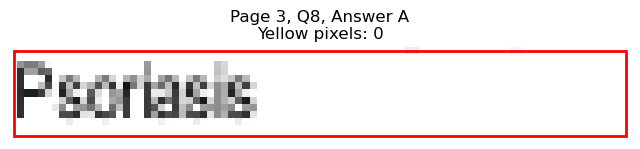

Page 3, Q8 - B: Detected box: x0=71.3, y0=651.5, x1=141.2, y1=663.6
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 342
Page 3, Q8, B: Yellow percentage: 0.0%


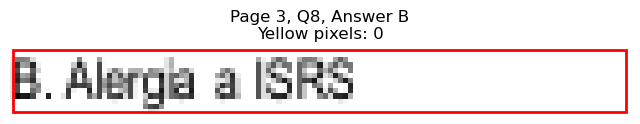

Page 3, Q8 - C: Detected box: x0=71.3, y0=663.5, x1=109.0, y1=675.6
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 151
Page 3, Q8, C: Yellow percentage: 0.0%


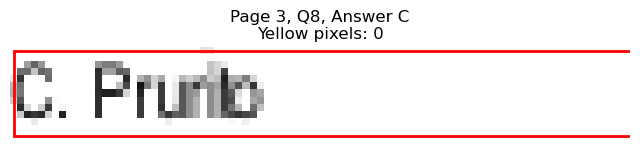

Page 3, Q8 - D: Detected box: x0=322.9, y0=639.5, x1=414.7, y1=651.6
Page 3, Q8, D: Yellow pixels: 777
Page 3, Q8, D: Total non-white pixels: 1183
Page 3, Q8, D: Yellow percentage: 65.7%


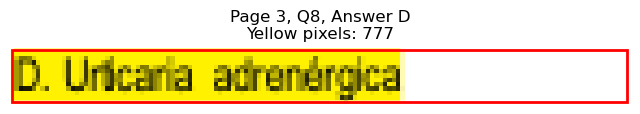

Page 3, Q8 - E: Detected box: x0=322.9, y0=651.5, x1=364.2, y1=663.6
Page 3, Q8, E: Yellow pixels: 89
Page 3, Q8, E: Total non-white pixels: 290
Page 3, Q8, E: Yellow percentage: 30.7%


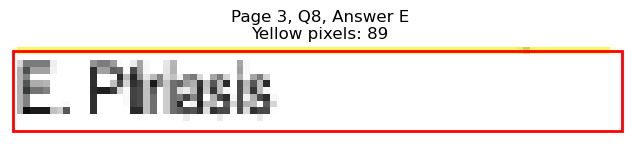


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=121.0, y1=712.3
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 187
Page 3, Q9, A: Yellow percentage: 0.0%


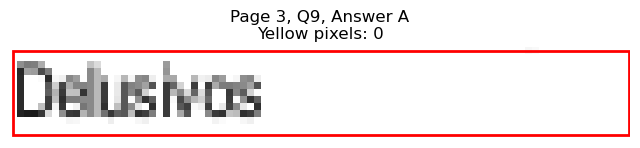

Page 3, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=130.7, y1=724.4
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 302
Page 3, Q9, B: Yellow percentage: 0.0%


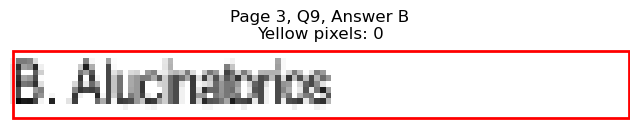

Page 3, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=127.0, y1=736.4
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 263
Page 3, Q9, C: Yellow percentage: 0.0%


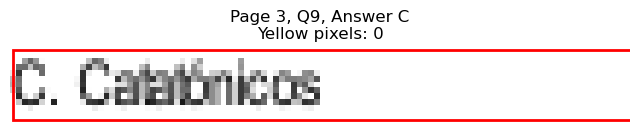

Page 3, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=376.3, y1=712.3
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 254
Page 3, Q9, D: Yellow percentage: 0.0%


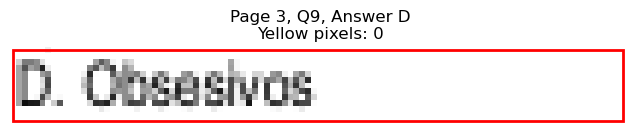

Page 3, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=377.9, y1=724.4
Page 3, Q9, E: Yellow pixels: 413
Page 3, Q9, E: Total non-white pixels: 702
Page 3, Q9, E: Yellow percentage: 58.8%


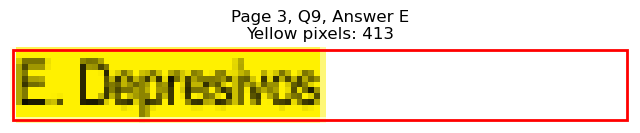


Page 3, Q9 - Selected Answer: E (based on yellow pixel count)





Page 4: Found 8 questions
Page 4, Q1 - A: Detected box: x0=82.6, y0=133.5, x1=170.5, y1=145.6
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 452
Page 4, Q1, A: Yellow percentage: 0.0%


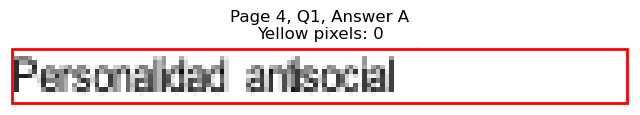

Page 4, Q1 - B: Detected box: x0=71.3, y0=145.6, x1=118.8, y1=157.6
Page 4, Q1, B: Yellow pixels: 349
Page 4, Q1, B: Total non-white pixels: 598
Page 4, Q1, B: Yellow percentage: 58.4%


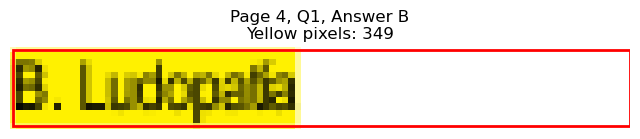

Page 4, Q1 - C: Detected box: x0=71.3, y0=157.6, x1=150.2, y1=169.6
Page 4, Q1, C: Yellow pixels: 45
Page 4, Q1, C: Total non-white pixels: 408
Page 4, Q1, C: Yellow percentage: 11.0%


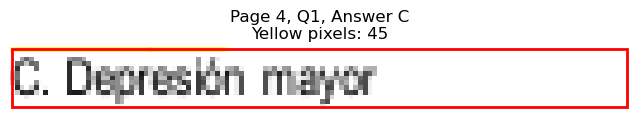

Page 4, Q1 - D: Detected box: x0=322.9, y0=133.5, x1=368.1, y1=145.6
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 216
Page 4, Q1, D: Yellow percentage: 0.0%


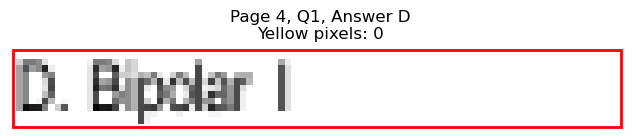

Page 4, Q1 - E: Detected box: x0=322.9, y0=145.6, x1=384.5, y1=157.6
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 528
Page 4, Q1, E: Yellow percentage: 0.0%


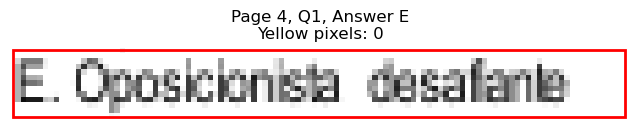


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.6, y0=229.6, x1=169.8, y1=241.7
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 464
Page 4, Q2, A: Yellow percentage: 0.0%


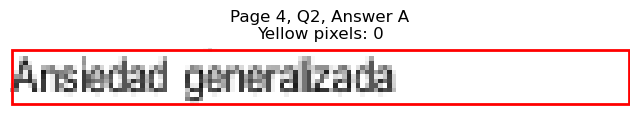

Page 4, Q2 - B: Detected box: x0=71.3, y0=241.6, x1=169.7, y1=253.7
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 496
Page 4, Q2, B: Yellow percentage: 0.0%


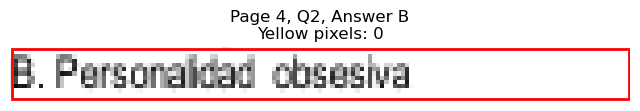

Page 4, Q2 - C: Detected box: x0=71.3, y0=253.6, x1=176.5, y1=265.7
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 524
Page 4, Q2, C: Yellow percentage: 0.0%


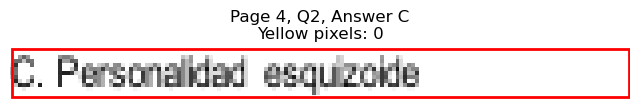

Page 4, Q2 - D: Detected box: x0=322.9, y0=229.6, x1=365.1, y1=241.7
Page 4, Q2, D: Yellow pixels: 314
Page 4, Q2, D: Total non-white pixels: 533
Page 4, Q2, D: Yellow percentage: 58.9%


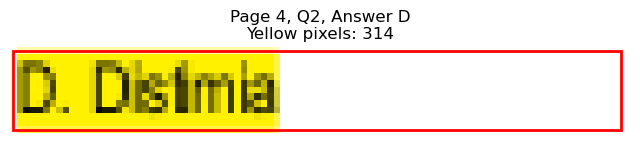

Page 4, Q2 - E: Detected box: x0=322.9, y0=241.6, x1=380.8, y1=253.7
Page 4, Q2, E: Yellow pixels: 40
Page 4, Q2, E: Total non-white pixels: 319
Page 4, Q2, E: Yellow percentage: 12.5%


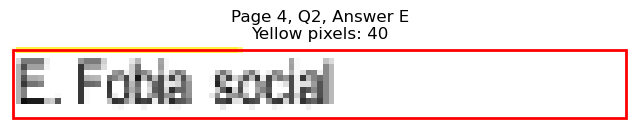


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.6, y0=314.5, x1=127.0, y1=326.5
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 219
Page 4, Q3, A: Yellow percentage: 0.0%


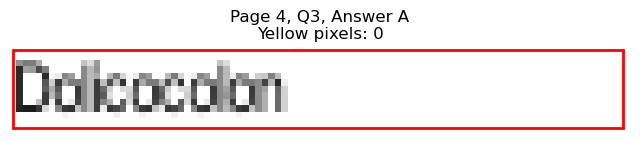

Page 4, Q3 - B: Detected box: x0=71.3, y0=326.5, x1=157.8, y1=338.5
Page 4, Q3, B: Yellow pixels: 774
Page 4, Q3, B: Total non-white pixels: 1105
Page 4, Q3, B: Yellow percentage: 70.0%


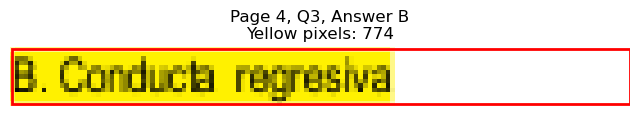

Page 4, Q3 - C: Detected box: x0=71.3, y0=338.5, x1=163.8, y1=350.5
Page 4, Q3, C: Yellow pixels: 84
Page 4, Q3, C: Total non-white pixels: 522
Page 4, Q3, C: Yellow percentage: 16.1%


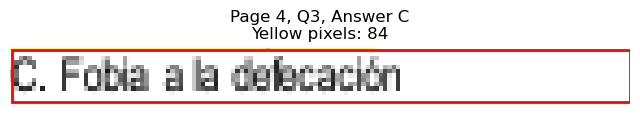

Page 4, Q3 - D: Detected box: x0=322.9, y0=314.5, x1=377.8, y1=326.5
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 256
Page 4, Q3, D: Yellow percentage: 0.0%


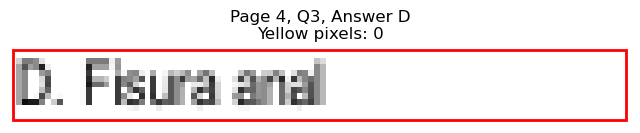

Page 4, Q3 - E: Detected box: x0=322.9, y0=326.5, x1=382.3, y1=338.5
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 297
Page 4, Q3, E: Yellow percentage: 0.0%


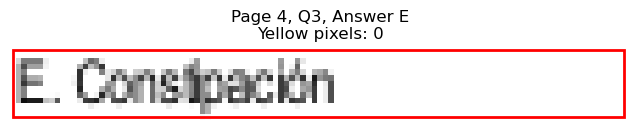


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.6, y0=374.5, x1=142.8, y1=386.6
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 299
Page 4, Q4, A: Yellow percentage: 0.0%


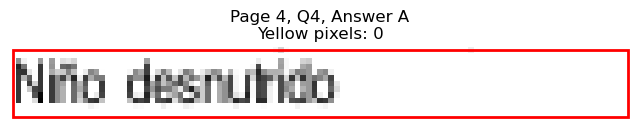

Page 4, Q4 - B: Detected box: x0=71.3, y0=386.5, x1=153.2, y1=398.6
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 375
Page 4, Q4, B: Yellow percentage: 0.0%


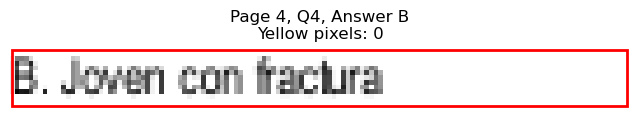

Page 4, Q4 - C: Detected box: x0=71.3, y0=398.5, x1=166.1, y1=410.6
Page 4, Q4, C: Yellow pixels: 844
Page 4, Q4, C: Total non-white pixels: 1209
Page 4, Q4, C: Yellow percentage: 69.8%


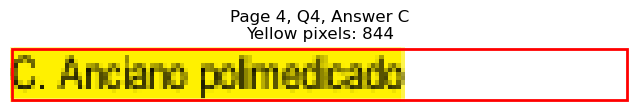

Page 4, Q4 - D: Detected box: x0=322.9, y0=374.5, x1=402.5, y1=386.6
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 380
Page 4, Q4, D: Yellow percentage: 0.0%


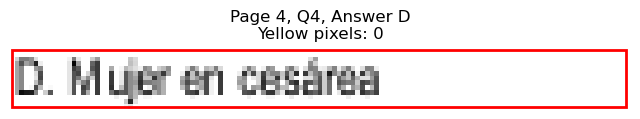

Page 4, Q4 - E: Detected box: x0=322.9, y0=386.5, x1=414.5, y1=398.6
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 417
Page 4, Q4, E: Yellow percentage: 0.0%


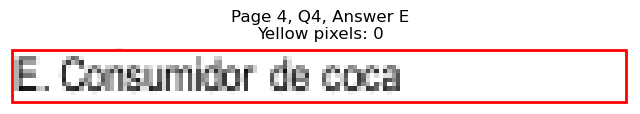


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.6, y0=434.6, x1=153.2, y1=446.6
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 338
Page 4, Q5, A: Yellow percentage: 0.0%


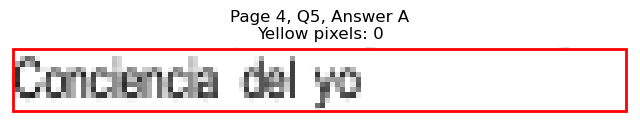

Page 4, Q5 - B: Detected box: x0=71.3, y0=446.6, x1=166.1, y1=458.6
Page 4, Q5, B: Yellow pixels: 747
Page 4, Q5, B: Total non-white pixels: 1209
Page 4, Q5, B: Yellow percentage: 61.8%


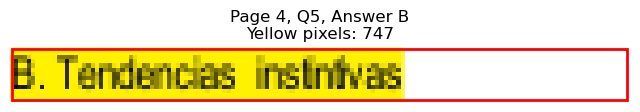

Page 4, Q5 - C: Detected box: x0=71.3, y0=458.6, x1=115.8, y1=470.6
Page 4, Q5, C: Yellow pixels: 93
Page 4, Q5, C: Total non-white pixels: 294
Page 4, Q5, C: Yellow percentage: 31.6%


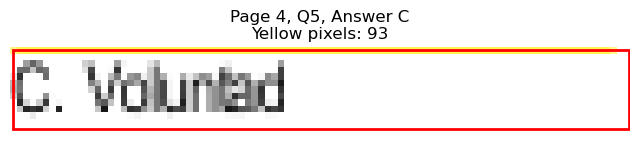

Page 4, Q5 - D: Detected box: x0=322.9, y0=434.6, x1=378.5, y1=446.6
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 278
Page 4, Q5, D: Yellow percentage: 0.0%


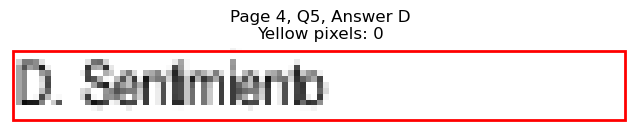

Page 4, Q5 - E: Detected box: x0=322.9, y0=446.6, x1=383.8, y1=458.6
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 286
Page 4, Q5, E: Yellow percentage: 0.0%


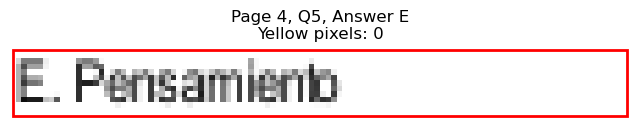


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.6, y0=519.4, x1=233.5, y1=531.4
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 693
Page 4, Q6, A: Yellow percentage: 0.0%


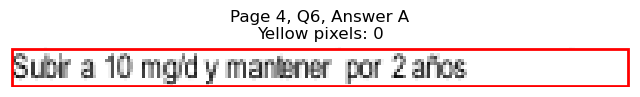

Page 4, Q6 - B: Detected box: x0=71.3, y0=531.4, x1=210.9, y1=543.5
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 679
Page 4, Q6, B: Yellow percentage: 0.0%


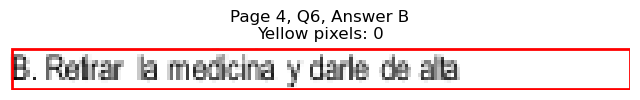

Page 4, Q6 - C: Detected box: x0=71.3, y0=543.4, x1=238.9, y1=555.5
Page 4, Q6, C: Yellow pixels: 1515
Page 4, Q6, C: Total non-white pixels: 2158
Page 4, Q6, C: Yellow percentage: 70.2%


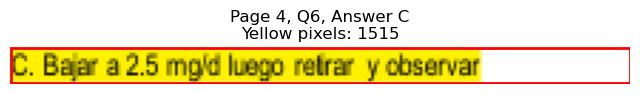

Page 4, Q6 - D: Detected box: x0=322.9, y0=519.4, x1=405.6, y1=531.4
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 645
Page 4, Q6, D: Yellow percentage: 0.0%


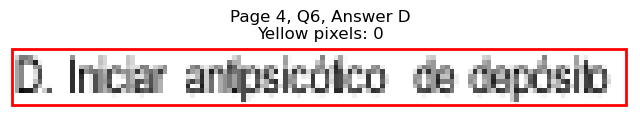

Page 4, Q6 - E: Detected box: x0=322.9, y0=531.4, x1=494.7, y1=543.5
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 832
Page 4, Q6, E: Yellow percentage: 0.0%


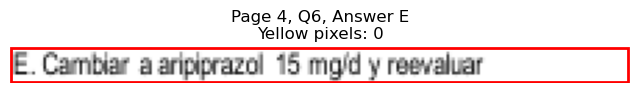


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.6, y0=615.5, x1=121.0, y1=627.5
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 196
Page 4, Q7, A: Yellow percentage: 0.0%


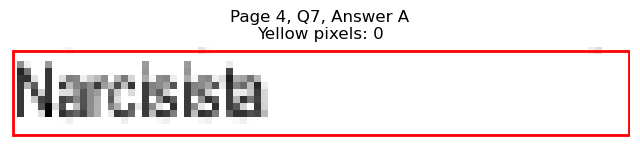

Page 4, Q7 - B: Detected box: x0=71.3, y0=627.5, x1=129.3, y1=639.6
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 308
Page 4, Q7, B: Yellow percentage: 0.0%


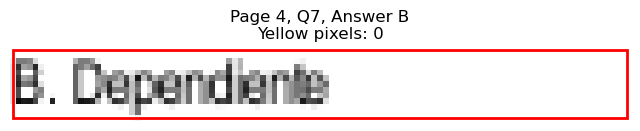

Page 4, Q7 - C: Detected box: x0=71.3, y0=639.5, x1=119.5, y1=651.6
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 215
Page 4, Q7, C: Yellow percentage: 0.0%


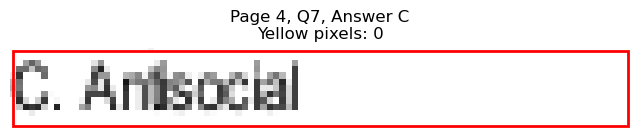

Page 4, Q7 - D: Detected box: x0=322.9, y0=615.5, x1=374.0, y1=627.5
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 260
Page 4, Q7, D: Yellow percentage: 0.0%


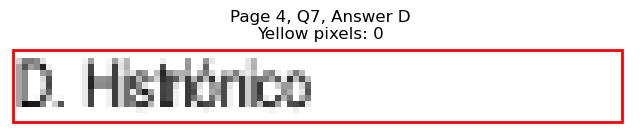

Page 4, Q7 - E: Detected box: x0=322.9, y0=627.5, x1=371.1, y1=639.6
Page 4, Q7, E: Yellow pixels: 403
Page 4, Q7, E: Total non-white pixels: 611
Page 4, Q7, E: Yellow percentage: 66.0%


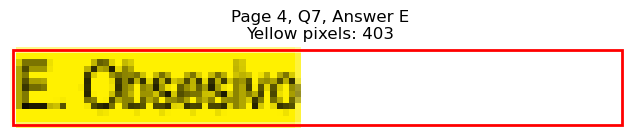


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.6, y0=688.3, x1=115.0, y1=700.3
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 163
Page 4, Q8, A: Yellow percentage: 0.0%


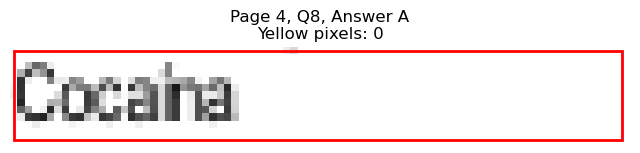

Page 4, Q8 - B: Detected box: x0=71.3, y0=700.3, x1=124.0, y1=712.3
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 260
Page 4, Q8, B: Yellow percentage: 0.0%


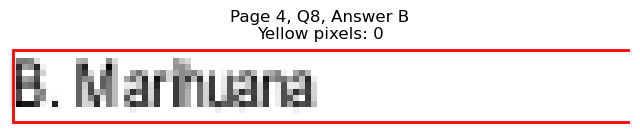

Page 4, Q8 - C: Detected box: x0=71.3, y0=712.3, x1=112.0, y1=724.4
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 174
Page 4, Q8, C: Yellow percentage: 0.0%


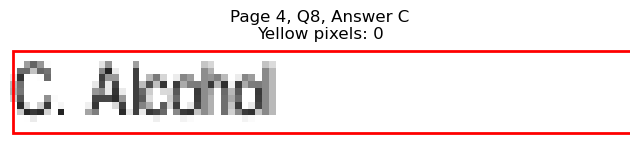

Page 4, Q8 - D: Detected box: x0=322.9, y0=688.3, x1=395.0, y1=700.3
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 381
Page 4, Q8, D: Yellow percentage: 0.0%


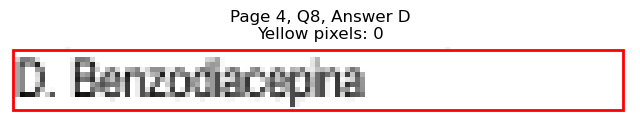

Page 4, Q8 - E: Detected box: x0=322.9, y0=700.3, x1=362.8, y1=712.3
Page 4, Q8, E: Yellow pixels: 296
Page 4, Q8, E: Total non-white pixels: 508
Page 4, Q8, E: Yellow percentage: 58.3%


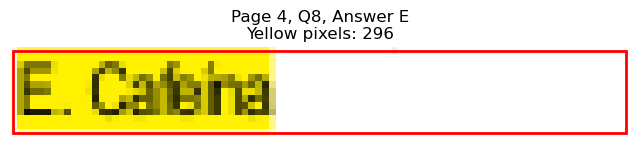


Page 4, Q8 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=82.6, y0=133.5, x1=201.3, y1=145.6
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 610
Page 5, Q1, A: Yellow percentage: 0.0%


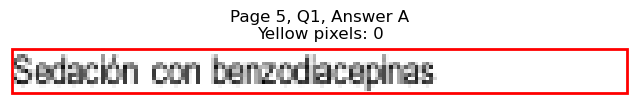

Page 5, Q1 - B: Detected box: x0=71.3, y0=145.6, x1=155.5, y1=157.6
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 415
Page 5, Q1, B: Yellow percentage: 0.0%


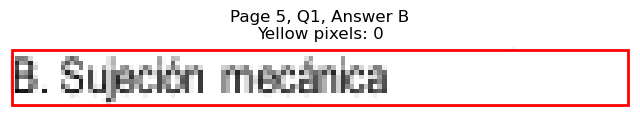

Page 5, Q1 - C: Detected box: x0=71.3, y0=157.6, x1=139.0, y1=169.6
Page 5, Q1, C: Yellow pixels: 920
Page 5, Q1, C: Total non-white pixels: 1521
Page 5, Q1, C: Yellow percentage: 60.5%


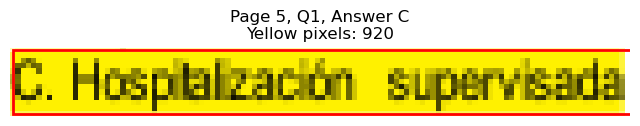

Page 5, Q1 - D: Detected box: x0=322.9, y0=133.5, x1=426.5, y1=145.6
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 497
Page 5, Q1, D: Yellow percentage: 0.0%


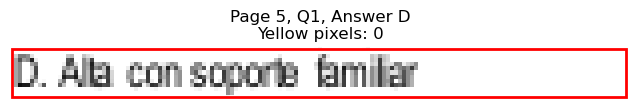

Page 5, Q1 - E: Detected box: x0=322.9, y0=145.6, x1=419.8, y1=157.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 466
Page 5, Q1, E: Yellow percentage: 0.0%


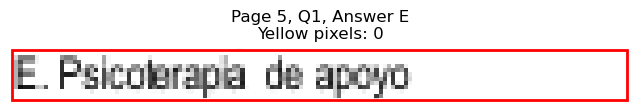


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.6, y0=205.6, x1=118.8, y1=217.7
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 195
Page 5, Q2, A: Yellow percentage: 0.0%


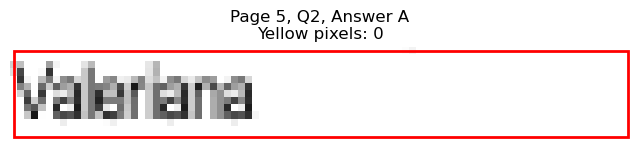

Page 5, Q2 - B: Detected box: x0=71.3, y0=217.6, x1=124.0, y1=229.7
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 267
Page 5, Q2, B: Yellow percentage: 0.0%


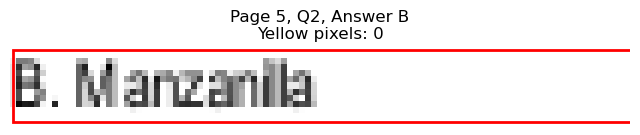

Page 5, Q2 - C: Detected box: x0=71.3, y0=229.6, x1=111.2, y1=241.7
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 189
Page 5, Q2, C: Yellow percentage: 0.0%


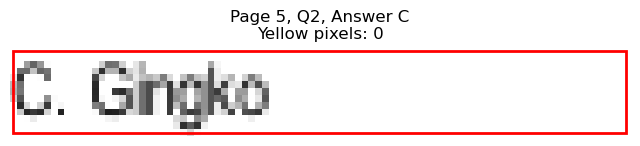

Page 5, Q2 - D: Detected box: x0=322.9, y0=205.6, x1=366.5, y1=217.7
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 220
Page 5, Q2, D: Yellow percentage: 0.0%


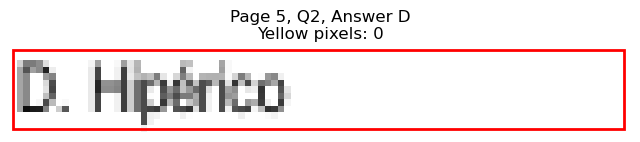

Page 5, Q2 - E: Detected box: x0=322.9, y0=217.6, x1=366.6, y1=229.7
Page 5, Q2, E: Yellow pixels: 314
Page 5, Q2, E: Total non-white pixels: 559
Page 5, Q2, E: Yellow percentage: 56.2%


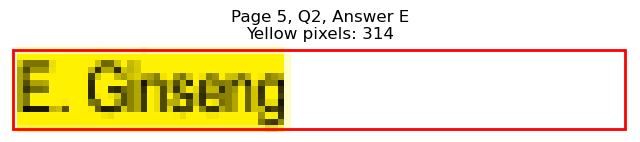


Page 5, Q2 - Selected Answer: E (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.6, y0=277.7, x1=131.5, y1=289.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 240
Page 5, Q3, A: Yellow percentage: 0.0%


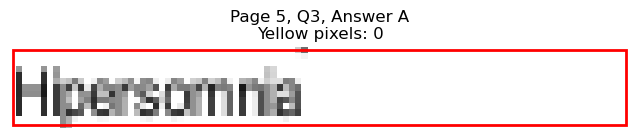

Page 5, Q3 - B: Detected box: x0=71.3, y0=289.7, x1=111.3, y1=301.8
Page 5, Q3, B: Yellow pixels: 293
Page 5, Q3, B: Total non-white pixels: 494
Page 5, Q3, B: Yellow percentage: 59.3%


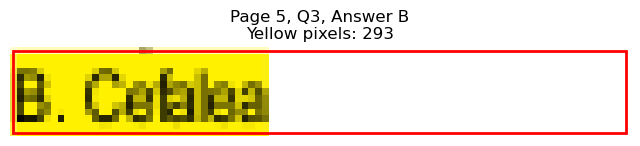

Page 5, Q3 - C: Detected box: x0=71.3, y0=302.5, x1=121.0, y1=314.5
Page 5, Q3, C: Yellow pixels: 37
Page 5, Q3, C: Total non-white pixels: 281
Page 5, Q3, C: Yellow percentage: 13.2%


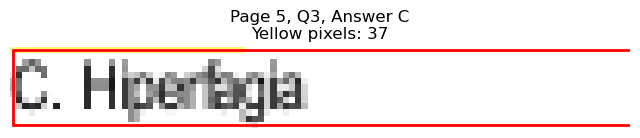

Page 5, Q3 - D: Detected box: x0=322.9, y0=277.7, x1=378.6, y1=289.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 287
Page 5, Q3, D: Yellow percentage: 0.0%


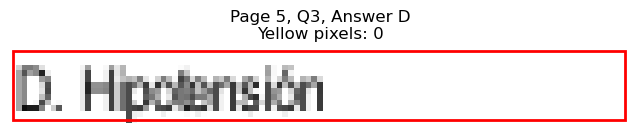

Page 5, Q3 - E: Detected box: x0=322.9, y0=289.7, x1=377.8, y1=301.8
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 282
Page 5, Q3, E: Yellow percentage: 0.0%


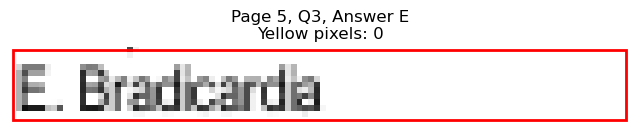


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=118.7, y1=362.5
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 180
Page 5, Q4, A: Yellow percentage: 0.0%


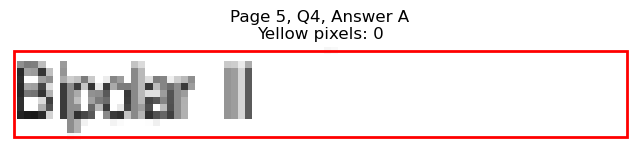

Page 5, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=141.9, y1=374.6
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 342
Page 5, Q4, B: Yellow percentage: 0.0%


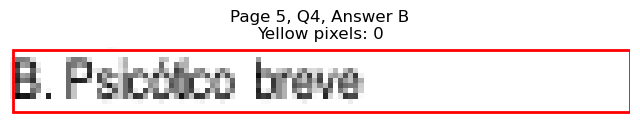

Page 5, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=142.1, y1=386.6
Page 5, Q4, C: Yellow pixels: 613
Page 5, Q4, C: Total non-white pixels: 897
Page 5, Q4, C: Yellow percentage: 68.3%


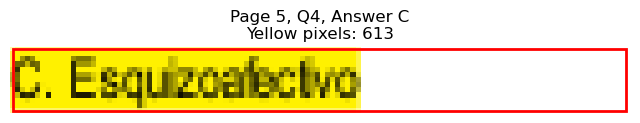

Page 5, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=366.5, y1=362.5
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 203
Page 5, Q4, D: Yellow percentage: 0.0%


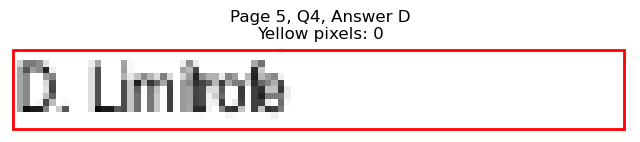

Page 5, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=374.8, y1=374.6
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 256
Page 5, Q4, E: Yellow percentage: 0.0%


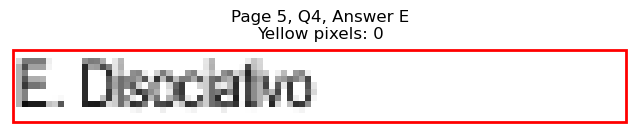


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.6, y0=422.5, x1=112.0, y1=434.6
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 145
Page 5, Q5, A: Yellow percentage: 0.0%


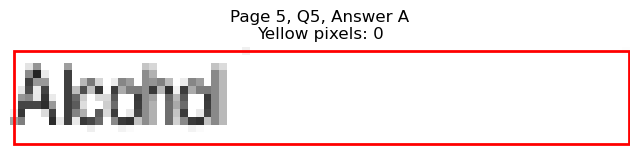

Page 5, Q5 - B: Detected box: x0=71.3, y0=434.6, x1=112.7, y1=446.6
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 209
Page 5, Q5, B: Yellow percentage: 0.0%


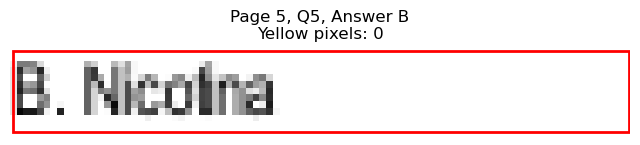

Page 5, Q5 - C: Detected box: x0=71.3, y0=446.6, x1=120.2, y1=458.6
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 231
Page 5, Q5, C: Yellow percentage: 0.0%


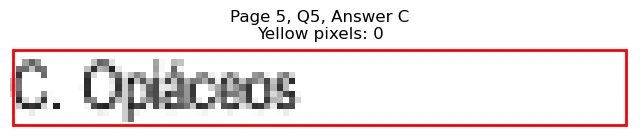

Page 5, Q5 - D: Detected box: x0=322.9, y0=422.5, x1=376.3, y1=434.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 262
Page 5, Q5, D: Yellow percentage: 0.0%


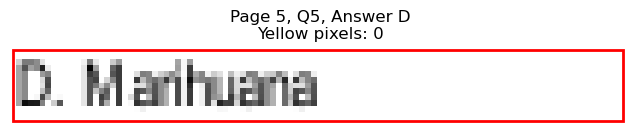

Page 5, Q5 - E: Detected box: x0=322.9, y0=434.6, x1=398.9, y1=446.6
Page 5, Q5, E: Yellow pixels: 558
Page 5, Q5, E: Total non-white pixels: 975
Page 5, Q5, E: Yellow percentage: 57.2%


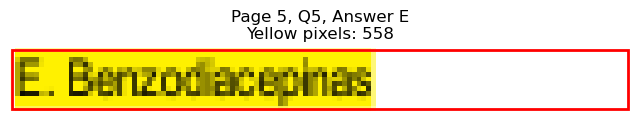


Page 5, Q5 - Selected Answer: E (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=130.0, y1=507.4
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 227
Page 5, Q6, A: Yellow percentage: 0.0%


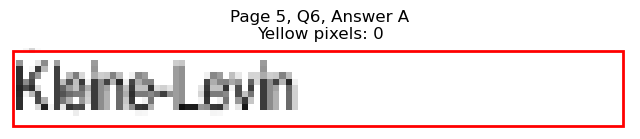

Page 5, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=127.0, y1=519.4
Page 5, Q6, B: Yellow pixels: 471
Page 5, Q6, B: Total non-white pixels: 702
Page 5, Q6, B: Yellow percentage: 67.1%


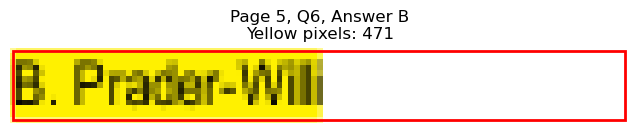

Page 5, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=130.0, y1=531.4
Page 5, Q6, C: Yellow pixels: 52
Page 5, Q6, C: Total non-white pixels: 295
Page 5, Q6, C: Yellow percentage: 17.6%


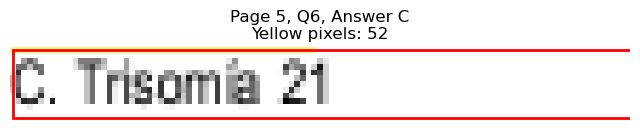

Page 5, Q6 - D: Detected box: x0=322.9, y0=495.4, x1=361.3, y1=507.4
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 161
Page 5, Q6, D: Yellow percentage: 0.0%


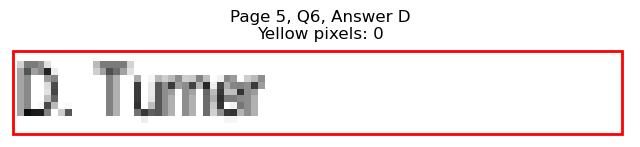

Page 5, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=386.8, y1=519.4
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 331
Page 5, Q6, E: Yellow percentage: 0.0%


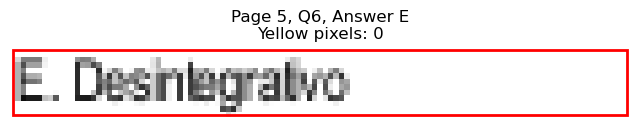


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=128.4, y0=567.5, x1=193.7, y1=579.5
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 296
Page 5, Q7, A: Yellow percentage: 0.0%


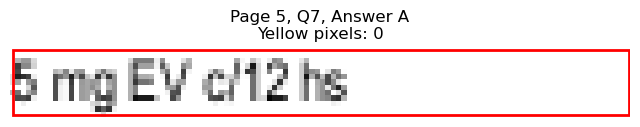

Page 5, Q7 - B: Detected box: x0=127.6, y0=579.4, x1=202.9, y1=591.5
Page 5, Q7, B: Yellow pixels: 688
Page 5, Q7, B: Total non-white pixels: 962
Page 5, Q7, B: Yellow percentage: 71.5%


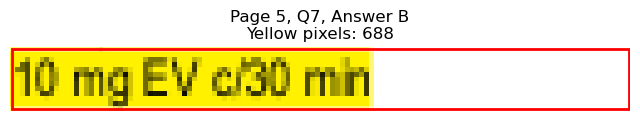

Page 5, Q7 - C: Detected box: x0=71.3, y0=591.5, x1=189.2, y1=603.5
Page 5, Q7, C: Yellow pixels: 128
Page 5, Q7, C: Total non-white pixels: 654
Page 5, Q7, C: Yellow percentage: 19.6%


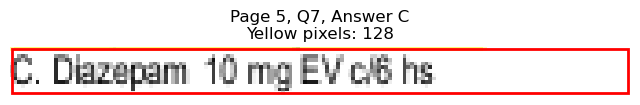

Page 5, Q7 - D: Detected box: x0=322.9, y0=567.5, x1=441.5, y1=579.5
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 559
Page 5, Q7, D: Yellow percentage: 0.0%


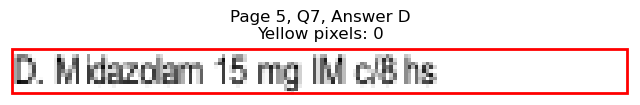

Page 5, Q7 - E: Detected box: x0=322.9, y0=579.4, x1=407.0, y1=591.5
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 419
Page 5, Q7, E: Yellow percentage: 0.0%


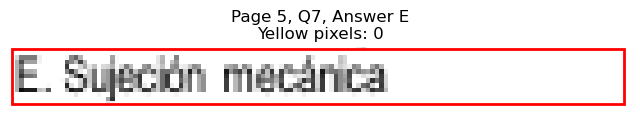


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.6, y0=639.5, x1=112.8, y1=651.6
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 141
Page 5, Q8, A: Yellow percentage: 0.0%


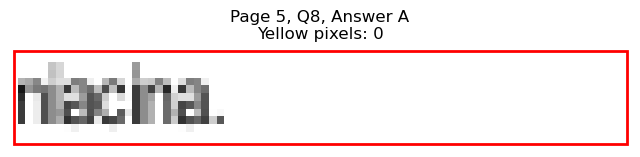

Page 5, Q8 - B: Detected box: x0=71.3, y0=651.5, x1=112.0, y1=663.6
Page 5, Q8, B: Yellow pixels: 354
Page 5, Q8, B: Total non-white pixels: 507
Page 5, Q8, B: Yellow percentage: 69.8%


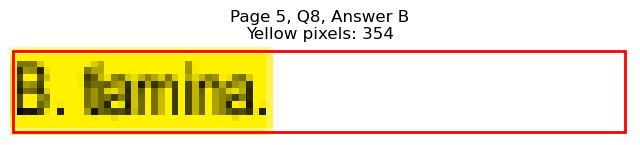

Page 5, Q8 - C: Detected box: x0=71.3, y0=663.5, x1=123.2, y1=675.6
Page 5, Q8, C: Yellow pixels: 39
Page 5, Q8, C: Total non-white pixels: 265
Page 5, Q8, C: Yellow percentage: 14.7%


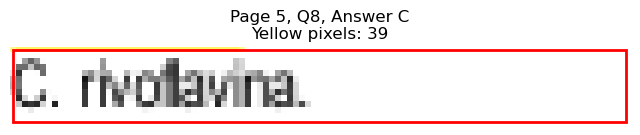

Page 5, Q8 - D: Detected box: x0=322.9, y0=639.5, x1=400.3, y1=651.6
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 389
Page 5, Q8, D: Yellow percentage: 0.0%


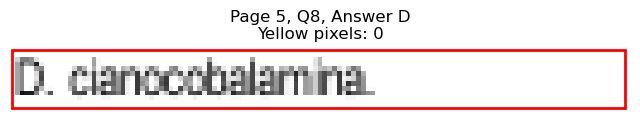

Page 5, Q8 - E: Detected box: x0=322.9, y0=651.5, x1=372.5, y1=663.6
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 227
Page 5, Q8, E: Yellow percentage: 0.0%


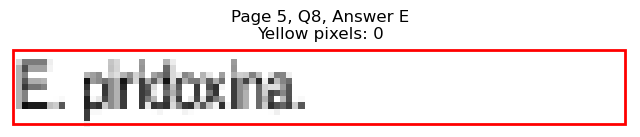


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=130.0, y1=712.3
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 254
Page 5, Q9, A: Yellow percentage: 0.0%


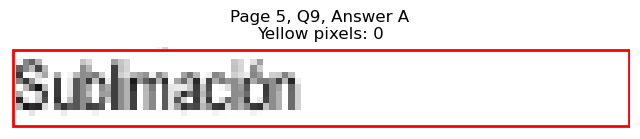

Page 5, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=109.7, y1=724.4
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 184
Page 5, Q9, B: Yellow percentage: 0.0%


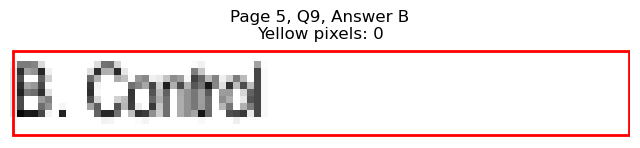

Page 5, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=127.8, y1=736.4
Page 5, Q9, C: Yellow pixels: 431
Page 5, Q9, C: Total non-white pixels: 715
Page 5, Q9, C: Yellow percentage: 60.3%


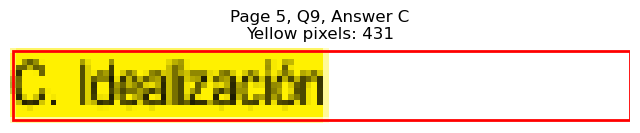

Page 5, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=393.5, y1=712.3
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 374
Page 5, Q9, D: Yellow percentage: 0.0%


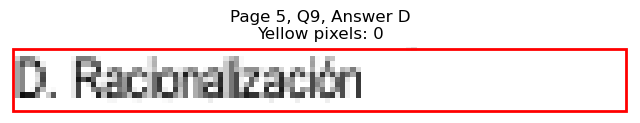

Page 5, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=358.7, y1=724.4
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 157
Page 5, Q9, E: Yellow percentage: 0.0%


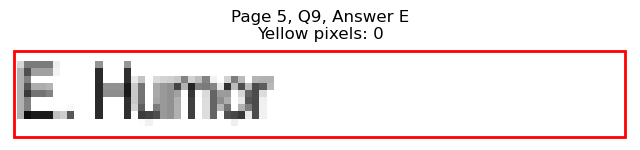


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 8 questions
Page 6, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=130.7, y1=108.8
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 229
Page 6, Q1, A: Yellow percentage: 0.0%


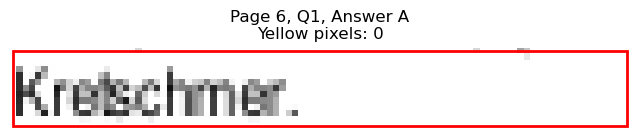

Page 6, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=111.2, y1=121.6
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 181
Page 6, Q1, B: Yellow percentage: 0.0%


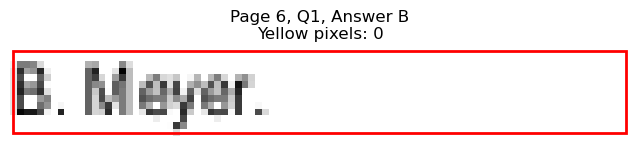

Page 6, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=112.8, y1=133.6
Page 6, Q1, C: Yellow pixels: 352
Page 6, Q1, C: Total non-white pixels: 520
Page 6, Q1, C: Yellow percentage: 67.7%


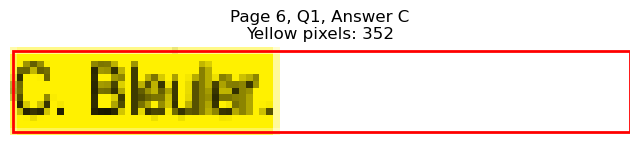

Page 6, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=356.8, y1=108.8
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 132
Page 6, Q1, D: Yellow percentage: 0.0%


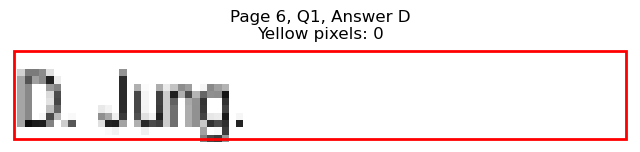

Page 6, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=357.5, y1=121.6
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 153
Page 6, Q1, E: Yellow percentage: 0.0%


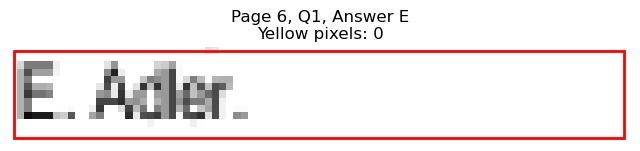


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=133.1, y1=181.6
Page 6, Q2, A: Yellow pixels: 361
Page 6, Q2, A: Total non-white pixels: 638
Page 6, Q2, A: Yellow percentage: 56.6%


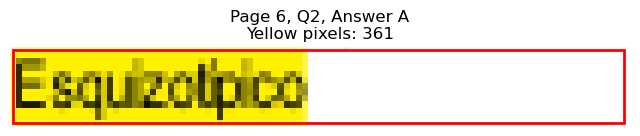

Page 6, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=121.7, y1=193.6
Page 6, Q2, B: Yellow pixels: 48
Page 6, Q2, B: Total non-white pixels: 301
Page 6, Q2, B: Yellow percentage: 15.9%


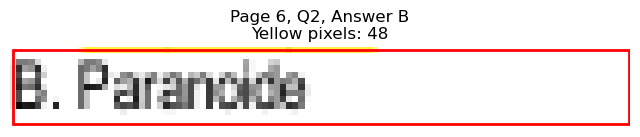

Page 6, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=125.5, y1=205.6
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 258
Page 6, Q2, C: Yellow percentage: 0.0%


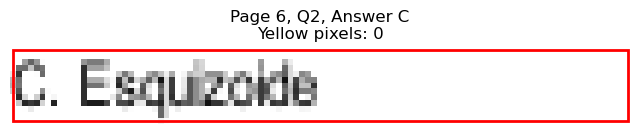

Page 6, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=371.0, y1=181.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 244
Page 6, Q2, D: Yellow percentage: 0.0%


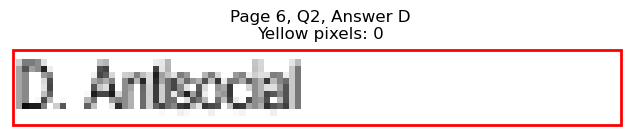

Page 6, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=365.8, y1=193.6
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 196
Page 6, Q2, E: Yellow percentage: 0.0%


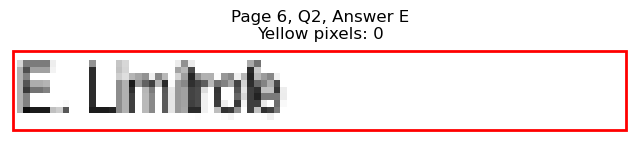


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.6, y0=265.7, x1=184.0, y1=277.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 508
Page 6, Q3, A: Yellow percentage: 0.0%


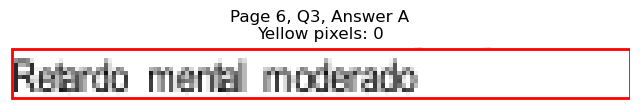

Page 6, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=160.7, y1=289.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 433
Page 6, Q3, B: Yellow percentage: 0.0%


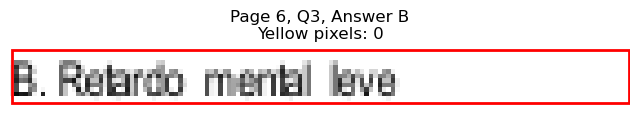

Page 6, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=125.5, y1=301.8
Page 6, Q3, C: Yellow pixels: 414
Page 6, Q3, C: Total non-white pixels: 689
Page 6, Q3, C: Yellow percentage: 60.1%


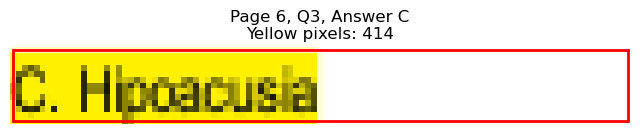

Page 6, Q3 - D: Detected box: x0=322.9, y0=265.7, x1=411.5, y1=277.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 430
Page 6, Q3, D: Yellow percentage: 0.0%


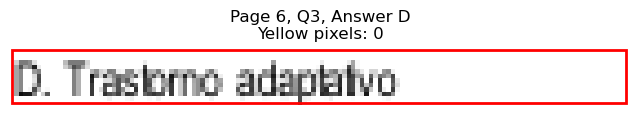

Page 6, Q3 - E: Detected box: x0=322.9, y0=277.7, x1=416.8, y1=289.7
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 457
Page 6, Q3, E: Yellow percentage: 0.0%


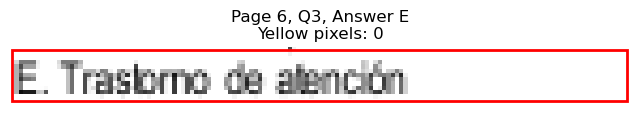


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.6, y0=362.5, x1=175.7, y1=374.6
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 445
Page 6, Q4, A: Yellow percentage: 0.0%


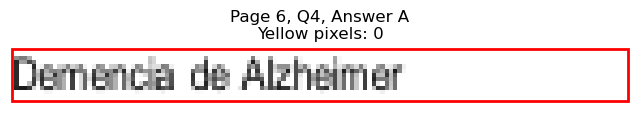

Page 6, Q4 - B: Detected box: x0=71.3, y0=374.5, x1=171.2, y1=386.6
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 503
Page 6, Q4, B: Yellow percentage: 0.0%


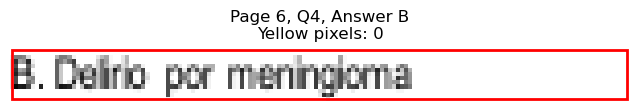

Page 6, Q4 - C: Detected box: x0=71.3, y0=386.5, x1=200.4, y1=398.6
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 619
Page 6, Q4, C: Yellow percentage: 0.0%


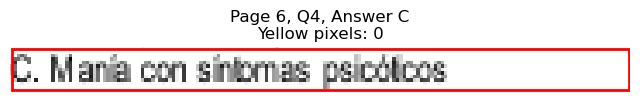

Page 6, Q4 - D: Detected box: x0=322.9, y0=362.5, x1=430.4, y1=374.6
Page 6, Q4, D: Yellow pixels: 957
Page 6, Q4, D: Total non-white pixels: 1391
Page 6, Q4, D: Yellow percentage: 68.8%


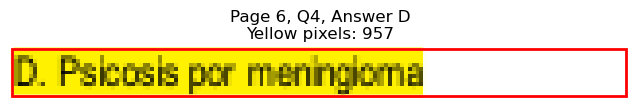

Page 6, Q4 - E: Detected box: x0=322.9, y0=374.5, x1=467.0, y1=386.6
Page 6, Q4, E: Yellow pixels: 105
Page 6, Q4, E: Total non-white pixels: 794
Page 6, Q4, E: Yellow percentage: 13.2%


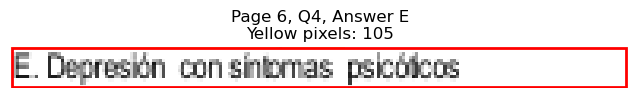


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.6, y0=470.6, x1=157.0, y1=482.6
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 394
Page 6, Q5, A: Yellow percentage: 0.0%


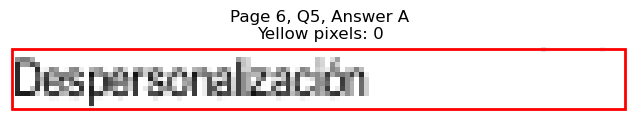

Page 6, Q5 - B: Detected box: x0=71.3, y0=483.4, x1=151.0, y1=495.4
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 515
Page 6, Q5, B: Yellow percentage: 0.0%


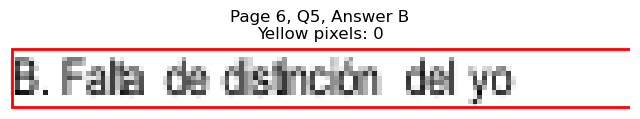

Page 6, Q5 - C: Detected box: x0=71.3, y0=495.4, x1=143.5, y1=507.4
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 472
Page 6, Q5, C: Yellow percentage: 0.0%


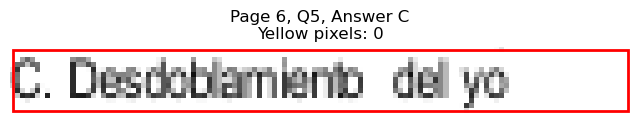

Page 6, Q5 - D: Detected box: x0=322.9, y0=470.6, x1=447.5, y1=482.6
Page 6, Q5, D: Yellow pixels: 1410
Page 6, Q5, D: Total non-white pixels: 2288
Page 6, Q5, D: Yellow percentage: 61.6%


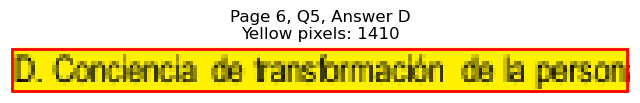

Page 6, Q5 - E: Detected box: x0=322.9, y0=483.4, x1=428.8, y1=495.4
Page 6, Q5, E: Yellow pixels: 156
Page 6, Q5, E: Total non-white pixels: 947
Page 6, Q5, E: Yellow percentage: 16.5%


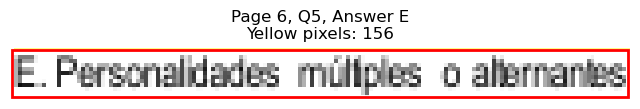


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.6, y0=543.4, x1=136.1, y1=555.5
Page 6, Q6, A: Yellow pixels: 428
Page 6, Q6, A: Total non-white pixels: 676
Page 6, Q6, A: Yellow percentage: 63.3%


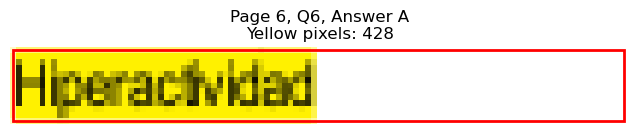

Page 6, Q6 - B: Detected box: x0=71.3, y0=555.4, x1=130.0, y1=567.5
Page 6, Q6, B: Yellow pixels: 50
Page 6, Q6, B: Total non-white pixels: 348
Page 6, Q6, B: Yellow percentage: 14.4%


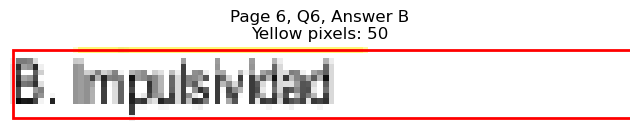

Page 6, Q6 - C: Detected box: x0=71.3, y0=567.5, x1=130.0, y1=579.5
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 300
Page 6, Q6, C: Yellow percentage: 0.0%


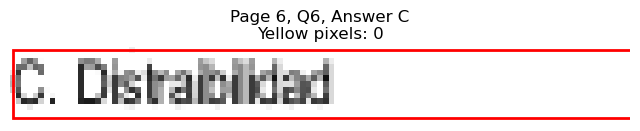

Page 6, Q6 - D: Detected box: x0=322.9, y0=543.4, x1=377.8, y1=555.5
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 262
Page 6, Q6, D: Yellow percentage: 0.0%


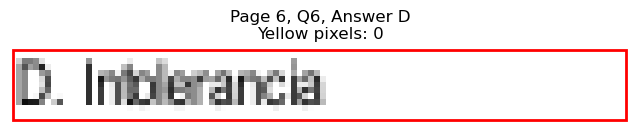

Page 6, Q6 - E: Detected box: x0=322.9, y0=555.4, x1=374.0, y1=567.5
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 276
Page 6, Q6, E: Yellow percentage: 0.0%


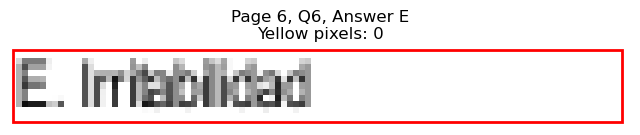


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.6, y0=615.5, x1=132.3, y1=627.5
Page 6, Q7, A: Yellow pixels: 400
Page 6, Q7, A: Total non-white pixels: 624
Page 6, Q7, A: Yellow percentage: 64.1%


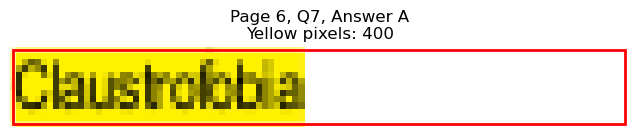

Page 6, Q7 - B: Detected box: x0=71.3, y0=627.5, x1=123.2, y1=639.6
Page 6, Q7, B: Yellow pixels: 47
Page 6, Q7, B: Total non-white pixels: 315
Page 6, Q7, B: Yellow percentage: 14.9%


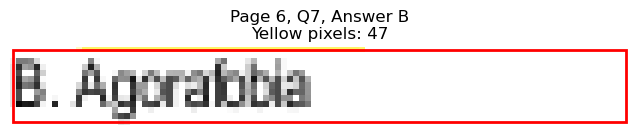

Page 6, Q7 - C: Detected box: x0=71.3, y0=639.5, x1=119.5, y1=651.6
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 229
Page 6, Q7, C: Yellow percentage: 0.0%


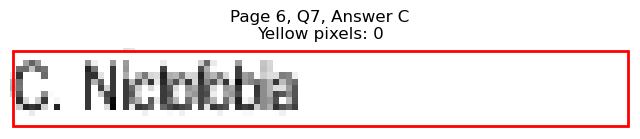

Page 6, Q7 - D: Detected box: x0=322.9, y0=615.5, x1=374.0, y1=627.5
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 268
Page 6, Q7, D: Yellow percentage: 0.0%


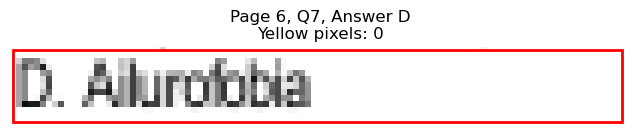

Page 6, Q7 - E: Detected box: x0=322.9, y0=627.5, x1=377.0, y1=639.6
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 264
Page 6, Q7, E: Yellow percentage: 0.0%


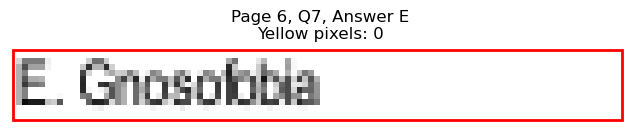


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.6, y0=688.3, x1=127.8, y1=700.3
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 237
Page 6, Q8, A: Yellow percentage: 0.0%


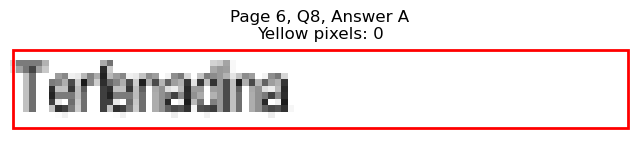

Page 6, Q8 - B: Detected box: x0=71.3, y0=700.3, x1=128.5, y1=712.3
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 258
Page 6, Q8, B: Yellow percentage: 0.0%


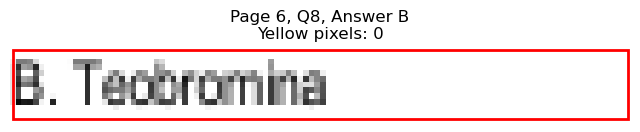

Page 6, Q8 - C: Detected box: x0=71.3, y0=712.3, x1=112.7, y1=724.4
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 178
Page 6, Q8, C: Yellow percentage: 0.0%


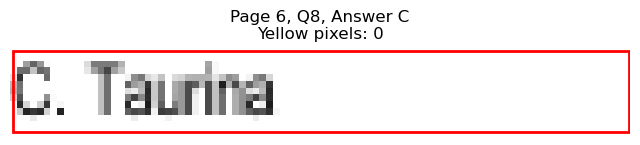

Page 6, Q8 - D: Detected box: x0=322.9, y0=688.3, x1=363.6, y1=700.3
Page 6, Q8, D: Yellow pixels: 285
Page 6, Q8, D: Total non-white pixels: 520
Page 6, Q8, D: Yellow percentage: 54.8%


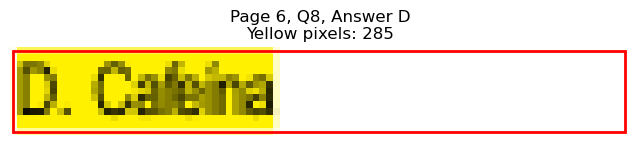

Page 6, Q8 - E: Detected box: x0=322.9, y0=700.3, x1=354.7, y1=712.3
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 197
Page 6, Q8, E: Yellow percentage: 0.0%


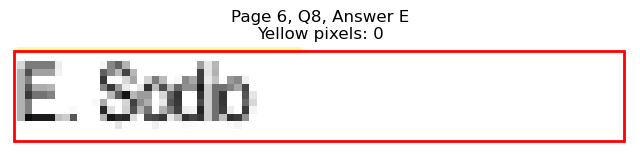


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 8 questions
Page 7, Q1 - A: Detected box: x0=82.6, y0=133.5, x1=122.5, y1=145.6
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 397
Page 7, Q1, A: Yellow percentage: 0.0%


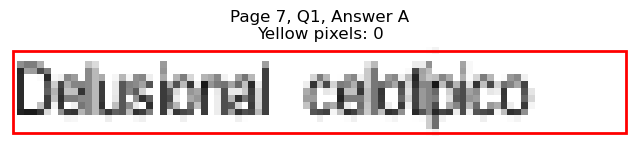

Page 7, Q1 - B: Detected box: x0=124.6, y0=145.6, x1=176.6, y1=157.6
Page 7, Q1, B: Yellow pixels: 389
Page 7, Q1, B: Total non-white pixels: 663
Page 7, Q1, B: Yellow percentage: 58.7%


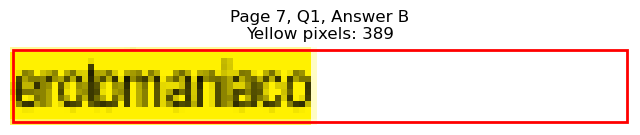

Page 7, Q1 - C: Detected box: x0=71.3, y0=157.6, x1=175.0, y1=169.6
Page 7, Q1, C: Yellow pixels: 103
Page 7, Q1, C: Total non-white pixels: 617
Page 7, Q1, C: Yellow percentage: 16.7%


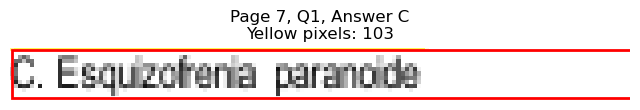

Page 7, Q1 - D: Detected box: x0=322.9, y0=133.5, x1=416.8, y1=145.6
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 469
Page 7, Q1, D: Yellow percentage: 0.0%


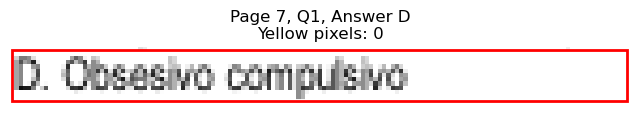

Page 7, Q1 - E: Detected box: x0=322.9, y0=145.6, x1=404.1, y1=157.6
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 430
Page 7, Q1, E: Yellow percentage: 0.0%


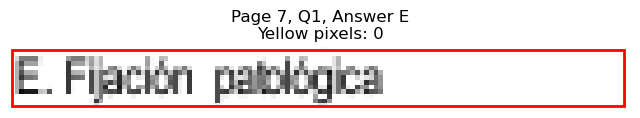


Page 7, Q1 - Selected Answer: B (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=143.5, y1=205.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 308
Page 7, Q2, A: Yellow percentage: 0.0%


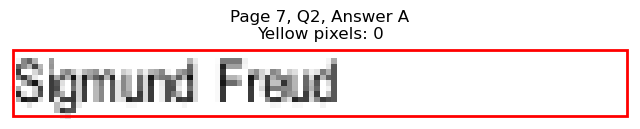

Page 7, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=139.7, y1=217.7
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 316
Page 7, Q2, B: Yellow percentage: 0.0%


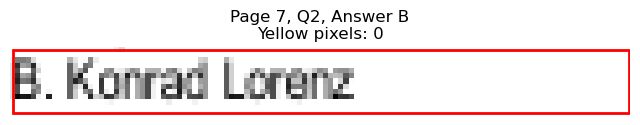

Page 7, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=140.6, y1=229.7
Page 7, Q2, C: Yellow pixels: 543
Page 7, Q2, C: Total non-white pixels: 884
Page 7, Q2, C: Yellow percentage: 61.4%


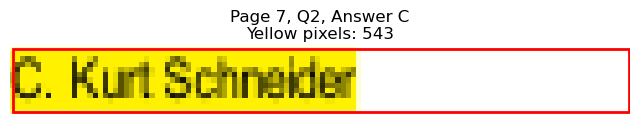

Page 7, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=389.8, y1=205.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 331
Page 7, Q2, D: Yellow percentage: 0.0%


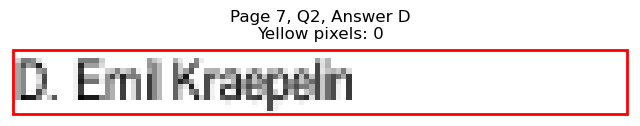

Page 7, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=382.2, y1=217.7
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 292
Page 7, Q2, E: Yellow percentage: 0.0%


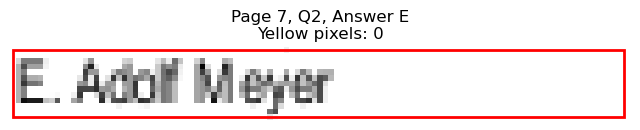


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=152.5, y1=265.7
Page 7, Q3, A: Yellow pixels: 872
Page 7, Q3, A: Total non-white pixels: 1418
Page 7, Q3, A: Yellow percentage: 61.5%


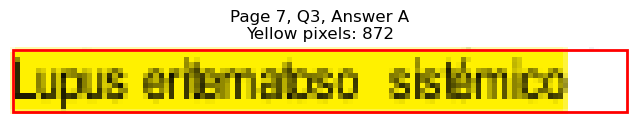

Page 7, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=188.4, y1=277.7
Page 7, Q3, B: Yellow pixels: 108
Page 7, Q3, B: Total non-white pixels: 675
Page 7, Q3, B: Yellow percentage: 16.0%


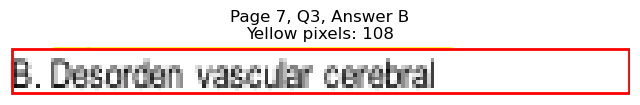

Page 7, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=138.2, y1=289.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 323
Page 7, Q3, C: Yellow percentage: 0.0%


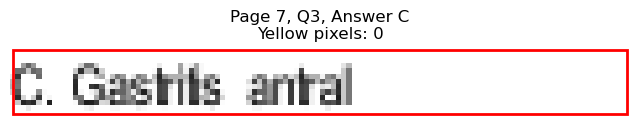

Page 7, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=365.0, y1=265.7
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 403
Page 7, Q3, D: Yellow percentage: 0.0%


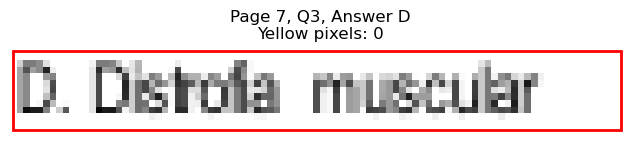

Page 7, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=371.8, y1=277.7
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 399
Page 7, Q3, E: Yellow percentage: 0.0%


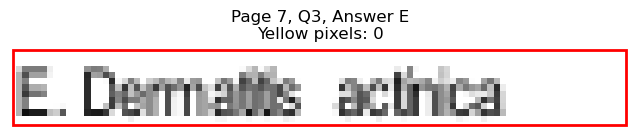


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=175.9, y1=362.5
Page 7, Q4, A: Yellow pixels: 812
Page 7, Q4, A: Total non-white pixels: 1198
Page 7, Q4, A: Yellow percentage: 67.8%


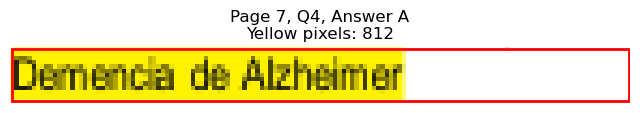

Page 7, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=159.2, y1=374.6
Page 7, Q4, B: Yellow pixels: 90
Page 7, Q4, B: Total non-white pixels: 515
Page 7, Q4, B: Yellow percentage: 17.5%


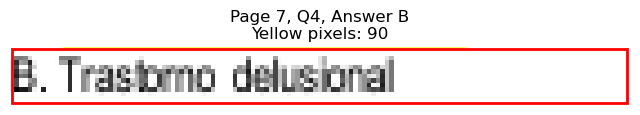

Page 7, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=164.5, y1=386.6
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 427
Page 7, Q4, C: Yellow percentage: 0.0%


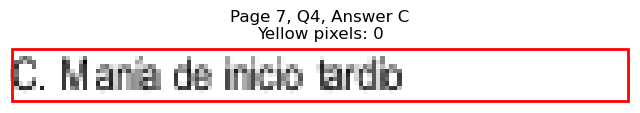

Page 7, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=408.5, y1=362.5
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 392
Page 7, Q4, D: Yellow percentage: 0.0%


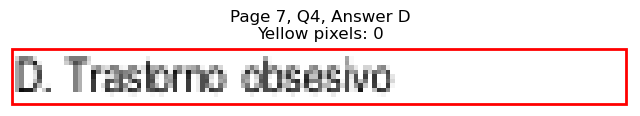

Page 7, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=378.5, y1=374.6
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 465
Page 7, Q4, E: Yellow percentage: 0.0%


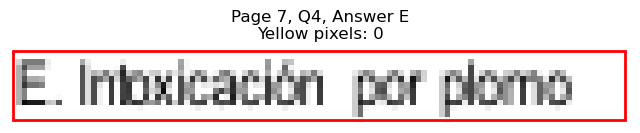


Page 7, Q4 - Selected Answer: A (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.6, y0=434.6, x1=139.7, y1=446.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 279
Page 7, Q5, A: Yellow percentage: 0.0%


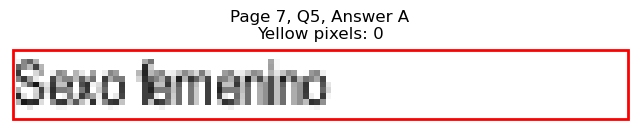

Page 7, Q5 - B: Detected box: x0=71.3, y0=446.6, x1=150.2, y1=458.6
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 385
Page 7, Q5, B: Yellow percentage: 0.0%


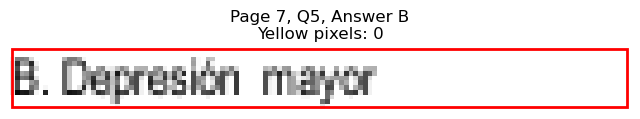

Page 7, Q5 - C: Detected box: x0=71.3, y0=458.6, x1=129.2, y1=470.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 275
Page 7, Q5, C: Yellow percentage: 0.0%


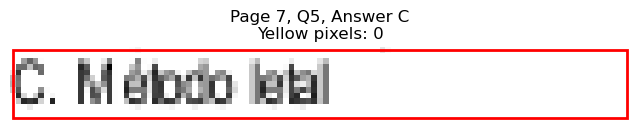

Page 7, Q5 - D: Detected box: x0=322.9, y0=434.6, x1=359.8, y1=446.6
Page 7, Q5, D: Yellow pixels: 502
Page 7, Q5, D: Total non-white pixels: 832
Page 7, Q5, D: Yellow percentage: 60.3%


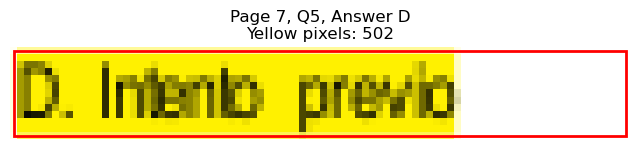

Page 7, Q5 - E: Detected box: x0=322.9, y0=446.6, x1=404.0, y1=458.6
Page 7, Q5, E: Yellow pixels: 62
Page 7, Q5, E: Total non-white pixels: 478
Page 7, Q5, E: Yellow percentage: 13.0%


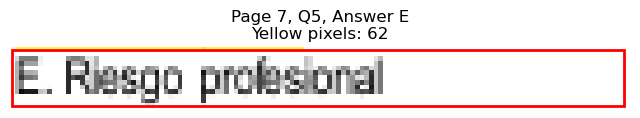


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.6, y0=531.4, x1=134.5, y1=543.5
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 286
Page 7, Q6, A: Yellow percentage: 0.0%


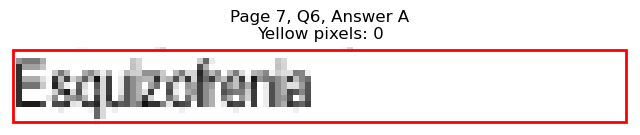

Page 7, Q6 - B: Detected box: x0=71.3, y0=543.4, x1=141.2, y1=555.5
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 348
Page 7, Q6, B: Yellow percentage: 0.0%


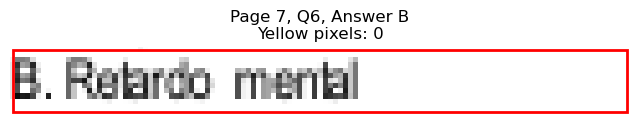

Page 7, Q6 - C: Detected box: x0=71.3, y0=555.4, x1=166.9, y1=567.5
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 474
Page 7, Q6, C: Yellow percentage: 0.0%


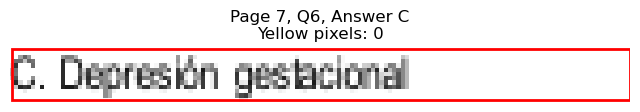

Page 7, Q6 - D: Detected box: x0=322.9, y0=531.4, x1=425.1, y1=543.5
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 508
Page 7, Q6, D: Yellow percentage: 0.0%


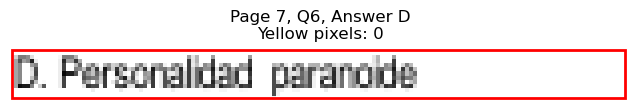

Page 7, Q6 - E: Detected box: x0=322.9, y0=543.4, x1=395.9, y1=555.5
Page 7, Q6, E: Yellow pixels: 638
Page 7, Q6, E: Total non-white pixels: 936
Page 7, Q6, E: Yellow percentage: 68.2%


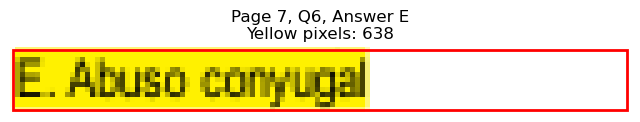


Page 7, Q6 - Selected Answer: E (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.6, y0=627.5, x1=124.8, y1=639.6
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 212
Page 7, Q7, A: Yellow percentage: 0.0%


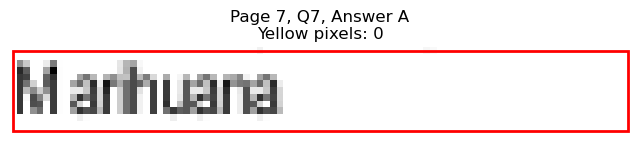

Page 7, Q7 - B: Detected box: x0=71.3, y0=639.5, x1=111.2, y1=651.6
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 196
Page 7, Q7, B: Yellow percentage: 0.0%


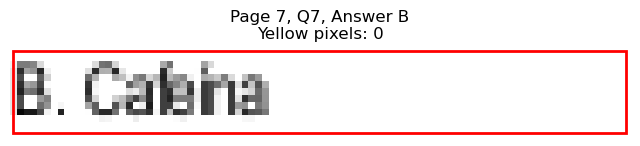

Page 7, Q7 - C: Detected box: x0=71.3, y0=651.5, x1=115.0, y1=663.6
Page 7, Q7, C: Yellow pixels: 400
Page 7, Q7, C: Total non-white pixels: 546
Page 7, Q7, C: Yellow percentage: 73.3%


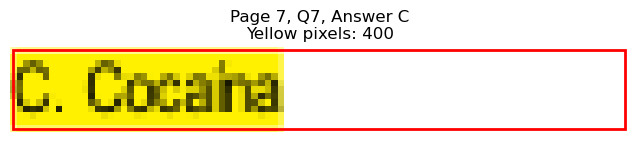

Page 7, Q7 - D: Detected box: x0=322.9, y0=627.5, x1=395.0, y1=639.6
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 379
Page 7, Q7, D: Yellow percentage: 0.0%


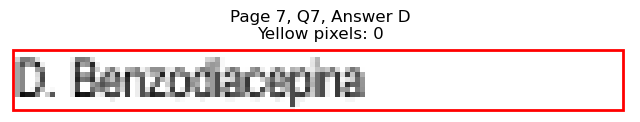

Page 7, Q7 - E: Detected box: x0=322.9, y0=639.5, x1=385.3, y1=651.6
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 311
Page 7, Q7, E: Yellow percentage: 0.0%


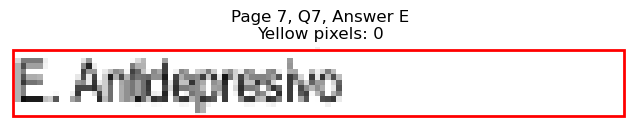


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.6, y0=700.3, x1=130.0, y1=712.3
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 266
Page 7, Q8, A: Yellow percentage: 0.0%


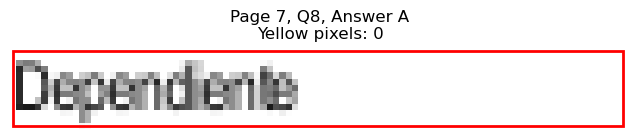

Page 7, Q8 - B: Detected box: x0=71.3, y0=712.3, x1=118.7, y1=724.4
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 240
Page 7, Q8, B: Yellow percentage: 0.0%


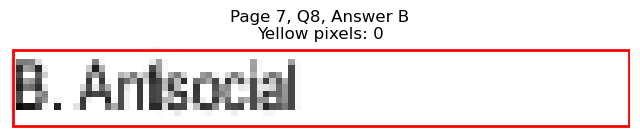

Page 7, Q8 - C: Detected box: x0=71.3, y0=724.3, x1=125.5, y1=736.4
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 258
Page 7, Q8, C: Yellow percentage: 0.0%


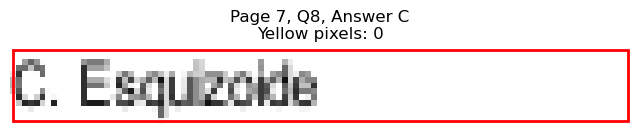

Page 7, Q8 - D: Detected box: x0=322.9, y0=700.3, x1=366.6, y1=712.3
Page 7, Q8, D: Yellow pixels: 324
Page 7, Q8, D: Total non-white pixels: 559
Page 7, Q8, D: Yellow percentage: 58.0%


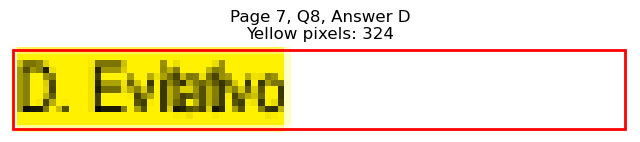

Page 7, Q8 - E: Detected box: x0=322.9, y0=712.3, x1=381.7, y1=724.4
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 348
Page 7, Q8, E: Yellow percentage: 0.0%


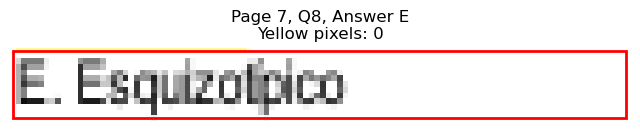


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=115.0, y1=121.6
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 171
Page 8, Q1, A: Yellow percentage: 0.0%


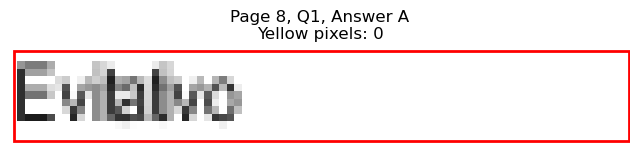

Page 8, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=119.5, y1=133.6
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 223
Page 8, Q1, B: Yellow percentage: 0.0%


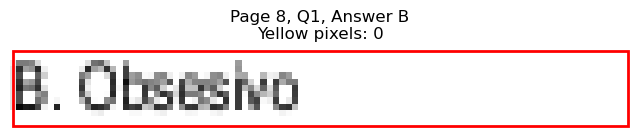

Page 8, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=115.0, y1=145.6
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 196
Page 8, Q1, C: Yellow percentage: 0.0%


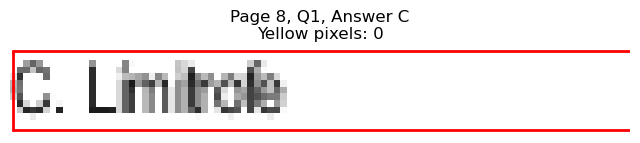

Page 8, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=381.6, y1=121.6
Page 8, Q1, D: Yellow pixels: 485
Page 8, Q1, D: Total non-white pixels: 754
Page 8, Q1, D: Yellow percentage: 64.3%


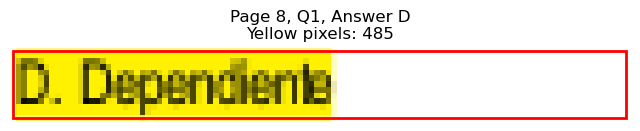

Page 8, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=373.3, y1=133.6
Page 8, Q1, E: Yellow pixels: 56
Page 8, Q1, E: Total non-white pixels: 306
Page 8, Q1, E: Yellow percentage: 18.3%


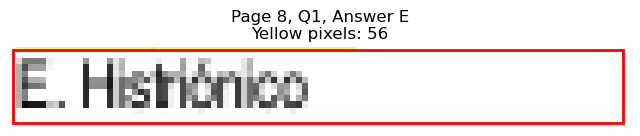


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=133.0, y1=205.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 262
Page 8, Q2, A: Yellow percentage: 0.0%


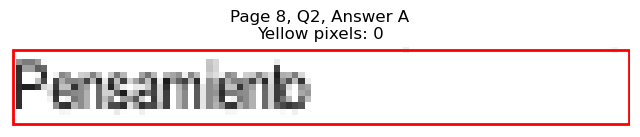

Page 8, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=124.0, y1=217.7
Page 8, Q2, B: Yellow pixels: 381
Page 8, Q2, B: Total non-white pixels: 663
Page 8, Q2, B: Yellow percentage: 57.5%


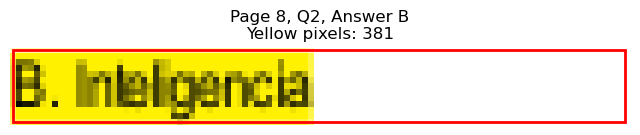

Page 8, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=115.8, y1=229.7
Page 8, Q2, C: Yellow pixels: 51
Page 8, Q2, C: Total non-white pixels: 252
Page 8, Q2, C: Yellow percentage: 20.2%


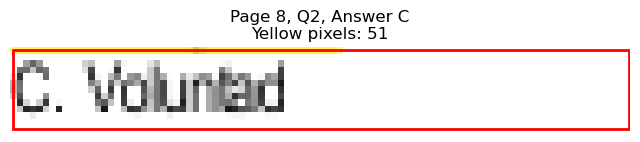

Page 8, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=377.0, y1=205.6
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 261
Page 8, Q2, D: Yellow percentage: 0.0%


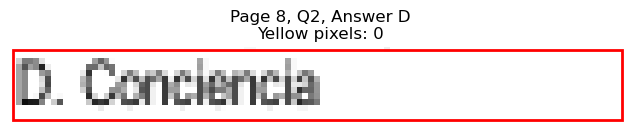

Page 8, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=404.0, y1=217.7
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 373
Page 8, Q2, E: Yellow percentage: 0.0%


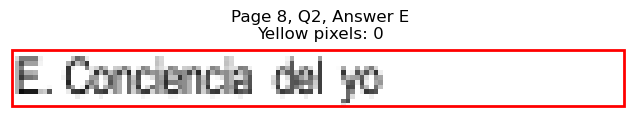


Page 8, Q2 - Selected Answer: B (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.6, y0=265.7, x1=142.7, y1=277.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 308
Page 8, Q3, A: Yellow percentage: 0.0%


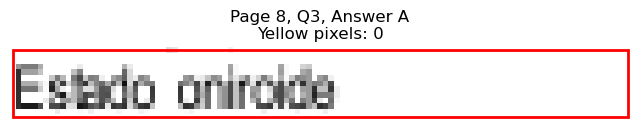

Page 8, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=129.2, y1=289.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 295
Page 8, Q3, B: Yellow percentage: 0.0%


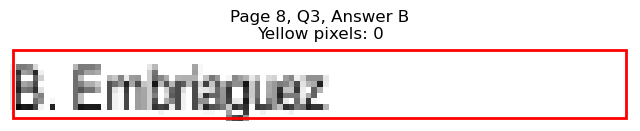

Page 8, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=107.5, y1=301.8
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 163
Page 8, Q3, C: Yellow percentage: 0.0%


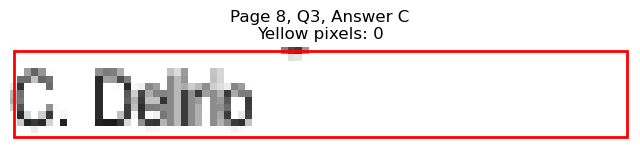

Page 8, Q3 - D: Detected box: x0=322.9, y0=265.7, x1=409.4, y1=277.7
Page 8, Q3, D: Yellow pixels: 673
Page 8, Q3, D: Total non-white pixels: 1117
Page 8, Q3, D: Yellow percentage: 60.3%


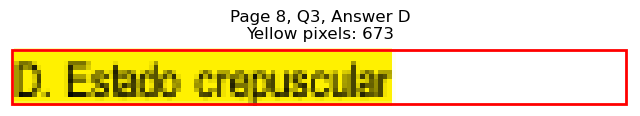

Page 8, Q3 - E: Detected box: x0=322.9, y0=277.7, x1=371.8, y1=289.7
Page 8, Q3, E: Yellow pixels: 82
Page 8, Q3, E: Total non-white pixels: 468
Page 8, Q3, E: Yellow percentage: 17.5%


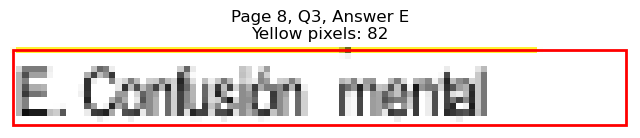


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=174.2, y1=362.5
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 485
Page 8, Q4, A: Yellow percentage: 0.0%


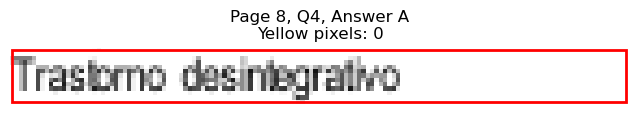

Page 8, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=163.7, y1=374.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 479
Page 8, Q4, B: Yellow percentage: 0.0%


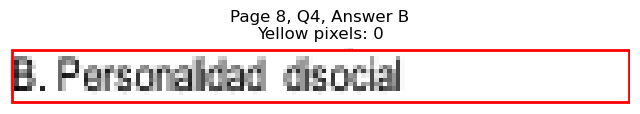

Page 8, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=136.0, y1=386.6
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 302
Page 8, Q4, C: Yellow percentage: 0.0%


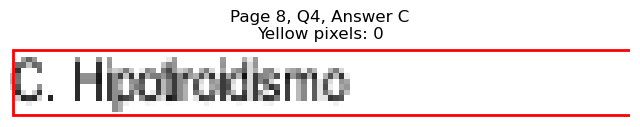

Page 8, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=414.7, y1=362.5
Page 8, Q4, D: Yellow pixels: 785
Page 8, Q4, D: Total non-white pixels: 1185
Page 8, Q4, D: Yellow percentage: 66.2%


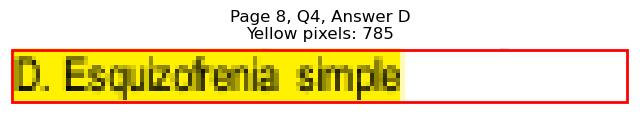

Page 8, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=402.5, y1=374.6
Page 8, Q4, E: Yellow pixels: 89
Page 8, Q4, E: Total non-white pixels: 457
Page 8, Q4, E: Yellow percentage: 19.5%


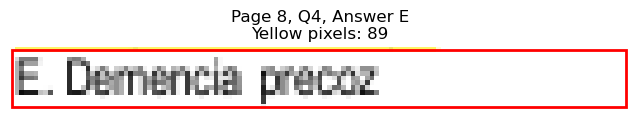


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.6, y0=434.6, x1=124.0, y1=446.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 422
Page 8, Q5, A: Yellow percentage: 0.0%


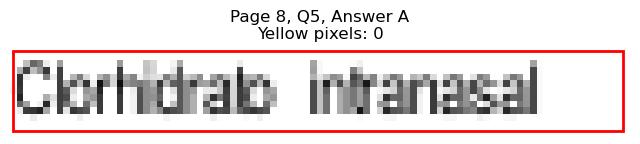

Page 8, Q5 - B: Detected box: x0=71.3, y0=446.6, x1=123.2, y1=458.6
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 502
Page 8, Q5, B: Yellow percentage: 0.0%


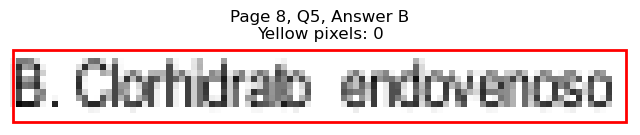

Page 8, Q5 - C: Detected box: x0=71.3, y0=458.6, x1=182.6, y1=470.6
Page 8, Q5, C: Yellow pixels: 927
Page 8, Q5, C: Total non-white pixels: 1430
Page 8, Q5, C: Yellow percentage: 64.8%


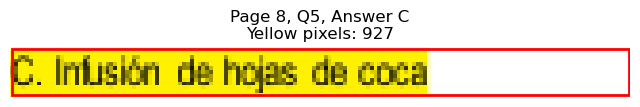

Page 8, Q5 - D: Detected box: x0=322.9, y0=434.6, x1=384.5, y1=446.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 298
Page 8, Q5, D: Yellow percentage: 0.0%


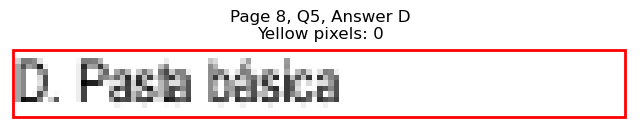

Page 8, Q5 - E: Detected box: x0=322.9, y0=446.6, x1=358.3, y1=458.6
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 155
Page 8, Q5, E: Yellow percentage: 0.0%


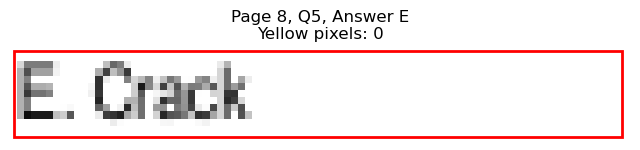


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=125.5, y1=507.4
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 205
Page 8, Q6, A: Yellow percentage: 0.0%


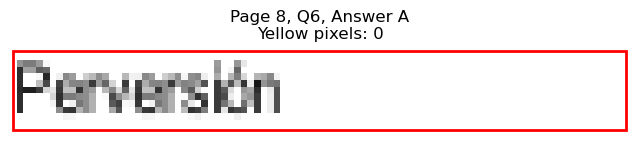

Page 8, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=138.2, y1=519.4
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 329
Page 8, Q6, B: Yellow percentage: 0.0%


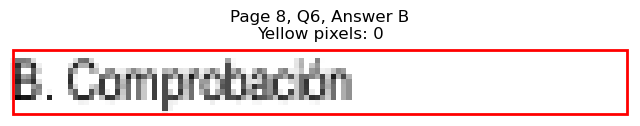

Page 8, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=122.5, y1=531.4
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 248
Page 8, Q6, C: Yellow percentage: 0.0%


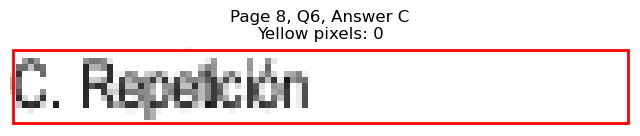

Page 8, Q6 - D: Detected box: x0=322.9, y0=495.4, x1=390.6, y1=507.4
Page 8, Q6, D: Yellow pixels: 578
Page 8, Q6, D: Total non-white pixels: 871
Page 8, Q6, D: Yellow percentage: 66.4%


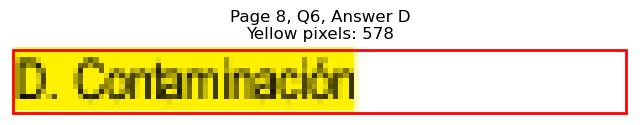

Page 8, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=359.0, y1=519.4
Page 8, Q6, E: Yellow pixels: 65
Page 8, Q6, E: Total non-white pixels: 233
Page 8, Q6, E: Yellow percentage: 27.9%


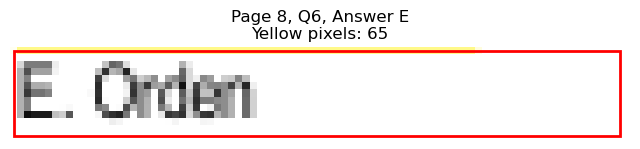


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.6, y0=603.5, x1=169.8, y1=615.5
Page 8, Q7, A: Yellow pixels: 739
Page 8, Q7, A: Total non-white pixels: 1120
Page 8, Q7, A: Yellow percentage: 66.0%


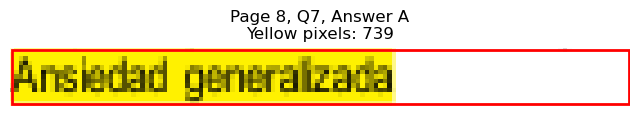

Page 8, Q7 - B: Detected box: x0=71.3, y0=615.5, x1=109.7, y1=627.5
Page 8, Q7, B: Yellow pixels: 77
Page 8, Q7, B: Total non-white pixels: 258
Page 8, Q7, B: Yellow percentage: 29.8%


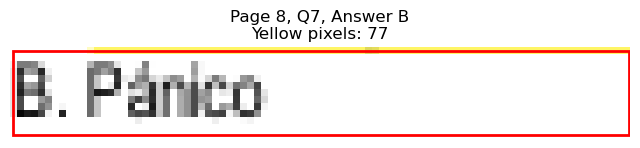

Page 8, Q7 - C: Detected box: x0=71.3, y0=627.5, x1=142.7, y1=639.6
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 355
Page 8, Q7, C: Yellow percentage: 0.0%


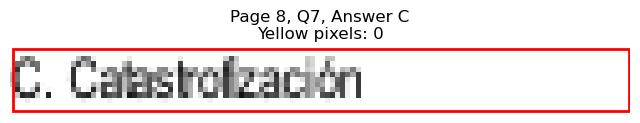

Page 8, Q7 - D: Detected box: x0=322.9, y0=603.5, x1=416.7, y1=615.5
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 448
Page 8, Q7, D: Yellow percentage: 0.0%


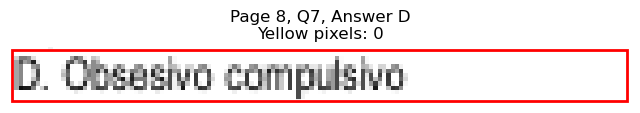

Page 8, Q7 - E: Detected box: x0=322.9, y0=615.5, x1=383.8, y1=627.5
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 303
Page 8, Q7, E: Yellow percentage: 0.0%


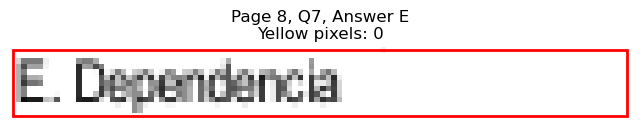


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.6, y0=688.3, x1=125.5, y1=700.3
Page 8, Q8, A: Yellow pixels: 300
Page 8, Q8, A: Total non-white pixels: 548
Page 8, Q8, A: Yellow percentage: 54.7%


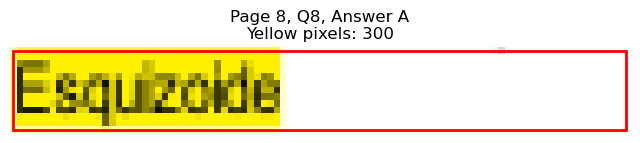

Page 8, Q8 - B: Detected box: x0=71.3, y0=700.3, x1=120.2, y1=712.3
Page 8, Q8, B: Yellow pixels: 1
Page 8, Q8, B: Total non-white pixels: 298
Page 8, Q8, B: Yellow percentage: 0.3%


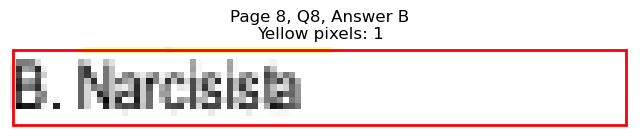

Page 8, Q8 - C: Detected box: x0=71.3, y0=712.3, x1=120.2, y1=724.4
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 227
Page 8, Q8, C: Yellow percentage: 0.0%


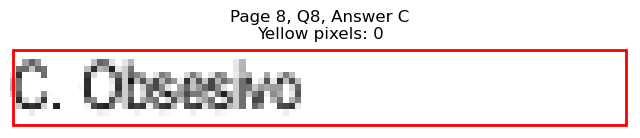

Page 8, Q8 - D: Detected box: x0=322.9, y0=688.3, x1=384.5, y1=700.3
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 321
Page 8, Q8, D: Yellow percentage: 0.0%


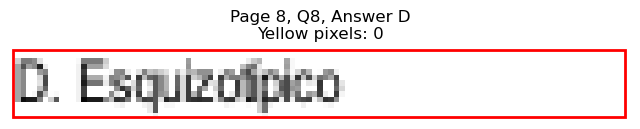

Page 8, Q8 - E: Detected box: x0=322.9, y0=700.3, x1=365.8, y1=712.3
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 203
Page 8, Q8, E: Yellow percentage: 0.0%


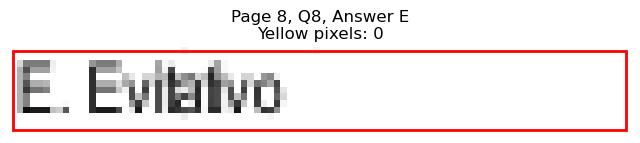


Page 8, Q8 - Selected Answer: A (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.6, y0=748.4, x1=130.8, y1=760.4
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 234
Page 8, Q9, A: Yellow percentage: 0.0%


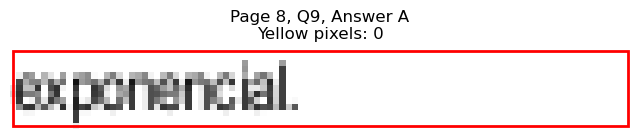

Page 8, Q9 - B: Detected box: x0=71.3, y0=760.4, x1=118.0, y1=772.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 229
Page 8, Q9, B: Yellow percentage: 0.0%


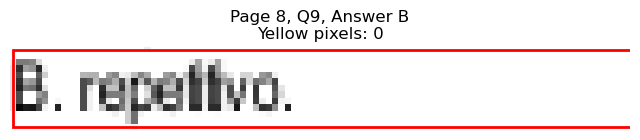

Page 8, Q9 - C: Detected box: x0=71.3, y0=772.4, x1=118.7, y1=784.4
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 214
Page 8, Q9, C: Yellow percentage: 0.0%


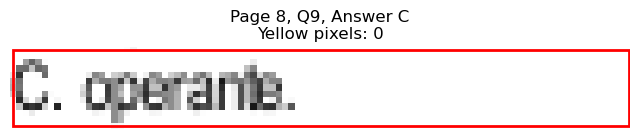

Page 8, Q9 - D: Detected box: x0=322.9, y0=748.4, x1=364.3, y1=760.4
Page 8, Q9, D: Yellow pixels: 355
Page 8, Q9, D: Total non-white pixels: 520
Page 8, Q9, D: Yellow percentage: 68.3%


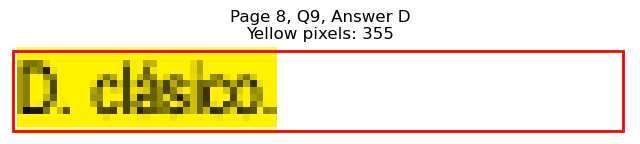

Page 8, Q9 - E: Detected box: x0=322.9, y0=760.4, x1=365.8, y1=772.4
Page 8, Q9, E: Yellow pixels: 39
Page 8, Q9, E: Total non-white pixels: 210
Page 8, Q9, E: Yellow percentage: 18.6%


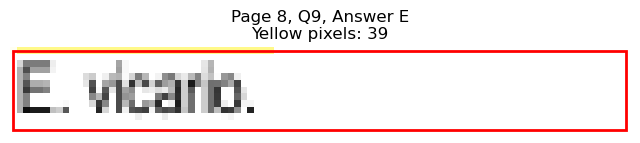


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)





Page 9: Found 8 questions
Page 9, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=125.5, y1=121.6
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 242
Page 9, Q1, A: Yellow percentage: 0.0%


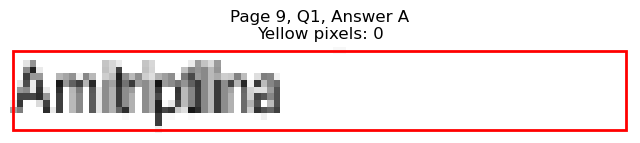

Page 9, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=124.7, y1=133.6
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 286
Page 9, Q1, B: Yellow percentage: 0.0%


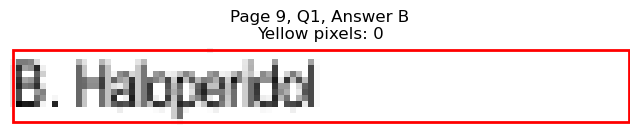

Page 9, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=126.3, y1=145.6
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 273
Page 9, Q1, C: Yellow percentage: 0.0%


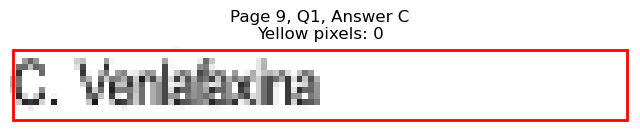

Page 9, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=374.1, y1=121.6
Page 9, Q1, D: Yellow pixels: 430
Page 9, Q1, D: Total non-white pixels: 650
Page 9, Q1, D: Yellow percentage: 66.2%


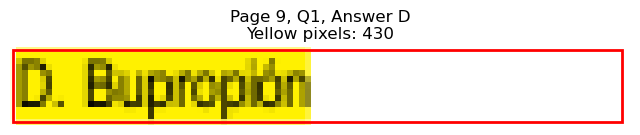

Page 9, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=369.5, y1=133.6
Page 9, Q1, E: Yellow pixels: 49
Page 9, Q1, E: Total non-white pixels: 282
Page 9, Q1, E: Yellow percentage: 17.4%


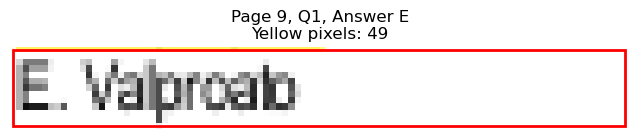


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=117.8, y0=193.6, x1=194.6, y1=205.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 365
Page 9, Q2, A: Yellow percentage: 0.0%


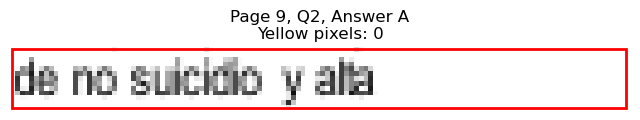

Page 9, Q2 - B: Detected box: x0=144.8, y0=205.6, x1=238.2, y1=217.7
Page 9, Q2, B: Yellow pixels: 737
Page 9, Q2, B: Total non-white pixels: 1196
Page 9, Q2, B: Yellow percentage: 61.6%


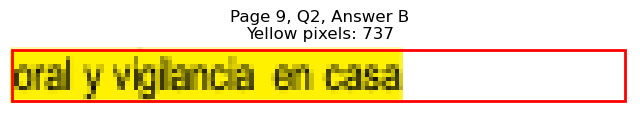

Page 9, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=223.7, y1=229.7
Page 9, Q2, C: Yellow pixels: 165
Page 9, Q2, C: Total non-white pixels: 1158
Page 9, Q2, C: Yellow percentage: 14.2%


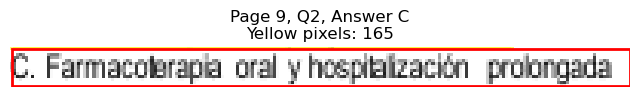

Page 9, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=434.8, y1=205.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 836
Page 9, Q2, D: Yellow percentage: 0.0%


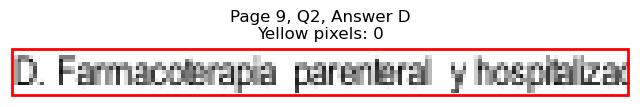

Page 9, Q2 - E: Detected box: x0=322.9, y0=217.6, x1=482.8, y1=229.7
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 801
Page 9, Q2, E: Yellow percentage: 0.0%


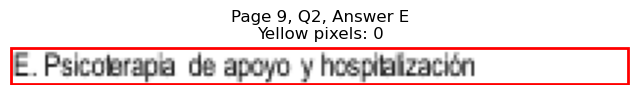


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.6, y0=302.5, x1=134.5, y1=314.5
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 494
Page 9, Q3, A: Yellow percentage: 0.0%


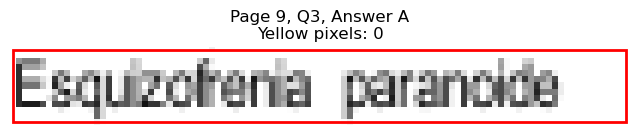

Page 9, Q3 - B: Detected box: x0=71.3, y0=314.5, x1=159.3, y1=326.5
Page 9, Q3, B: Yellow pixels: 1092
Page 9, Q3, B: Total non-white pixels: 1625
Page 9, Q3, B: Yellow percentage: 67.2%


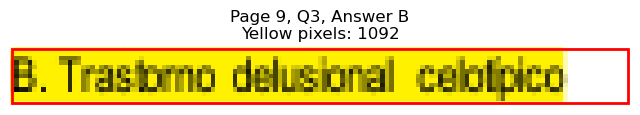

Page 9, Q3 - C: Detected box: x0=71.3, y0=326.5, x1=156.2, y1=338.5
Page 9, Q3, C: Yellow pixels: 124
Page 9, Q3, C: Total non-white pixels: 533
Page 9, Q3, C: Yellow percentage: 23.3%


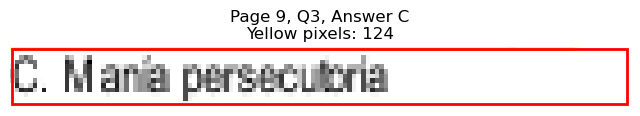

Page 9, Q3 - D: Detected box: x0=322.9, y0=302.5, x1=454.2, y1=314.5
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 625
Page 9, Q3, D: Yellow percentage: 0.0%


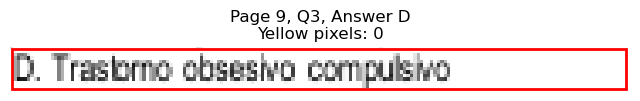

Page 9, Q3 - E: Detected box: x0=322.9, y0=314.5, x1=419.0, y1=326.5
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 460
Page 9, Q3, E: Yellow percentage: 0.0%


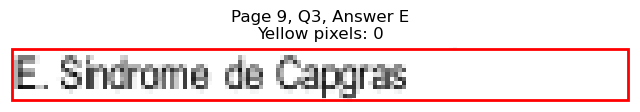


Page 9, Q3 - Selected Answer: B (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.6, y0=386.5, x1=130.0, y1=398.6
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 242
Page 9, Q4, A: Yellow percentage: 0.0%


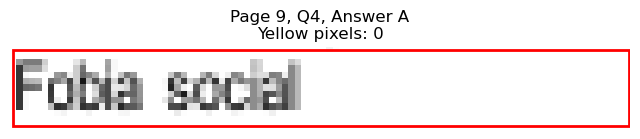

Page 9, Q4 - B: Detected box: x0=71.3, y0=398.5, x1=109.7, y1=410.6
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 180
Page 9, Q4, B: Yellow percentage: 0.0%


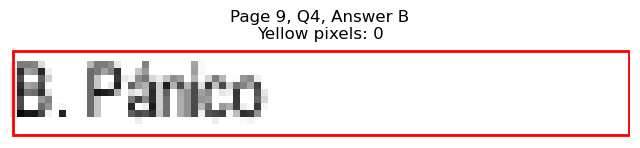

Page 9, Q4 - C: Detected box: x0=71.3, y0=410.5, x1=145.1, y1=422.6
Page 9, Q4, C: Yellow pixels: 577
Page 9, Q4, C: Total non-white pixels: 936
Page 9, Q4, C: Yellow percentage: 61.6%


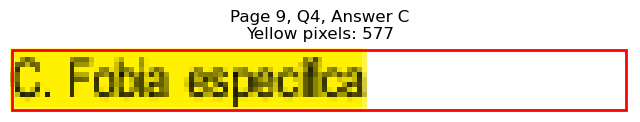

Page 9, Q4 - D: Detected box: x0=322.9, y0=386.5, x1=421.3, y1=398.6
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 514
Page 9, Q4, D: Yellow percentage: 0.0%


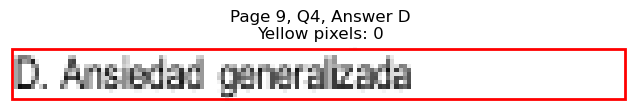

Page 9, Q4 - E: Detected box: x0=322.9, y0=398.5, x1=377.8, y1=410.6
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 252
Page 9, Q4, E: Yellow percentage: 0.0%


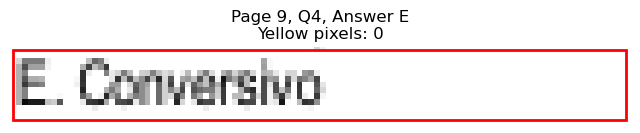


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.6, y0=483.4, x1=125.5, y1=495.4
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 230
Page 9, Q5, A: Yellow percentage: 0.0%


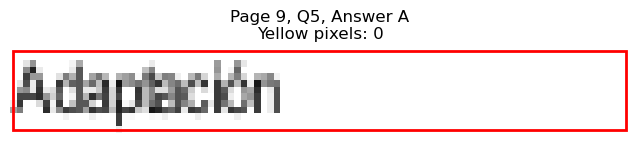

Page 9, Q5 - B: Detected box: x0=71.3, y0=495.4, x1=118.7, y1=507.4
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 250
Page 9, Q5, B: Yellow percentage: 0.0%


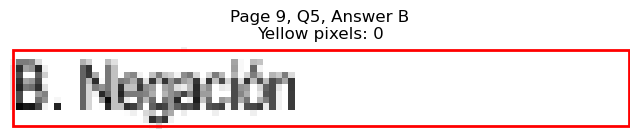

Page 9, Q5 - C: Detected box: x0=71.3, y0=507.4, x1=112.7, y1=519.4
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 197
Page 9, Q5, C: Yellow percentage: 0.0%


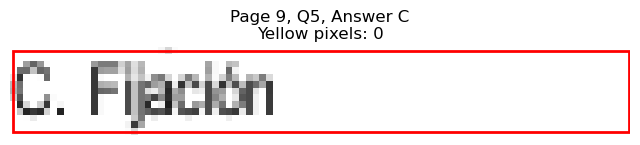

Page 9, Q5 - D: Detected box: x0=322.9, y0=483.4, x1=381.6, y1=495.4
Page 9, Q5, D: Yellow pixels: 493
Page 9, Q5, D: Total non-white pixels: 754
Page 9, Q5, D: Yellow percentage: 65.4%


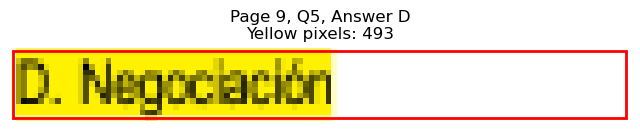

Page 9, Q5 - E: Detected box: x0=322.9, y0=495.4, x1=380.9, y1=507.4
Page 9, Q5, E: Yellow pixels: 56
Page 9, Q5, E: Total non-white pixels: 353
Page 9, Q5, E: Yellow percentage: 15.9%


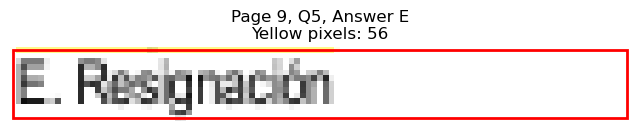


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.6, y0=579.4, x1=133.7, y1=591.5
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 504
Page 9, Q6, A: Yellow percentage: 0.0%


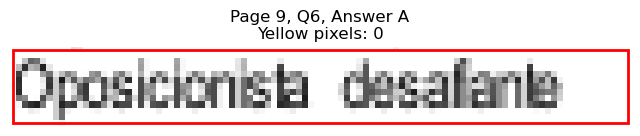

Page 9, Q6 - B: Detected box: x0=71.3, y0=591.5, x1=175.0, y1=603.5
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 517
Page 9, Q6, B: Yellow percentage: 0.0%


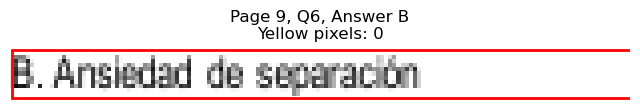

Page 9, Q6 - C: Detected box: x0=108.8, y0=603.5, x1=223.9, y1=615.5
Page 9, Q6, C: Yellow pixels: 1007
Page 9, Q6, C: Total non-white pixels: 1482
Page 9, Q6, C: Yellow percentage: 67.9%


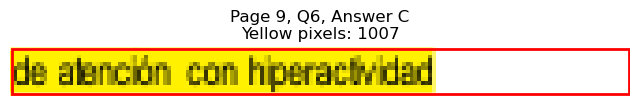

Page 9, Q6 - D: Detected box: x0=322.9, y0=579.4, x1=362.0, y1=591.5
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 199
Page 9, Q6, D: Yellow percentage: 0.0%


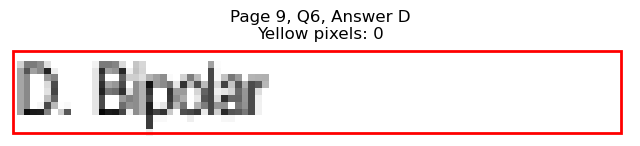

Page 9, Q6 - E: Detected box: x0=322.9, y0=591.5, x1=401.8, y1=603.5
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 367
Page 9, Q6, E: Yellow percentage: 0.0%


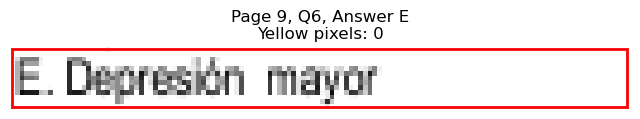


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.6, y0=639.5, x1=112.0, y1=651.6
Page 9, Q7, A: Yellow pixels: 233
Page 9, Q7, A: Total non-white pixels: 364
Page 9, Q7, A: Yellow percentage: 64.0%


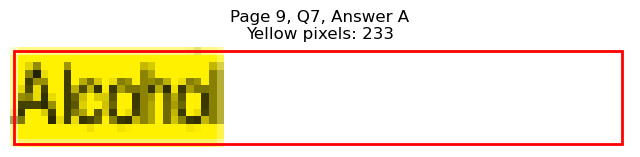

Page 9, Q7 - B: Detected box: x0=71.3, y0=651.5, x1=124.0, y1=663.6
Page 9, Q7, B: Yellow pixels: 27
Page 9, Q7, B: Total non-white pixels: 288
Page 9, Q7, B: Yellow percentage: 9.4%


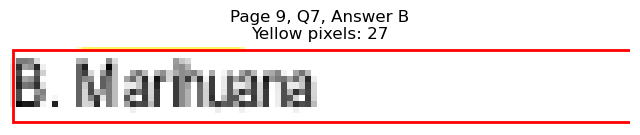

Page 9, Q7 - C: Detected box: x0=71.3, y0=663.5, x1=115.0, y1=675.6
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 191
Page 9, Q7, C: Yellow percentage: 0.0%


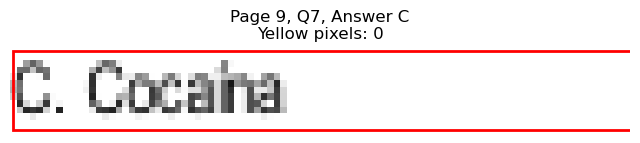

Page 9, Q7 - D: Detected box: x0=322.9, y0=639.5, x1=399.5, y1=651.6
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 403
Page 9, Q7, D: Yellow percentage: 0.0%


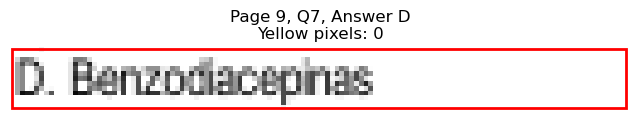

Page 9, Q7 - E: Detected box: x0=322.9, y0=651.5, x1=364.3, y1=663.6
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 201
Page 9, Q7, E: Yellow percentage: 0.0%


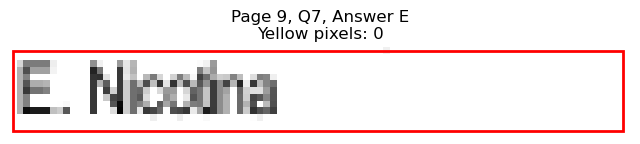


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.6, y0=639.5, x1=112.0, y1=651.6
Page 9, Q8, A: Yellow pixels: 233
Page 9, Q8, A: Total non-white pixels: 364
Page 9, Q8, A: Yellow percentage: 64.0%


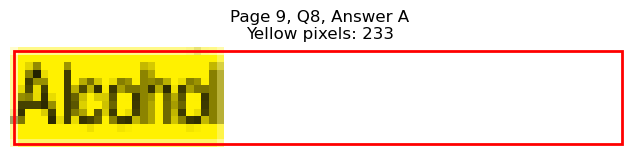

Page 9, Q8 - B: Detected box: x0=71.3, y0=712.3, x1=112.8, y1=724.4
Page 9, Q8, B: Yellow pixels: 301
Page 9, Q8, B: Total non-white pixels: 520
Page 9, Q8, B: Yellow percentage: 57.9%


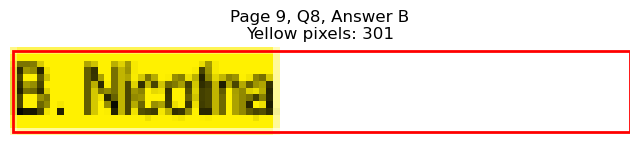

Page 9, Q8 - C: Detected box: x0=71.3, y0=724.3, x1=124.7, y1=736.4
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 284
Page 9, Q8, C: Yellow percentage: 0.0%


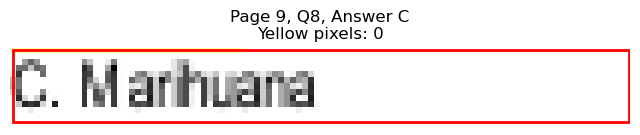

Page 9, Q8 - D: Detected box: x0=322.9, y0=700.3, x1=366.5, y1=712.3
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 202
Page 9, Q8, D: Yellow percentage: 0.0%


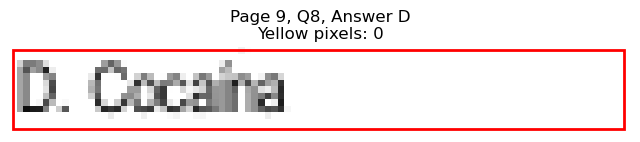

Page 9, Q8 - E: Detected box: x0=322.9, y0=712.3, x1=378.2, y1=724.4
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 296
Page 9, Q8, E: Yellow percentage: 0.0%


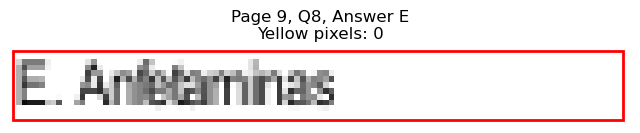


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=71.3, y0=96.8, x1=79.7, y1=108.8
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 62
Page 10, Q1, A: Yellow percentage: 0.0%


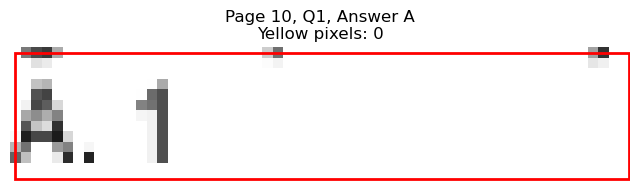

Page 10, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=93.2, y1=121.6
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 100
Page 10, Q1, B: Yellow percentage: 0.0%


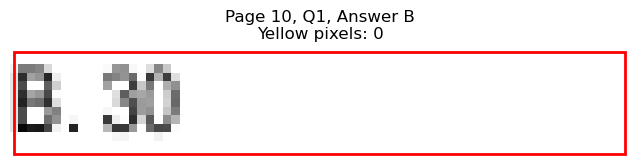

Page 10, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=94.0, y1=133.6
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 89
Page 10, Q1, C: Yellow percentage: 0.0%


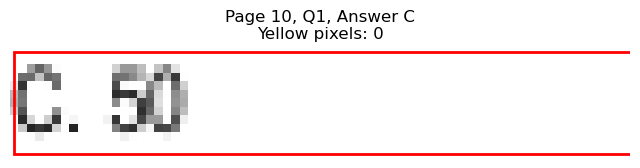

Page 10, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=345.5, y1=108.8
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 96
Page 10, Q1, D: Yellow percentage: 0.0%


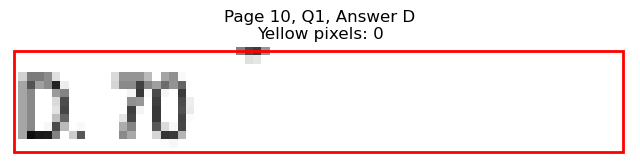

Page 10, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=344.8, y1=121.6
Page 10, Q1, E: Yellow pixels: 190
Page 10, Q1, E: Total non-white pixels: 273
Page 10, Q1, E: Yellow percentage: 69.6%


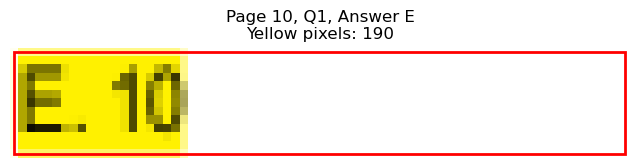


Page 10, Q1 - Selected Answer: E (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=94.0, y1=169.6
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 49
Page 10, Q2, A: Yellow percentage: 0.0%


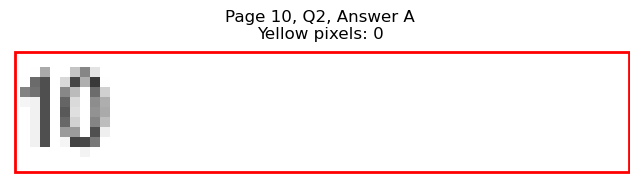

Page 10, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=95.5, y1=181.6
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 98
Page 10, Q2, B: Yellow percentage: 0.0%


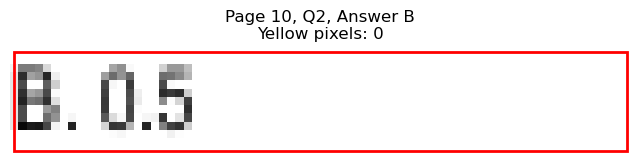

Page 10, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=94.0, y1=193.6
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 85
Page 10, Q2, C: Yellow percentage: 0.0%


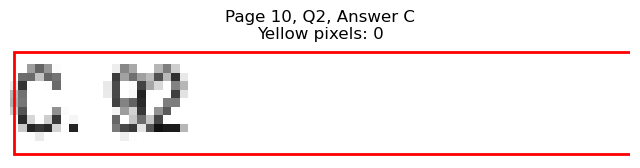

Page 10, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=345.6, y1=169.6
Page 10, Q2, D: Yellow pixels: 167
Page 10, Q2, D: Total non-white pixels: 286
Page 10, Q2, D: Yellow percentage: 58.4%


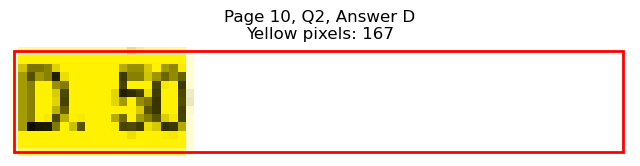

Page 10, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=344.8, y1=181.6
Page 10, Q2, E: Yellow pixels: 20
Page 10, Q2, E: Total non-white pixels: 105
Page 10, Q2, E: Yellow percentage: 19.0%


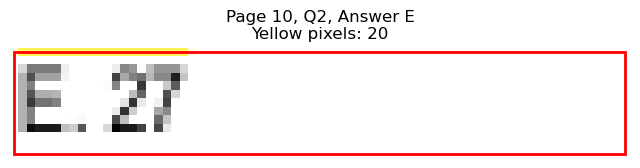


Page 10, Q2 - Selected Answer: D (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=160.8, y1=241.7
Page 10, Q3, A: Yellow pixels: 564
Page 10, Q3, A: Total non-white pixels: 1001
Page 10, Q3, A: Yellow percentage: 56.3%


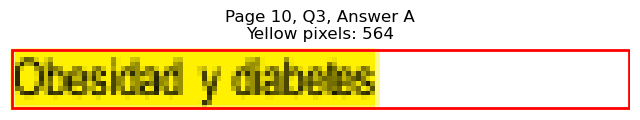

Page 10, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=137.5, y1=253.7
Page 10, Q3, B: Yellow pixels: 75
Page 10, Q3, B: Total non-white pixels: 567
Page 10, Q3, B: Yellow percentage: 13.2%


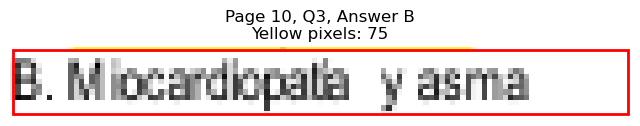

Page 10, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=159.2, y1=265.7
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 429
Page 10, Q3, C: Yellow percentage: 0.0%


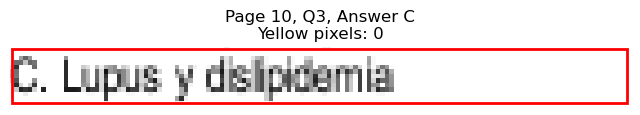

Page 10, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=387.5, y1=241.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 512
Page 10, Q3, D: Yellow percentage: 0.0%


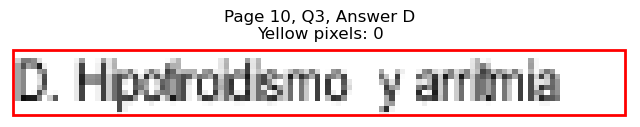

Page 10, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=380.8, y1=253.7
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 475
Page 10, Q3, E: Yellow percentage: 0.0%


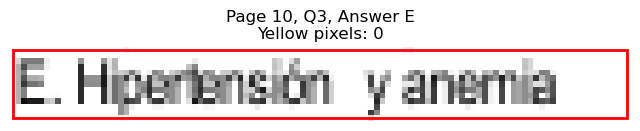


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=94.0, y1=301.8
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 43
Page 10, Q4, A: Yellow percentage: 0.0%


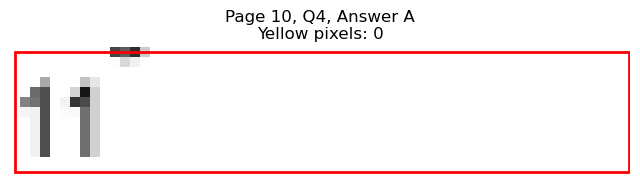

Page 10, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=88.7, y1=314.5
Page 10, Q4, B: Yellow pixels: 142
Page 10, Q4, B: Total non-white pixels: 208
Page 10, Q4, B: Yellow percentage: 68.3%


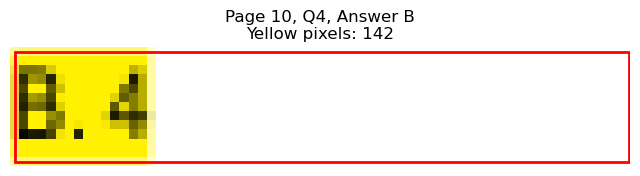

Page 10, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=89.5, y1=326.5
Page 10, Q4, C: Yellow pixels: 14
Page 10, Q4, C: Total non-white pixels: 70
Page 10, Q4, C: Yellow percentage: 20.0%


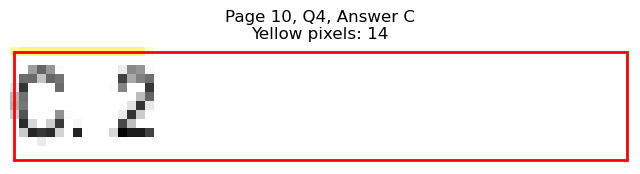

Page 10, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=341.0, y1=301.8
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 74
Page 10, Q4, D: Yellow percentage: 0.0%


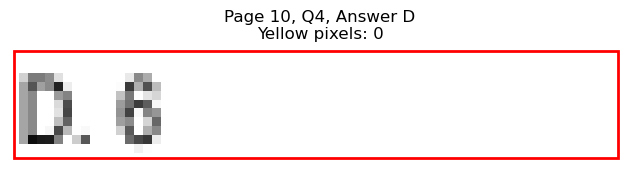

Page 10, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=340.3, y1=314.5
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 68
Page 10, Q4, E: Yellow percentage: 0.0%


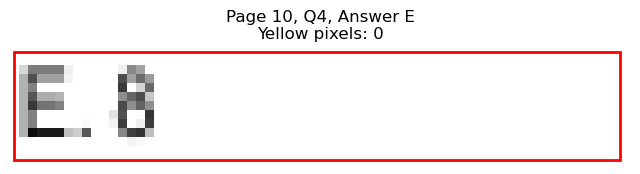


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=154.7, y1=374.6
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 356
Page 10, Q5, A: Yellow percentage: 0.0%


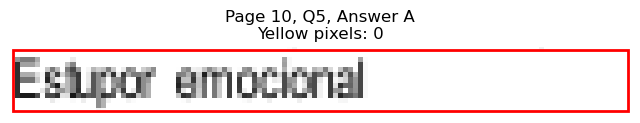

Page 10, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=106.7, y1=386.6
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 179
Page 10, Q5, B: Yellow percentage: 0.0%


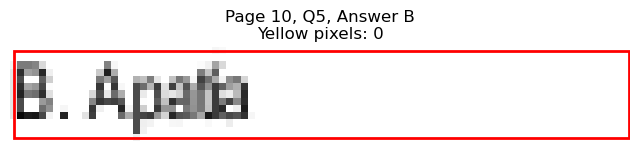

Page 10, Q5 - C: Detected box: x0=130.6, y0=386.5, x1=191.5, y1=398.6
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 325
Page 10, Q5, C: Yellow percentage: 0.0%


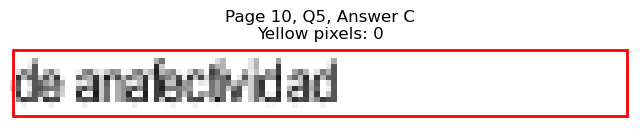

Page 10, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=390.6, y1=374.6
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 591
Page 10, Q5, D: Yellow percentage: 0.0%


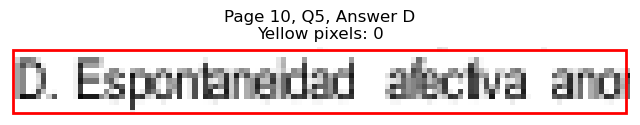

Page 10, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=403.4, y1=386.6
Page 10, Q5, E: Yellow pixels: 684
Page 10, Q5, E: Total non-white pixels: 1027
Page 10, Q5, E: Yellow percentage: 66.6%


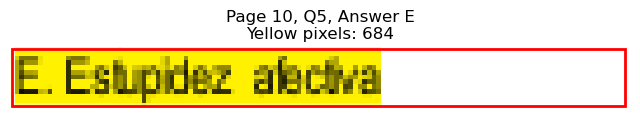


Page 10, Q5 - Selected Answer: E (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=128.5, y1=434.6
Page 10, Q6, A: Yellow pixels: 326
Page 10, Q6, A: Total non-white pixels: 588
Page 10, Q6, A: Yellow percentage: 55.4%


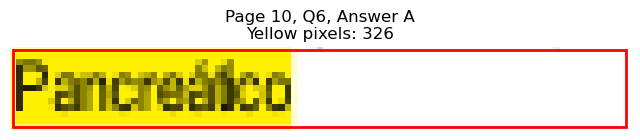

Page 10, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=113.5, y1=446.6
Page 10, Q6, B: Yellow pixels: 43
Page 10, Q6, B: Total non-white pixels: 240
Page 10, Q6, B: Yellow percentage: 17.9%


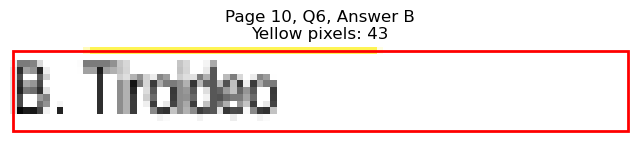

Page 10, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=150.2, y1=458.6
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 359
Page 10, Q6, C: Yellow percentage: 0.0%


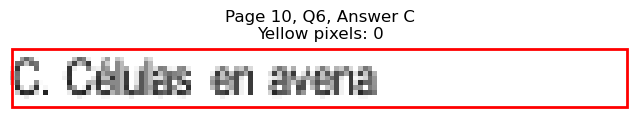

Page 10, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=365.8, y1=434.6
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 199
Page 10, Q6, D: Yellow percentage: 0.0%


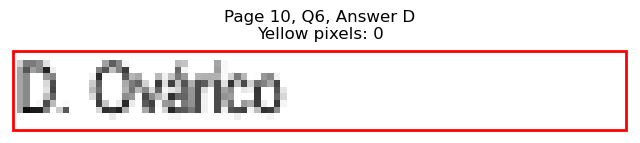

Page 10, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=371.8, y1=446.6
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 237
Page 10, Q6, E: Yellow percentage: 0.0%


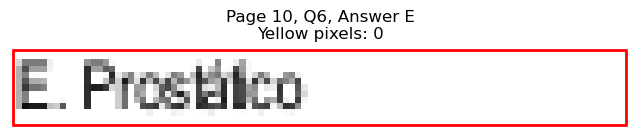


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=136.6, y0=495.4, x1=194.6, y1=507.4
Page 10, Q7, A: Yellow pixels: 483
Page 10, Q7, A: Total non-white pixels: 741
Page 10, Q7, A: Yellow percentage: 65.2%


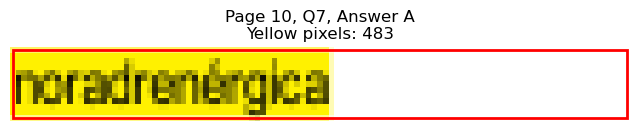

Page 10, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=181.7, y1=519.4
Page 10, Q7, B: Yellow pixels: 109
Page 10, Q7, B: Total non-white pixels: 635
Page 10, Q7, B: Yellow percentage: 17.2%


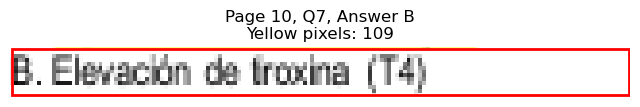

Page 10, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=164.5, y1=531.4
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 433
Page 10, Q7, C: Yellow percentage: 0.0%


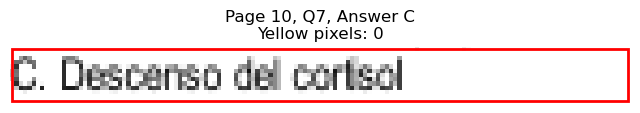

Page 10, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=423.5, y1=507.4
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 486
Page 10, Q7, D: Yellow percentage: 0.0%


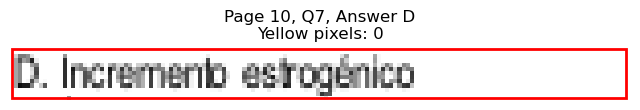

Page 10, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=421.2, y1=519.4
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 479
Page 10, Q7, E: Yellow percentage: 0.0%


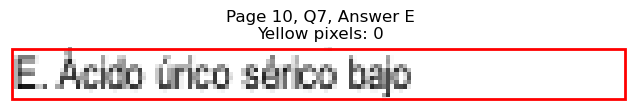


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.6, y0=555.4, x1=138.3, y1=567.5
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 294
Page 10, Q8, A: Yellow percentage: 0.0%


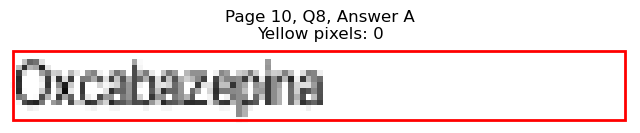

Page 10, Q8 - B: Detected box: x0=71.3, y0=567.5, x1=127.0, y1=579.5
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 292
Page 10, Q8, B: Yellow percentage: 0.0%


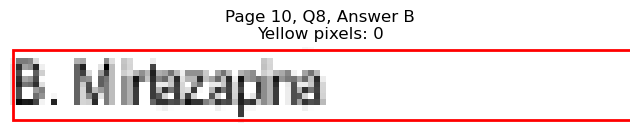

Page 10, Q8 - C: Detected box: x0=71.3, y0=579.4, x1=127.0, y1=591.5
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 263
Page 10, Q8, C: Yellow percentage: 0.0%


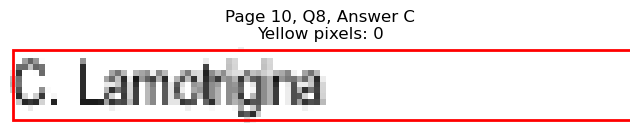

Page 10, Q8 - D: Detected box: x0=322.9, y0=555.4, x1=393.6, y1=567.5
Page 10, Q8, D: Yellow pixels: 624
Page 10, Q8, D: Total non-white pixels: 913
Page 10, Q8, D: Yellow percentage: 68.3%


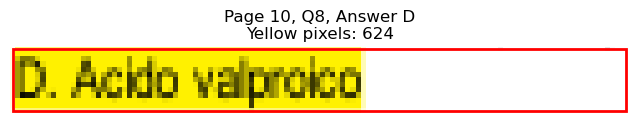

Page 10, Q8 - E: Detected box: x0=322.9, y0=567.5, x1=377.0, y1=579.5
Page 10, Q8, E: Yellow pixels: 68
Page 10, Q8, E: Total non-white pixels: 339
Page 10, Q8, E: Yellow percentage: 20.1%


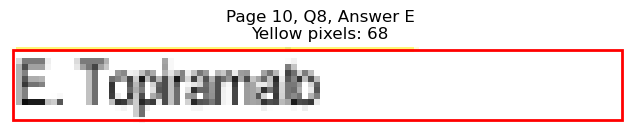


Page 10, Q8 - Selected Answer: D (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=82.6, y0=639.5, x1=125.5, y1=651.6
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 239
Page 10, Q9, A: Yellow percentage: 0.0%


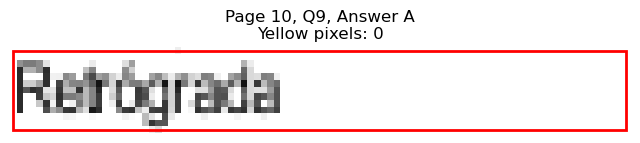

Page 10, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=125.5, y1=663.6
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 277
Page 10, Q9, B: Yellow percentage: 0.0%


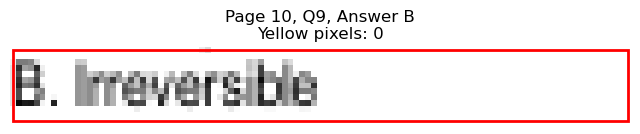

Page 10, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=124.0, y1=675.6
Page 10, Q9, C: Yellow pixels: 412
Page 10, Q9, C: Total non-white pixels: 663
Page 10, Q9, C: Yellow percentage: 62.1%


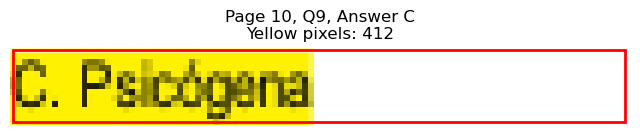

Page 10, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=377.0, y1=651.6
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 267
Page 10, Q9, D: Yellow percentage: 0.0%


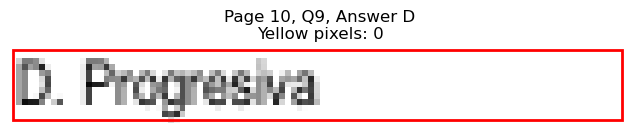

Page 10, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=380.8, y1=663.6
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 302
Page 10, Q9, E: Yellow percentage: 0.0%


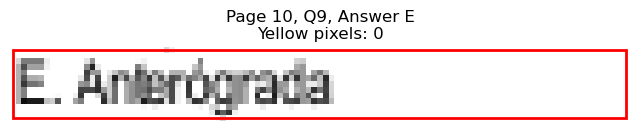


Page 10, Q9 - Selected Answer: C (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=82.6, y0=736.4, x1=122.5, y1=748.4
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 207
Page 10, Q10, A: Yellow percentage: 0.0%


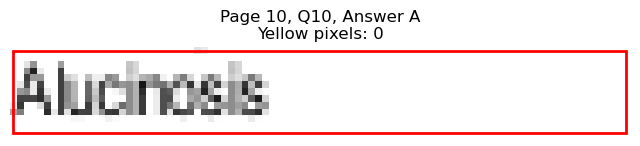

Page 10, Q10 - B: Detected box: x0=71.3, y0=748.4, x1=127.0, y1=760.4
Page 10, Q10, B: Yellow pixels: 0
Page 10, Q10, B: Total non-white pixels: 422
Page 10, Q10, B: Yellow percentage: 0.0%


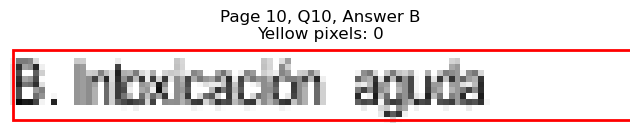

Page 10, Q10 - C: Detected box: x0=71.3, y0=760.4, x1=133.7, y1=772.4
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 555
Page 10, Q10, C: Yellow percentage: 0.0%


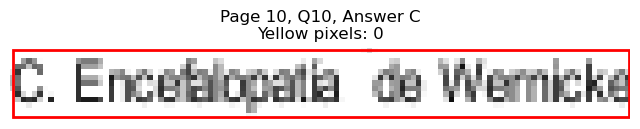

Page 10, Q10 - D: Detected box: x0=322.9, y0=736.4, x1=378.6, y1=748.4
Page 10, Q10, D: Yellow pixels: 450
Page 10, Q10, D: Total non-white pixels: 715
Page 10, Q10, D: Yellow percentage: 62.9%


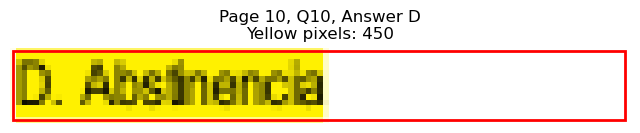

Page 10, Q10 - E: Detected box: x0=322.9, y0=748.4, x1=357.7, y1=760.4
Page 10, Q10, E: Yellow pixels: 53
Page 10, Q10, E: Total non-white pixels: 218
Page 10, Q10, E: Yellow percentage: 24.3%


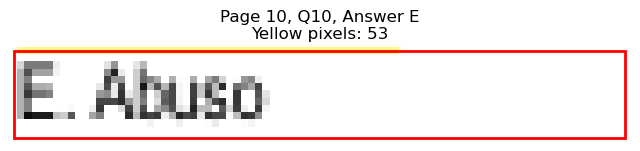


Page 10, Q10 - Selected Answer: D (based on yellow pixel count)





Page 11: Found 8 questions
Page 11, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=125.5, y1=121.6
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 228
Page 11, Q1, A: Yellow percentage: 0.0%


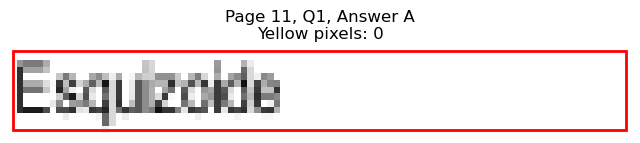

Page 11, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=118.7, y1=133.6
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 239
Page 11, Q1, B: Yellow percentage: 0.0%


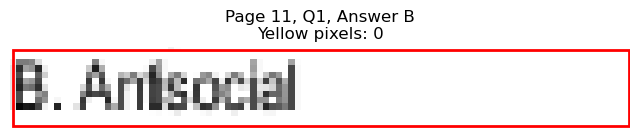

Page 11, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=115.0, y1=145.6
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 201
Page 11, Q1, C: Yellow percentage: 0.0%


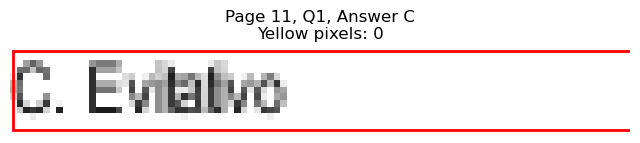

Page 11, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=384.5, y1=121.6
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 325
Page 11, Q1, D: Yellow percentage: 0.0%


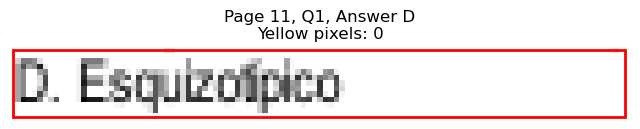

Page 11, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=373.4, y1=133.6
Page 11, Q1, E: Yellow pixels: 424
Page 11, Q1, E: Total non-white pixels: 637
Page 11, Q1, E: Yellow percentage: 66.6%


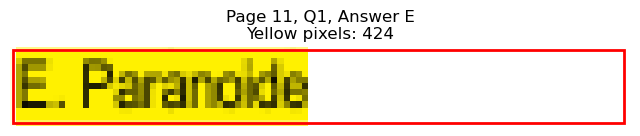


Page 11, Q1 - Selected Answer: E (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=115.0, y1=181.6
Page 11, Q2, A: Yellow pixels: 224
Page 11, Q2, A: Total non-white pixels: 406
Page 11, Q2, A: Yellow percentage: 55.2%


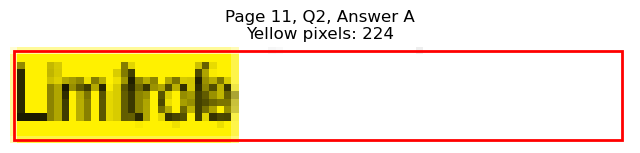

Page 11, Q2 - B: Detected box: x0=71.3, y0=121.5, x1=118.7, y1=133.6
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 239
Page 11, Q2, B: Yellow percentage: 0.0%


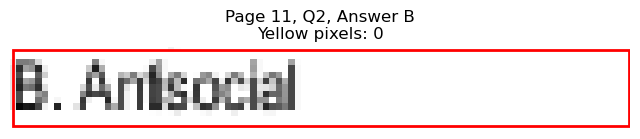

Page 11, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=130.0, y1=205.6
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 296
Page 11, Q2, C: Yellow percentage: 0.0%


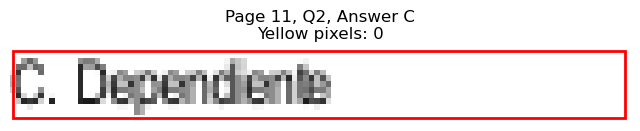

Page 11, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=374.0, y1=181.6
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 260
Page 11, Q2, D: Yellow percentage: 0.0%


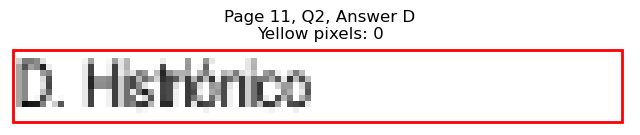

Page 11, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=371.0, y1=193.6
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 233
Page 11, Q2, E: Yellow percentage: 0.0%


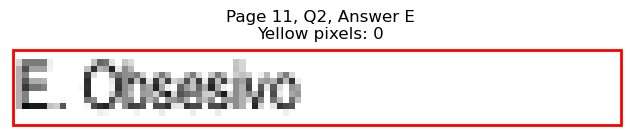


Page 11, Q2 - Selected Answer: A (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=130.0, y1=253.7
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 253
Page 11, Q3, A: Yellow percentage: 0.0%


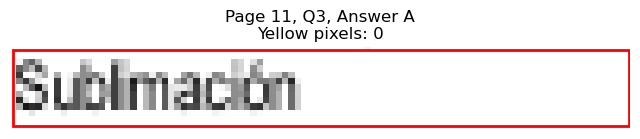

Page 11, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=126.2, y1=265.7
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 260
Page 11, Q3, B: Yellow percentage: 0.0%


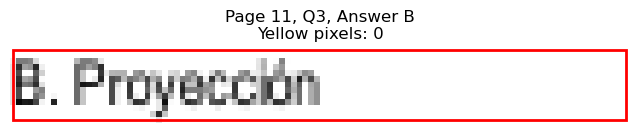

Page 11, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=116.5, y1=277.7
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 194
Page 11, Q3, C: Yellow percentage: 0.0%


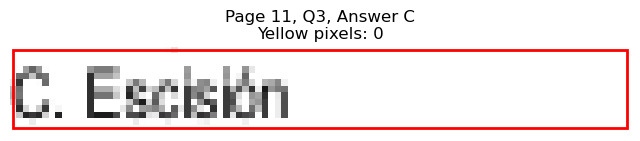

Page 11, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=380.1, y1=253.7
Page 11, Q3, D: Yellow pixels: 415
Page 11, Q3, D: Total non-white pixels: 728
Page 11, Q3, D: Yellow percentage: 57.0%


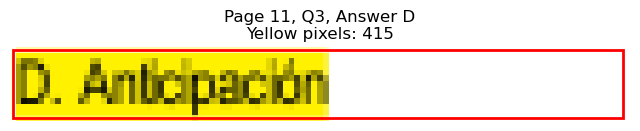

Page 11, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=380.8, y1=265.7
Page 11, Q3, E: Yellow pixels: 55
Page 11, Q3, E: Total non-white pixels: 341
Page 11, Q3, E: Yellow percentage: 16.1%


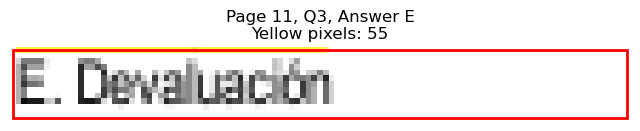


Page 11, Q3 - Selected Answer: D (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=105.3, y1=338.5
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 116
Page 11, Q4, A: Yellow percentage: 0.0%


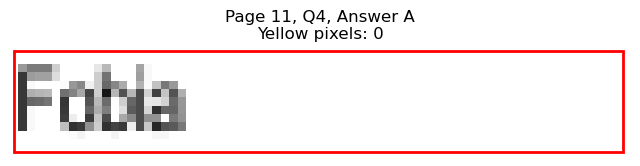

Page 11, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=109.8, y1=350.5
Page 11, Q4, B: Yellow pixels: 328
Page 11, Q4, B: Total non-white pixels: 481
Page 11, Q4, B: Yellow percentage: 68.2%


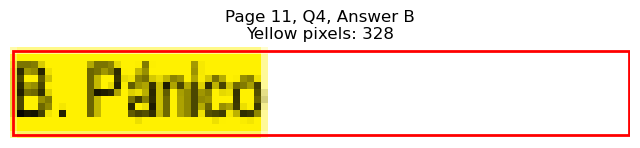

Page 11, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=116.4, y1=362.5
Page 11, Q4, C: Yellow pixels: 36
Page 11, Q4, C: Total non-white pixels: 236
Page 11, Q4, C: Yellow percentage: 15.3%


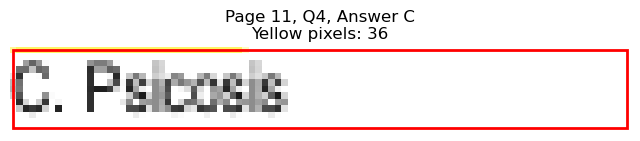

Page 11, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=365.0, y1=338.5
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 210
Page 11, Q4, D: Yellow percentage: 0.0%


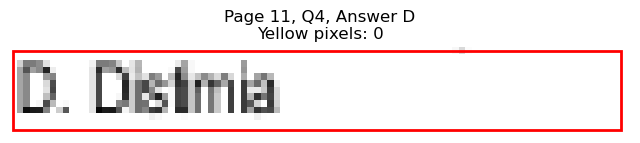

Page 11, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=377.8, y1=350.5
Page 11, Q4, E: Yellow pixels: 0
Page 11, Q4, E: Total non-white pixels: 270
Page 11, Q4, E: Yellow percentage: 0.0%


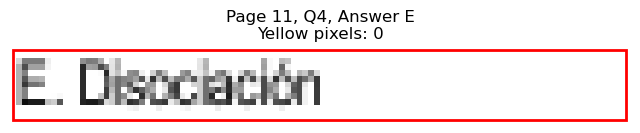


Page 11, Q4 - Selected Answer: B (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.6, y0=422.5, x1=187.0, y1=434.6
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 509
Page 11, Q5, A: Yellow percentage: 0.0%


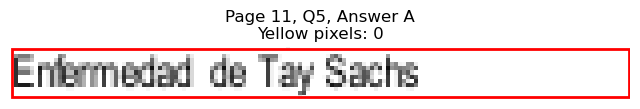

Page 11, Q5 - B: Detected box: x0=71.3, y0=434.6, x1=151.0, y1=446.6
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 398
Page 11, Q5, B: Yellow percentage: 0.0%


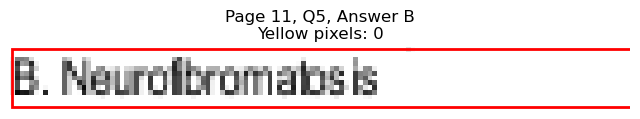

Page 11, Q5 - C: Detected box: x0=71.3, y0=446.6, x1=158.4, y1=458.6
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 400
Page 11, Q5, C: Yellow percentage: 0.0%


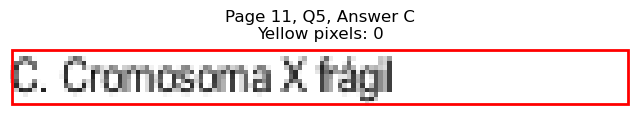

Page 11, Q5 - D: Detected box: x0=322.9, y0=422.5, x1=401.9, y1=434.6
Page 11, Q5, D: Yellow pixels: 616
Page 11, Q5, D: Total non-white pixels: 1015
Page 11, Q5, D: Yellow percentage: 60.7%


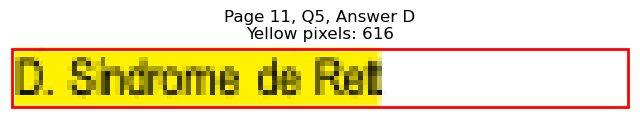

Page 11, Q5 - E: Detected box: x0=322.9, y0=434.6, x1=392.0, y1=446.6
Page 11, Q5, E: Yellow pixels: 76
Page 11, Q5, E: Total non-white pixels: 406
Page 11, Q5, E: Yellow percentage: 18.7%


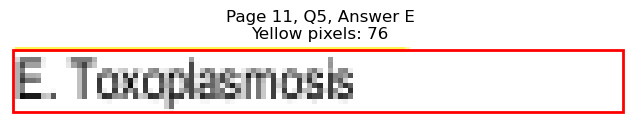


Page 11, Q5 - Selected Answer: D (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.6, y0=531.4, x1=151.8, y1=543.5
Page 11, Q6, A: Yellow pixels: 590
Page 11, Q6, A: Total non-white pixels: 886
Page 11, Q6, A: Yellow percentage: 66.6%


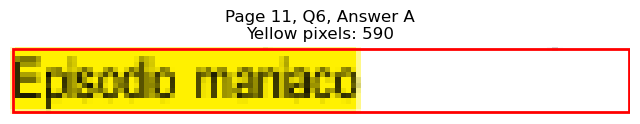

Page 11, Q6 - B: Detected box: x0=71.3, y0=543.4, x1=154.7, y1=555.5
Page 11, Q6, B: Yellow pixels: 66
Page 11, Q6, B: Total non-white pixels: 493
Page 11, Q6, B: Yellow percentage: 13.4%


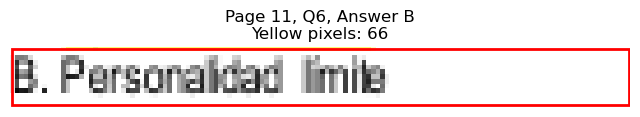

Page 11, Q6 - C: Detected box: x0=71.3, y0=555.4, x1=161.6, y1=567.5
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 433
Page 11, Q6, C: Yellow percentage: 0.0%


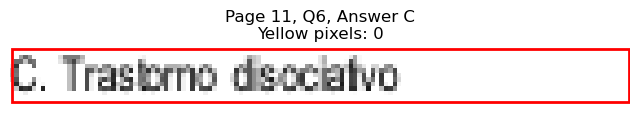

Page 11, Q6 - D: Detected box: x0=322.9, y0=531.4, x1=422.0, y1=543.5
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 502
Page 11, Q6, D: Yellow percentage: 0.0%


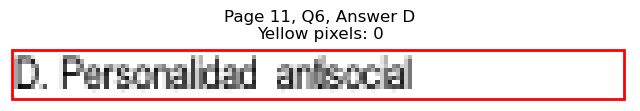

Page 11, Q6 - E: Detected box: x0=322.9, y0=543.4, x1=428.0, y1=555.5
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 500
Page 11, Q6, E: Yellow percentage: 0.0%


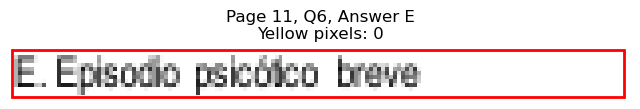


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.6, y0=603.5, x1=130.0, y1=615.5
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 261
Page 11, Q7, A: Yellow percentage: 0.0%


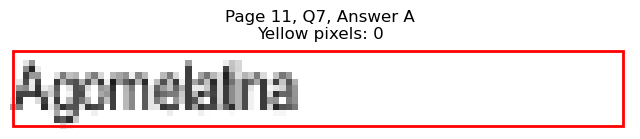

Page 11, Q7 - B: Detected box: x0=71.3, y0=615.5, x1=118.0, y1=627.5
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 236
Page 11, Q7, B: Yellow percentage: 0.0%


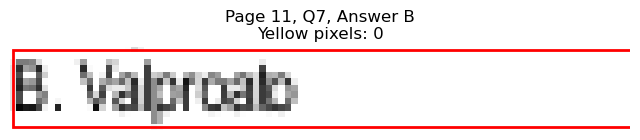

Page 11, Q7 - C: Detected box: x0=71.3, y0=627.5, x1=124.0, y1=639.6
Page 11, Q7, C: Yellow pixels: 464
Page 11, Q7, C: Total non-white pixels: 663
Page 11, Q7, C: Yellow percentage: 70.0%


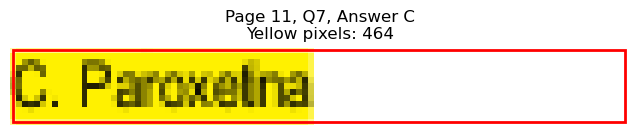

Page 11, Q7 - D: Detected box: x0=322.9, y0=603.5, x1=395.0, y1=615.5
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 368
Page 11, Q7, D: Yellow percentage: 0.0%


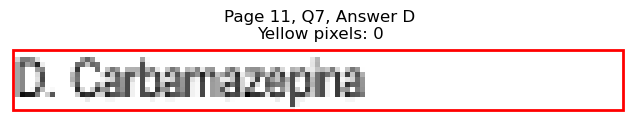

Page 11, Q7 - E: Detected box: x0=322.9, y0=615.5, x1=368.8, y1=627.5
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 227
Page 11, Q7, E: Yellow percentage: 0.0%


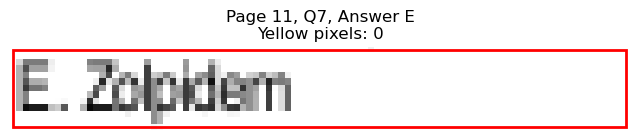


Page 11, Q7 - Selected Answer: C (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=82.6, y0=663.5, x1=136.0, y1=675.6
Page 11, Q8, A: Yellow pixels: 0
Page 11, Q8, A: Total non-white pixels: 268
Page 11, Q8, A: Yellow percentage: 0.0%


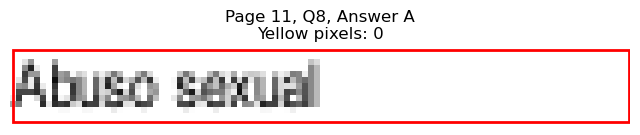

Page 11, Q8 - B: Detected box: x0=71.3, y0=676.3, x1=186.4, y1=688.3
Page 11, Q8, B: Yellow pixels: 924
Page 11, Q8, B: Total non-white pixels: 1469
Page 11, Q8, B: Yellow percentage: 62.9%


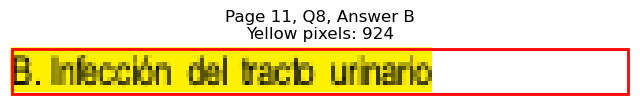

Page 11, Q8 - C: Detected box: x0=71.3, y0=688.3, x1=175.0, y1=700.3
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 618
Page 11, Q8, C: Yellow percentage: 0.0%


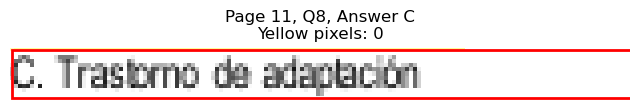

Page 11, Q8 - D: Detected box: x0=322.9, y0=663.5, x1=411.5, y1=675.6
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 422
Page 11, Q8, D: Yellow percentage: 0.0%


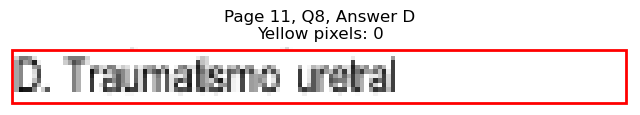

Page 11, Q8 - E: Detected box: x0=322.9, y0=676.3, x1=403.5, y1=688.3
Page 11, Q8, E: Yellow pixels: 0
Page 11, Q8, E: Total non-white pixels: 408
Page 11, Q8, E: Yellow percentage: 0.0%


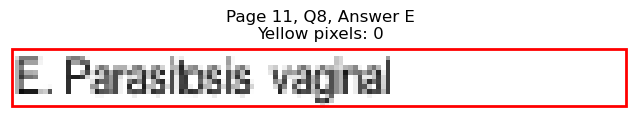


Page 11, Q8 - Selected Answer: B (based on yellow pixel count)





Page 12: Found 5 questions
Page 12, Q1 - A: Detected box: x0=82.6, y0=133.5, x1=125.5, y1=145.6
Page 12, Q1, A: Yellow pixels: 302
Page 12, Q1, A: Total non-white pixels: 546
Page 12, Q1, A: Yellow percentage: 55.3%


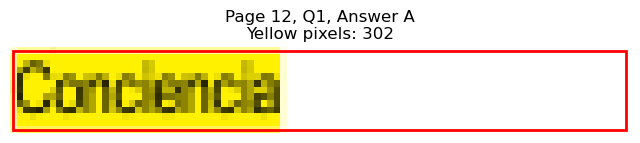

Page 12, Q1 - B: Detected box: x0=71.3, y0=145.6, x1=132.2, y1=157.6
Page 12, Q1, B: Yellow pixels: 40
Page 12, Q1, B: Total non-white pixels: 352
Page 12, Q1, B: Yellow percentage: 11.4%


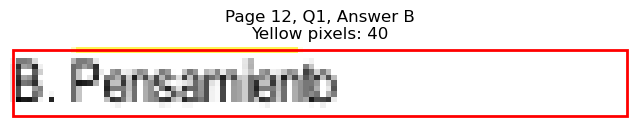

Page 12, Q1 - C: Detected box: x0=71.3, y0=157.6, x1=127.0, y1=169.6
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 257
Page 12, Q1, C: Yellow percentage: 0.0%


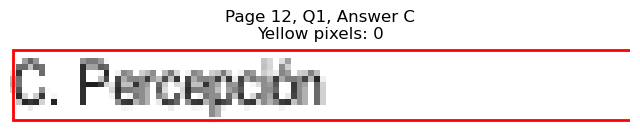

Page 12, Q1 - D: Detected box: x0=322.9, y0=133.5, x1=378.5, y1=145.6
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 277
Page 12, Q1, D: Yellow percentage: 0.0%


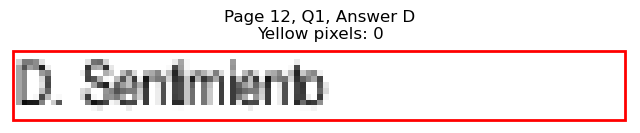

Page 12, Q1 - E: Detected box: x0=322.9, y0=145.6, x1=366.5, y1=157.6
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 208
Page 12, Q1, E: Yellow percentage: 0.0%


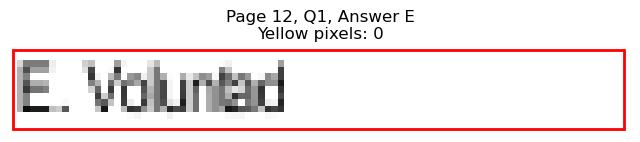


Page 12, Q1 - Selected Answer: A (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=82.6, y0=205.6, x1=171.2, y1=217.7
Page 12, Q2, A: Yellow pixels: 0
Page 12, Q2, A: Total non-white pixels: 467
Page 12, Q2, A: Yellow percentage: 0.0%


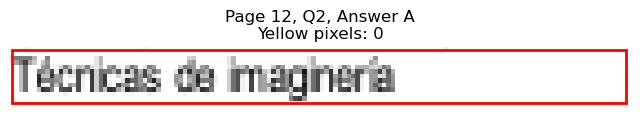

Page 12, Q2 - B: Detected box: x0=71.3, y0=217.6, x1=185.5, y1=229.7
Page 12, Q2, B: Yellow pixels: 0
Page 12, Q2, B: Total non-white pixels: 561
Page 12, Q2, B: Yellow percentage: 0.0%


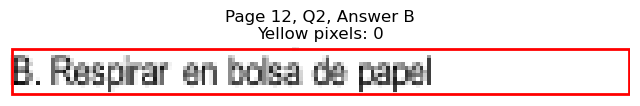

Page 12, Q2 - C: Detected box: x0=71.3, y0=229.6, x1=162.2, y1=241.7
Page 12, Q2, C: Yellow pixels: 0
Page 12, Q2, C: Total non-white pixels: 443
Page 12, Q2, C: Yellow percentage: 0.0%


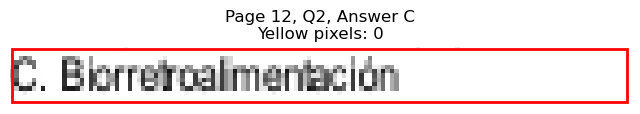

Page 12, Q2 - D: Detected box: x0=322.9, y0=205.6, x1=432.7, y1=217.7
Page 12, Q2, D: Yellow pixels: 805
Page 12, Q2, D: Total non-white pixels: 1417
Page 12, Q2, D: Yellow percentage: 56.8%


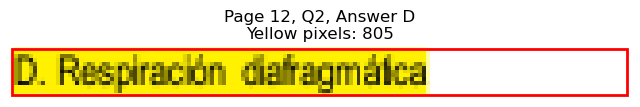

Page 12, Q2 - E: Detected box: x0=322.9, y0=217.6, x1=404.8, y1=229.7
Page 12, Q2, E: Yellow pixels: 107
Page 12, Q2, E: Total non-white pixels: 500
Page 12, Q2, E: Yellow percentage: 21.4%


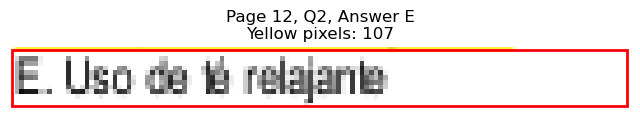


Page 12, Q2 - Selected Answer: D (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=82.6, y0=277.7, x1=122.5, y1=289.7
Page 12, Q3, A: Yellow pixels: 0
Page 12, Q3, A: Total non-white pixels: 216
Page 12, Q3, A: Yellow percentage: 0.0%


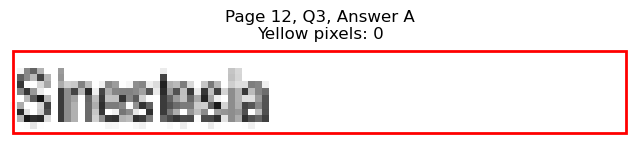

Page 12, Q3 - B: Detected box: x0=71.3, y0=289.7, x1=179.5, y1=301.8
Page 12, Q3, B: Yellow pixels: 0
Page 12, Q3, B: Total non-white pixels: 525
Page 12, Q3, B: Yellow percentage: 0.0%


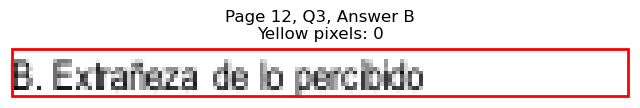

Page 12, Q3 - C: Detected box: x0=71.3, y0=302.5, x1=127.0, y1=314.5
Page 12, Q3, C: Yellow pixels: 0
Page 12, Q3, C: Total non-white pixels: 263
Page 12, Q3, C: Yellow percentage: 0.0%


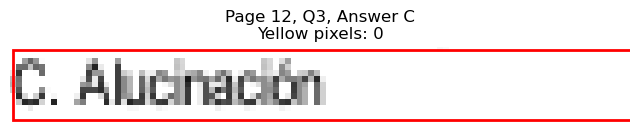

Page 12, Q3 - D: Detected box: x0=322.9, y0=277.7, x1=431.9, y1=289.7
Page 12, Q3, D: Yellow pixels: 842
Page 12, Q3, D: Total non-white pixels: 1404
Page 12, Q3, D: Yellow percentage: 60.0%


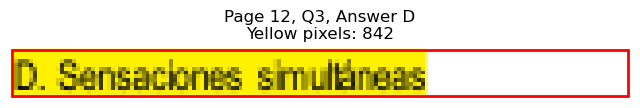

Page 12, Q3 - E: Detected box: x0=322.9, y0=289.7, x1=359.0, y1=301.8
Page 12, Q3, E: Yellow pixels: 87
Page 12, Q3, E: Total non-white pixels: 262
Page 12, Q3, E: Yellow percentage: 33.2%


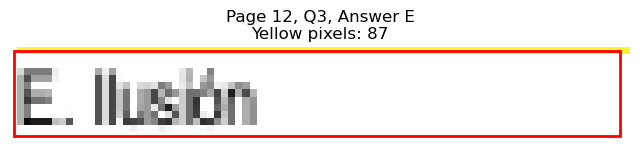


Page 12, Q3 - Selected Answer: D (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=82.6, y0=374.5, x1=144.3, y1=386.6
Page 12, Q4, A: Yellow pixels: 501
Page 12, Q4, A: Total non-white pixels: 781
Page 12, Q4, A: Yellow percentage: 64.1%


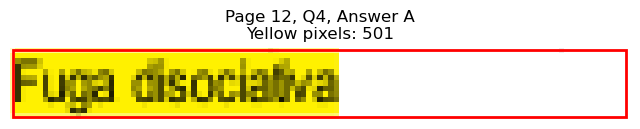

Page 12, Q4 - B: Detected box: x0=71.3, y0=386.5, x1=138.9, y1=398.6
Page 12, Q4, B: Yellow pixels: 59
Page 12, Q4, B: Total non-white pixels: 389
Page 12, Q4, B: Yellow percentage: 15.2%


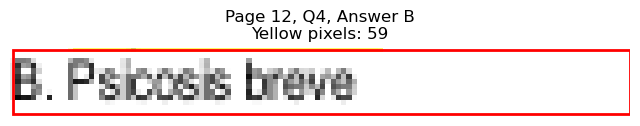

Page 12, Q4 - C: Detected box: x0=71.3, y0=398.5, x1=158.5, y1=410.6
Page 12, Q4, C: Yellow pixels: 0
Page 12, Q4, C: Total non-white pixels: 412
Page 12, Q4, C: Yellow percentage: 0.0%


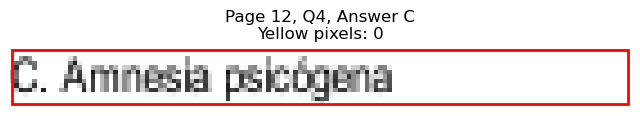

Page 12, Q4 - D: Detected box: x0=322.9, y0=374.5, x1=381.5, y1=386.6
Page 12, Q4, D: Yellow pixels: 0
Page 12, Q4, D: Total non-white pixels: 291
Page 12, Q4, D: Yellow percentage: 0.0%


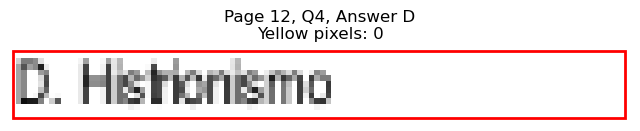

Page 12, Q4 - E: Detected box: x0=322.9, y0=386.5, x1=376.3, y1=398.6
Page 12, Q4, E: Yellow pixels: 0
Page 12, Q4, E: Total non-white pixels: 270
Page 12, Q4, E: Yellow percentage: 0.0%


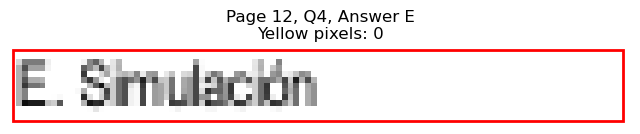


Page 12, Q4 - Selected Answer: A (based on yellow pixel count)




Page 12, Q5 - A: Detected box: x0=82.6, y0=434.6, x1=137.6, y1=446.6
Page 12, Q5, A: Yellow pixels: 418
Page 12, Q5, A: Total non-white pixels: 702
Page 12, Q5, A: Yellow percentage: 59.5%


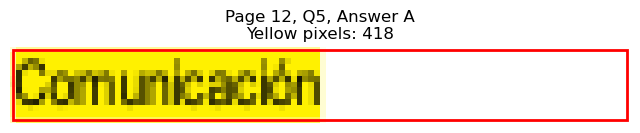

Page 12, Q5 - B: Detected box: x0=71.3, y0=446.6, x1=115.7, y1=458.6
Page 12, Q5, B: Yellow pixels: 52
Page 12, Q5, B: Total non-white pixels: 271
Page 12, Q5, B: Yellow percentage: 19.2%


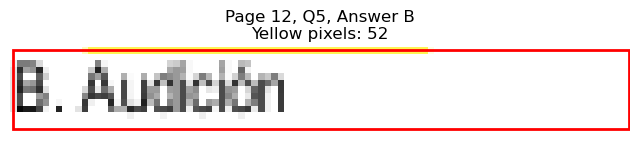

Page 12, Q5 - C: Detected box: x0=71.3, y0=458.6, x1=118.7, y1=470.6
Page 12, Q5, C: Yellow pixels: 0
Page 12, Q5, C: Total non-white pixels: 230
Page 12, Q5, C: Yellow percentage: 0.0%


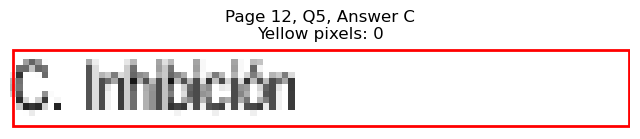

Page 12, Q5 - D: Detected box: x0=322.9, y0=434.6, x1=365.0, y1=446.6
Page 12, Q5, D: Yellow pixels: 0
Page 12, Q5, D: Total non-white pixels: 210
Page 12, Q5, D: Yellow percentage: 0.0%


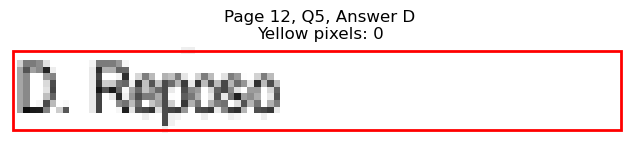

Page 12, Q5 - E: Detected box: x0=322.9, y0=446.6, x1=371.3, y1=458.6
Page 12, Q5, E: Yellow pixels: 0
Page 12, Q5, E: Total non-white pixels: 246
Page 12, Q5, E: Yellow percentage: 0.0%


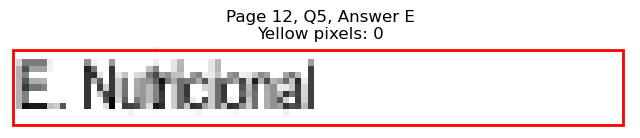


Page 12, Q5 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Qué anormalidad del pensamiento se caracteriz...
1   ¿Cuál de los siguientes trastornos presenta co...
2   ¿Cuál de los siguientes trastornos de personal...
3   Varón de 35 años, hace un año se hizo cirugía ...
4   Varón de 20 años, presenta problemas graves de...
..                                                ...
95  Mujer de 18 años, desde hace 24 horas luce hip...
96  ¿Qué medida no farmacológica, puede emplear un...
97  ¿Qué anormalidad presenta un paciente que se q...
98  Adolescente mujer de 15 años, residente en Lim...
99  En los niños con retardo mental. ¿Qué tipo de ...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                                option_B  \
0                   Obsesivo                              Delusional   
1             Hipotiroidismo                     Síndrome de Cushing   
2                Dependiente                               Evitativo   
3    Trastorno de adaptación                      Déficit vitamina D   
4   Dependencia a sustancias  Déficit de atención con hiperactividad   
..                       ...                                     ...   
95                Conciencia                             Pensamiento   
96    Técnicas de imaginería              Respirar en bolsa de papel   
97                Sinestesia               Extrañeza de lo percibido   
98          Fuga disociativa                          Psicosis breve   
99              Comunicación                                Audición   

                 option_C                    option_D  \
0          Esquizofrénico                   Demencial   
1          Hiperlipidemia           Diabetes mellitus   
2              Narcisista                 Histriónico   
3     Intoxicación por B1           Exceso vitamina E   
4       Conducta disocial  Antisocial de personalidad   
..                    ...                         ...   
95             Percepción                 Sentimiento   
96  Biorretroalimentación   Respiración diafragmática   
97            Alucinación     Sensaciones simultáneas   
98      Amnesia psicógena                Histrionismo   
99             Inhibición                      Reposo   

                      option_E  
0                Fuga de ideas  
1          Panhipopituitarismo  
2                     Obsesivo  
3         Déficit vitamina B12  
4   Narcisista de personalidad  
..                         ...  
95                    Voluntad  
96         Uso de té relajante  
97                     Ilusión  
98                  Simulación  
99                 Nutricional  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               A
2               D
3               E
4               D
..            ...
95              A
96              D
97              D
98              A
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿Qué anormalidad del pensamiento se caracteriz...   
1   ¿Cuál de los siguientes trastornos presenta co...   
2   ¿Cuál de los siguientes trastornos de personal...   
3   Varón de 35 años, hace un año se hizo cirugía ...   
4   Varón de 20 años, presenta problemas graves de...   
..                                                ...   
95  Mujer de 18 años, desde hace 24 horas luce hip...   
96  ¿Qué medida no farmacológica, puede emplear un...   
97  ¿Qué anormalidad presenta un paciente que se q...   
98  Adolescente mujer de 15 años, residente en Lim...   
99  En los niños con retardo mental. ¿Qué tipo de ...   

                    option_A                                option_B  \
0                   Obsesivo                              Delusional   
1             Hipotiroidismo                     Síndrome de Cushing   
2                Dependiente                               Evitativo   
3    Trastorno de adaptación                      Déficit vitamina D   
4   Dependencia a sustancias  Déficit de atención con hiperactividad   
..                       ...                                     ...   
95                Conciencia                             Pensamiento   
96    Técnicas de imaginería              Respirar en bolsa de papel   
97                Sinestesia               Extrañeza de lo percibido   
98          Fuga disociativa                          Psicosis breve   
99              Comunicación                                Audición   

                 option_C                    option_D  \
0          Esquizofrénico                   Demencial   
1          Hiperlipidemia           Diabetes mellitus   
2              Narcisista                 Histriónico   
3     Intoxicación por B1           Exceso vitamina E   
4       Conducta disocial  Antisocial de personalidad   
..                    ...                         ...   
95             Percepción                 Sentimiento   
96  Biorretroalimentación   Respiración diafragmática   
97            Alucinación     Sensaciones simultáneas   
98      Amnesia psicógena                Histrionismo   
99             Inhibición                      Reposo   

                      option_E correct_answer  
0                Fuga de ideas              C  
1          Panhipopituitarismo              A  
2                     Obsesivo              D  
3         Déficit vitamina B12              E  
4   Narcisista de personalidad              D  
..                         ...            ...  
95                    Voluntad              A  
96         Uso de té relajante              D  
97                     Ilusión              D  
98                  Simulación              A  
99                 Nutricional              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/PSIQUIATRIA.csv
